# Poor Children Impact Analysis - Wind-Speed Dependent Poverty Rates

This notebook extends the interpolation approach to model poverty rates that vary based on wind speed exposure. It uses Akima interpolation to fit both moderate and severe poverty rates, and implements a wind-speed dependent poverty calculation system.

- **No wind / Low wind (< 50kt)**: Only count children in **severe poverty** (most vulnerable, already in need)
- **Medium wind (50-95kt)**: Count children in **moderate poverty** too (disaster pushes them into need)
- **High wind (96kt+, Category 3+)**: Count **ALL children** (catastrophic disaster, everyone needs help)

### Poverty Rate Interpolation
- Fits Akima interpolation to quintile points for both moderate and severe poverty
- Enforces boundary conditions: RWI = -2 → 100% poverty, RWI = 2 → 0% poverty
- Scales to match target poor children count per area classification

### Wind-Speed Dependent Poverty Calculation

For each tile, we calculate which poverty threshold to use based on the wind speed it's exposed to:

1. **Calculate mutually exclusive wind speed probabilities** for all thresholds:
   - P(34kt only) = P(≥34kt) - P(≥40kt)
   - P(40kt only) = P(≥40kt) - P(≥50kt)
   - P(50kt only) = P(≥50kt) - P(≥64kt)
   - P(64kt only) = P(≥64kt) - P(≥83kt)
   - P(83kt only) = P(≥83kt) - P(≥96kt)
   - P(96kt only) = P(≥96kt) - P(≥113kt)
   - P(113kt only) = P(≥113kt) - P(≥137kt)
   - P(137kt only) = P(≥137kt)

2. **Apply poverty rates based on wind speed**:
   - Below 50kt: Severe poverty rate
   - 50kt to 96kt: Moderate poverty rate (with linear interpolation to 100%)
   - 96kt+ (Category 3+): 100% poverty (all children in need)

3. **Calculate expected children in need**

## Import Libraries

In [1]:
import os
import math
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy import interpolate
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
sns.set_palette("husl")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# ============================================================================
# VISUALIZATION SAVING SETUP
# ============================================================================
SAVE_VISUALIZATIONS = True
VISUALIZATIONS_DIR = "analysis_output/poor_children_impact_analysis_wind_dependent_poverty"

if SAVE_VISUALIZATIONS:
    os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)
    print(f"Visualizations will be saved to: {VISUALIZATIONS_DIR}/")
else:
    print("Visualization saving is disabled (set SAVE_VISUALIZATIONS = True to enable)")

# plt.show() wrapper for auto-saving
_original_show = plt.show

def _show_with_save(*args, **kwargs):
    """Wrapper around plt.show() that saves meaningful figures automatically"""
    if SAVE_VISUALIZATIONS:
        fig = plt.gcf()
        axes = fig.get_axes()
        
        filename = None
        
        if axes:
            try:
                if fig._suptitle is not None:
                    suptitle = fig._suptitle.get_text()
                    if suptitle and suptitle.strip():
                        filename = suptitle.lower().replace(' ', '_').replace('\n', '_')
                        filename = ''.join(c for c in filename if c.isalnum() or c in '_-')
                        # Truncate long filenames to avoid OneDrive timeout issues
                        if len(filename) > 80:
                            filename = filename[:80]
            except:
                pass
            
            if not filename:
                for ax in axes:
                    try:
                        title = ax.get_title()
                        if title and title.strip():
                            filename = title.lower().replace(' ', '_').replace('\n', '_')
                            filename = ''.join(c for c in filename if c.isalnum() or c in '_-')
                            # Truncate long filenames
                            if len(filename) > 80:
                                filename = filename[:80]
                            break
                    except:
                        pass
        
        if filename:
            output_file = os.path.join(VISUALIZATIONS_DIR, f"{filename}.png")
            try:
                fig.savefig(output_file, dpi=300, bbox_inches='tight')
                print(f"  Saved: {output_file}")
            except (TimeoutError, OSError, IOError) as e:
                # Catch timeout and I/O errors (common with OneDrive sync)
                print(f"  Warning: Could not save figure (timeout/I/O error): {e}")
                print(f"  Skipping save for: {output_file}")
            except Exception as e:
                # Catch any other errors and continue
                print(f"  Warning: Could not save figure: {e}")
    
    _original_show(*args, **kwargs)

plt.show = _show_with_save


Visualizations will be saved to: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/


## Configuration

In [2]:
# Base directory where downloaded files are located
BASE_DIR = "data"

# Country identifier
COUNTRY = "JAM"

# Impact probability data configuration
DATE = "2025-10-27"  # Format: YYYY-MM-DD
FORECAST_TIME = "000000"  # Format: HHMMSS

# All available wind speed thresholds (in knots) and their m/s equivalents
WIND_THRESHOLDS_DICT = {
    34: 17.49,   # Tropical storm force
    40: 20.58,   # Strong tropical storm
    50: 25.72,   # Very strong tropical storm
    64: 32.92,   # Category 1 hurricane
    83: 42.70,   # Category 2 hurricane
    96: 49.39,   # Category 3 hurricane
    113: 58.12,  # Category 4 hurricane
    137: 70.48   # Category 5 hurricane
}

# Wind thresholds to use for analysis (as strings for file naming)
WIND_THRESHOLDS = [str(kt) for kt in WIND_THRESHOLDS_DICT.keys()]

STORM = "MELISSA"  # Storm name

# ============================================================================
# POVERTY RATES BY CLASSIFICATION
# ============================================================================

# Moderate poverty rates (%) for children (ages 0-15) by area classification 2022
POVERTY_RATE_RURAL_MODERATE = 34.6460305820465
POVERTY_RATE_URBAN_MODERATE = 22.9166205159144
POVERTY_RATE_KMA_MODERATE = 34.5674892972073

# Severe poverty rates (%) for children (ages 0-15) by area classification 2022
POVERTY_RATE_RURAL_SEVERE = 7.93809499227347
POVERTY_RATE_URBAN_SEVERE = 5.07397966218306
POVERTY_RATE_KMA_SEVERE = 6.39376606394513

# SMOD classification threshold (>= 20 = urban, < 20 = rural)
SMOD_URBAN_THRESHOLD = 20.0

# Kingston Metropolitan Area parishes
KMA_PARISHES = ["Kingston", "Saint Andrew"]

# Quintile data file
QUINTILE_EXCEL_PATH = os.path.join(BASE_DIR, "ChPov_JAM_CUB.xlsx")
QUINTILE_COUNTRY = "JAM"
QUINTILE_YEAR = 2022

# ============================================================================
# WIND-SPEED DEPENDENT POVERTY RATE CONFIGURATION
# ============================================================================

# Wind speed thresholds (in knots) and corresponding poverty rate types
SEVERE_TO_MODERATE_THRESHOLD = 50   # Below this: severe poverty
MODERATE_TO_FULL_THRESHOLD = 96     # Category 3+ hurricane threshold

## Load Data

In [3]:
# Load pre-processed data
processed_file = "analysis_output/poor_children_impact_analysis_slope_opt/all_tiles_with_poor_children_flag.parquet"
if os.path.exists(processed_file):
    print("Loading pre-processed data...")
    gdf_tiles_with_admin = gpd.read_parquet(processed_file)
    if 'poverty_prob' in gdf_tiles_with_admin.columns:
        gdf_tiles_with_admin = gdf_tiles_with_admin.drop(columns=['poverty_prob'])
    print(f"Loaded {len(gdf_tiles_with_admin)} tiles")
else:
    raise FileNotFoundError("Please run the slope optimization notebook first to generate processed data")

# Load admin boundaries
admin_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "admin_views", f"{COUNTRY}_admin1.parquet")
if os.path.exists(admin_base_path):
    gdf_admin = gpd.read_parquet(admin_base_path)
    print(f"\nLoaded admin boundaries: {len(gdf_admin)} parishes")
else:
    print(f"\nWarning: Admin boundaries file not found at {admin_base_path}")
    gdf_admin = None

Loading pre-processed data...
Loaded 2224 tiles

Loaded admin boundaries: 14 parishes


## Load Quintile Poverty Data (Moderate and Severe)

In [4]:
# Load quintile RWI averages from pre-processed data
quintile_rwi_file = "analysis_output/quintile_method/quintile_population_weighted_rwi_summary.csv"
df_quintile_rwi = pd.read_csv(quintile_rwi_file)
print("Loaded quintile RWI averages from pre-processed data")

def load_quintile_poverty_data(excel_path, country='JAM', year=2022, poverty_type='moderate'):
    """
    Load poverty prevalence data by wealth quintile from Excel file.
    
    Parameters:
    -----------
    excel_path : str
        Path to the Excel file (ChPov_JAM_CUB.xlsx)
    country : str
        Country code (default: 'JAM')
    year : int
        Year of data (default: 2022)
    poverty_type : str
        'moderate' or 'severe' (default: 'moderate')
    
    Returns:
    --------
    df_quintile_points : DataFrame
        DataFrame with columns: classification, quintile, poverty_rate
    """
    try:
        # Read Excel file
        df = pd.read_excel(excel_path)
        
        # Filter for country and year
        df_filtered = df[(df['Country code'] == country) & (df['Year'] == year)].copy()
        
        if len(df_filtered) == 0:
            raise ValueError(f"No data found for {country} in year {year}")
        
        # Filter for WEALTH_QUINTILE dimension
        df_quintile = df_filtered[df_filtered['Dimension'] == 'WEALTH_QUINTILE'].copy()
        
        if len(df_quintile) == 0:
            raise ValueError(f"No wealth quintile data found for {country} in year {year}")
        
        # Find the column based on poverty type
        if poverty_type == 'moderate':
            poverty_col = 'Prevalence, moderate child poverty (%)'
        elif poverty_type == 'severe':
            poverty_col = 'Prevalence, severe child poverty (%)'
        else:
            raise ValueError(f"Unknown poverty_type: {poverty_type}. Must be 'moderate' or 'severe'")
        
        if poverty_col not in df_quintile.columns:
            raise ValueError(f"Could not find {poverty_col}. Available columns: {list(df_quintile.columns)}")
        
        # Map subregion names from Excel to our classification names
        subregion_mapping = {
            'Rural': 'Rural',
            'Urban': 'Urban',
            'Kingston Metropolitan Area (KMA)': 'KMA'
        }
        
        # Collect quintile points
        # Process all rows where Dimension == 'WEALTH_QUINTILE' (already filtered above)
        # Identify quintiles by checking if Subgroup starts with 'Q' followed by a number
        # Then use SUBREGION_NAME to map to our classifications
        quintile_points = []
        
        for _, row in df_quintile.iterrows():
            # Check if Subgroup indicates a quintile (starts with 'Q' followed by a number)
            subgroup = str(row['Subgroup']).strip()
            if not subgroup.startswith('Q'):
                continue
            
            try:
                quintile = int(subgroup[1])
                if quintile < 1 or quintile > 5:
                    continue
            except (ValueError, IndexError):
                continue
            
            # Get the subregion and map to our classification
            subregion_excel = row['SUBREGION_NAME']
            subregion_our = subregion_mapping.get(subregion_excel)
            
            if subregion_our is None:
                continue
            
            # Extract poverty rate
            try:
                poverty_pct = float(row[poverty_col])
                poverty_rate = poverty_pct / 100.0
                quintile_points.append({
                    'classification': subregion_our,
                    'quintile': quintile,
                    'poverty_rate': poverty_rate
                })
            except (ValueError, KeyError) as e:
                print(f"Warning: Could not extract poverty rate for {subregion_our} Q{quintile}: {e}")
                continue
        
        df_quintile_points = pd.DataFrame(quintile_points)
        
        # Verify we have all 5 quintiles for each classification
        for classification in ['Rural', 'Urban', 'KMA']:
            region_data = df_quintile_points[df_quintile_points['classification'] == classification]
            if len(region_data) != 5:
                print(f"Warning: Expected 5 quintiles for {classification}, found {len(region_data)}")
        
        return df_quintile_points
        
    except Exception as e:
        print(f"Error loading quintile data: {e}")
        import traceback
        traceback.print_exc()
        raise

# Load both moderate and severe poverty data
print("Loading Moderate Poverty Data:")
df_quintile_poverty_moderate = load_quintile_poverty_data(
    QUINTILE_EXCEL_PATH, 
    country=QUINTILE_COUNTRY, 
    year=QUINTILE_YEAR,
    poverty_type='moderate'
)

print("\n\nLoading Severe Poverty Data:")
df_quintile_poverty_severe = load_quintile_poverty_data(
    QUINTILE_EXCEL_PATH, 
    country=QUINTILE_COUNTRY, 
    year=QUINTILE_YEAR,
    poverty_type='severe'
)

Loaded quintile RWI averages from pre-processed data
Loading Moderate Poverty Data:


Loading Severe Poverty Data:


In [5]:
# Merge with RWI averages
df_quintile_points_moderate = df_quintile_rwi.merge(
    df_quintile_poverty_moderate, 
    on=['classification', 'quintile'], 
    how='left'
)

df_quintile_points_severe = df_quintile_rwi.merge(
    df_quintile_poverty_severe, 
    on=['classification', 'quintile'], 
    how='left'
)

print("\nQuintile Points Summary (Moderate):")
for region in ['Rural', 'Urban', 'KMA']:
    region_data = df_quintile_points_moderate[df_quintile_points_moderate['classification'] == region]
    if len(region_data) > 0:
        print(f"\n{region}:")
        for _, row in region_data.sort_values('quintile').iterrows():
            q = int(row['quintile'])
            print(f"  Q{q}: RWI={row['weighted_avg_rwi']:.3f}, Poverty Rate={row['poverty_rate']*100:.2f}%")

print("\nQuintile Points Summary (Severe):")
for region in ['Rural', 'Urban', 'KMA']:
    region_data = df_quintile_points_severe[df_quintile_points_severe['classification'] == region]
    if len(region_data) > 0:
        print(f"\n{region}:")
        for _, row in region_data.sort_values('quintile').iterrows():
            q = int(row['quintile'])
            print(f"  Q{q}: RWI={row['weighted_avg_rwi']:.3f}, Poverty Rate={row['poverty_rate']*100:.2f}%")


Quintile Points Summary (Moderate):

Rural:
  Q1: RWI=-0.281, Poverty Rate=61.24%
  Q2: RWI=0.026, Poverty Rate=32.71%
  Q3: RWI=0.245, Poverty Rate=22.43%
  Q4: RWI=0.441, Poverty Rate=18.43%
  Q5: RWI=0.785, Poverty Rate=11.61%

Urban:
  Q1: RWI=0.414, Poverty Rate=43.08%
  Q2: RWI=0.654, Poverty Rate=32.75%
  Q3: RWI=0.817, Poverty Rate=22.67%
  Q4: RWI=0.956, Poverty Rate=11.98%
  Q5: RWI=1.131, Poverty Rate=6.62%

KMA:
  Q1: RWI=0.425, Poverty Rate=70.76%
  Q2: RWI=0.824, Poverty Rate=48.04%
  Q3: RWI=0.998, Poverty Rate=33.79%
  Q4: RWI=1.190, Poverty Rate=17.59%
  Q5: RWI=1.471, Poverty Rate=10.57%

Quintile Points Summary (Severe):

Rural:
  Q1: RWI=-0.281, Poverty Rate=19.94%
  Q2: RWI=0.026, Poverty Rate=4.87%
  Q3: RWI=0.245, Poverty Rate=3.77%
  Q4: RWI=0.441, Poverty Rate=0.98%
  Q5: RWI=0.785, Poverty Rate=0.00%

Urban:
  Q1: RWI=0.414, Poverty Rate=14.97%
  Q2: RWI=0.654, Poverty Rate=6.67%
  Q3: RWI=0.817, Poverty Rate=2.71%
  Q4: RWI=0.956, Poverty Rate=2.08%
  Q5: RW

## Akima Interpolation

In [6]:
# Boundary conditions
RWI_MIN = -2.0
RWI_MAX = 2.0
POVERTY_RATE_MIN = 0.0  # At RWI_MAX
POVERTY_RATE_MAX = 1.0  # At RWI_MIN

def add_boundary_points(rwi, poverty_rate):
    """
    Add boundary points: RWI=-2 -> 100%, RWI=2 -> 0%
    
    Add these boundary points to ensure all methods respect the boundary conditions.
    The data is sorted to ensure monotonic decreasing order.
    """
    # Ensure monotonic decreasing by sorting
    sort_idx = np.argsort(rwi)
    sorted_rwi = rwi[sort_idx]
    sorted_poverty = poverty_rate[sort_idx]
    
    # This ensures all methods respect the boundary conditions
    extended_rwi = np.concatenate([[RWI_MIN], sorted_rwi, [RWI_MAX]])
    extended_poverty = np.concatenate([[POVERTY_RATE_MAX], sorted_poverty, [POVERTY_RATE_MIN]])
    
    return extended_rwi, extended_poverty

def fit_akima(quintile_rwi, quintile_poverty):
    """
    Fit Akima interpolation with boundary conditions.
    
    Akima interpolation is smooth and less oscillatory than standard cubic splines.
    """
    # Add boundary points to the fit
    extended_rwi, extended_poverty = add_boundary_points(quintile_rwi, quintile_poverty)
    
    # Akima interpolation
    akima = interpolate.Akima1DInterpolator(extended_rwi, extended_poverty)
    return {'akima': akima}

def predict_akima(rwi, params):
    """
    Predict using Akima interpolation.
    
    Handles extrapolation by enforcing boundary conditions.
    Since boundary points are included in the fit, interpolation should cover the range.
    """
    akima = params['akima']
    predicted = np.zeros_like(rwi)
    
    # Get the interpolation range from the fitted points
    rwi_min_fitted = akima.x[0]  # Should be RWI_MIN
    rwi_max_fitted = akima.x[-1]  # Should be RWI_MAX
    
    # Below minimum: enforce boundary condition (100% poverty)
    below_min = rwi < rwi_min_fitted
    predicted[below_min] = POVERTY_RATE_MAX
    
    # Above maximum: enforce boundary condition (0% poverty)
    above_max = rwi > rwi_max_fitted
    predicted[above_max] = POVERTY_RATE_MIN
    
    # Within interpolation range: use Akima
    in_range = ~(below_min | above_max)
    if np.any(in_range):
        predicted[in_range] = akima(rwi[in_range])
    
    # Ensure values stay in valid range [0, 1]
    predicted = np.clip(predicted, 0, 1)
    
    # Strictly enforce boundary conditions
    predicted[rwi <= RWI_MIN] = POVERTY_RATE_MAX
    predicted[rwi >= RWI_MAX] = POVERTY_RATE_MIN
    
    return predicted

def predict_akima_scaled(rwi, params, scale_factor):
    """
    Predict using Akima interpolation with scaling and enforced monotonicity.
    
    This wrapper ensures:
    1. Boundary conditions are enforced (RWI=-2 -> 100%, RWI=2 -> 0%)
    2. Scaling is applied
    3. Monotonicity is enforced after scaling
    """
    # Get base predictions
    predicted = predict_akima(rwi, params)
    
    # Apply scaling
    predicted = predicted * scale_factor
    
    # Enforce boundary conditions AFTER scaling
    predicted[rwi <= RWI_MIN] = POVERTY_RATE_MAX
    predicted[rwi >= RWI_MAX] = POVERTY_RATE_MIN
    
    # Ensure values stay in valid range [0, 1]
    predicted = np.clip(predicted, 0, 1)
    
    # Enforce monotonicity: ensure poverty rate decreases as RWI increases
    # Sort by RWI and make sure it's strictly decreasing
    sort_idx = np.argsort(rwi)
    sorted_rwi = rwi[sort_idx]
    sorted_pred = predicted[sort_idx]
    
    # Make it strictly decreasing (each value should be <= previous)
    for i in range(1, len(sorted_pred)):
        if sorted_pred[i] > sorted_pred[i-1]:
            sorted_pred[i] = sorted_pred[i-1]
    
    # Put back in original order
    predicted = np.zeros_like(rwi)
    predicted[sort_idx] = sorted_pred
    
    # Re-enforce boundary conditions one more time
    predicted[rwi <= RWI_MIN] = POVERTY_RATE_MAX
    predicted[rwi >= RWI_MAX] = POVERTY_RATE_MIN
    
    return predicted

def verify_monotonicity(rwi, poverty_rate):
    """
    Verify that poverty rate is monotonic decreasing with RWI.
    """
    # Sort by RWI to check monotonicity
    sort_idx = np.argsort(rwi)
    sorted_rwi = rwi[sort_idx]
    sorted_poverty = poverty_rate[sort_idx]
    
    # Check if decreasing (all differences should be <= 0)
    diffs = np.diff(sorted_poverty)
    is_monotonic = np.all(diffs <= 1e-10)  # Allow small numerical errors
    
    return is_monotonic, np.max(diffs) if len(diffs) > 0 else 0

def scale_to_match_target(predict_func, params, df_region, target_poor_children):
    """
    Scale the predicted poverty rates to match target poor children count.
    Uses a scaling factor applied to all predictions.
    Preserves monotonicity (scaling by constant preserves monotonicity).
    """
    rwi_values = df_region['rwi'].values
    pop_values = df_region['children_population'].values
    
    # Get base predictions
    base_predictions = predict_func(rwi_values, params)
    
    # Verify monotonicity before scaling
    is_mono_before, max_diff_before = verify_monotonicity(rwi_values, base_predictions)
    
    # Calculate current total poor children
    current_total = np.sum(base_predictions * pop_values)
    
    if current_total == 0:
        # If all predictions are 0, use uniform scaling
        scale_factor = target_poor_children / np.sum(pop_values)
    else:
        # Scale factor to match target
        scale_factor = target_poor_children / current_total
    
    # Apply scaling (but keep in [0, 1])
    scaled_predictions = np.clip(base_predictions * scale_factor, 0, 1)
    
    # Verify monotonicity after scaling
    is_mono_after, max_diff_after = verify_monotonicity(rwi_values, scaled_predictions)
    
    return scaled_predictions, scale_factor, is_mono_before, is_mono_after

In [7]:
# Fit Akima interpolation for both moderate and severe poverty
# These rates are used to calculate target poor children counts for scaling the interpolation

poverty_rate_map_moderate = {
    'Rural': POVERTY_RATE_RURAL_MODERATE / 100,
    'Urban': POVERTY_RATE_URBAN_MODERATE / 100,
    'KMA': POVERTY_RATE_KMA_MODERATE / 100
}

poverty_rate_map_severe = {
    'Rural': POVERTY_RATE_RURAL_SEVERE / 100,
    'Urban': POVERTY_RATE_URBAN_SEVERE / 100,
    'KMA': POVERTY_RATE_KMA_SEVERE / 100
}


all_results = {}

# Fit for both moderate and severe poverty
for poverty_type in ['moderate', 'severe']:
    print(f"\n{'='*80}")
    print(f"Fitting {poverty_type.upper()} Poverty")
    print(f"{'='*80}")
    
    if poverty_type == 'moderate':
        df_quintile_points = df_quintile_points_moderate
        poverty_rate_map = poverty_rate_map_moderate
    else:
        df_quintile_points = df_quintile_points_severe
        poverty_rate_map = poverty_rate_map_severe
    
    results_by_type = {}
    
    for region in ['Rural', 'Urban', 'KMA']:
        print(f"\n{'-'*80}")
        print(f"Region: {region}")
        print(f"{'-'*80}")
        
        # Filter region data
        mask = gdf_tiles_with_admin['area_classification'] == region
        df_region = gdf_tiles_with_admin[mask].copy()
        
        if len(df_region) == 0:
            continue
        
        # Calculate target
        total_pop = df_region['children_population'].sum()
        if region in poverty_rate_map:
            target_poor = total_pop * poverty_rate_map[region]
        else:
            print(f"Warning: No poverty rate found for {region}, skipping")
            continue
        
        # Get quintile points
        region_quintile_points = df_quintile_points[df_quintile_points['classification'] == region].copy()
        region_quintile_points = region_quintile_points.sort_values('quintile')
        
        if len(region_quintile_points) == 0:
            print(f"Warning: No quintile points found for {region}, skipping")
            continue
        
        # Sort by quintile to ensure proper order (Q1 to Q5)
        region_quintile_points = region_quintile_points.sort_values('quintile')
        
        quintile_rwi = region_quintile_points['weighted_avg_rwi'].values
        quintile_poverty = region_quintile_points['poverty_rate'].values
        
        # Verify quintile points are monotonic decreasing (poverty should decrease as RWI increases)
        # Note: If source data is not monotonic, this is a data quality issue, not an interpolation issue
        if len(quintile_poverty) > 1:
            poverty_diffs = np.diff(quintile_poverty)
            if not np.all(poverty_diffs <= 0):
                print(f"  Warning: Quintile poverty rates are not monotonic decreasing for {region}")
                print(f"    Poverty rates: {quintile_poverty}")
                print(f"    RWI values: {quintile_rwi}")
                print(f"    This is a data quality issue in the source Excel file")
        
        try:
            # Fit to quintile points
            fit_params = fit_akima(quintile_rwi, quintile_poverty)
            
            # Scale to match target
            scaled_predictions, scale_factor, mono_before, mono_after = scale_to_match_target(
                predict_akima,
                fit_params,
                df_region,
                target_poor
            )
            
            # Calculate errors
            achieved_poor = np.sum(scaled_predictions * df_region['children_population'].values)
            children_error = abs(achieved_poor - target_poor)
            children_error_pct = (children_error / target_poor * 100) if target_poor > 0 else 0
            
            # Create a scaled predict function that includes the scale_factor
            def predict_scaled(rwi, params):
                return predict_akima_scaled(rwi, params, scale_factor)
            
            results_by_type[region] = {
                'params': fit_params,
                'predictions': scaled_predictions,
                'scale_factor': scale_factor,
                'target_poor_children': target_poor,
                'achieved_poor_children': achieved_poor,
                'children_error': children_error,
                'children_error_pct': children_error_pct,
                'monotonic_before': mono_before,
                'monotonic_after': mono_after,
                'predict_func': predict_scaled
            }
            
            print(f"  Target: {target_poor:,.0f}, Achieved: {achieved_poor:,.0f}")
            print(f"  Error: {children_error:.2f} ({children_error_pct:.4f}%)")
            print(f"  Scale factor: {scale_factor:.4f}")
            print(f"  Monotonic: Before={mono_before}, After={mono_after}")
            
        except Exception as e:
            print(f"  FAILED - {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    all_results[poverty_type] = results_by_type


Fitting MODERATE Poverty

--------------------------------------------------------------------------------
Region: Rural
--------------------------------------------------------------------------------
  Target: 142,572, Achieved: 142,532
  Error: 40.00 (0.0281%)
  Scale factor: 1.1980
  Monotonic: Before=True, After=True

--------------------------------------------------------------------------------
Region: Urban
--------------------------------------------------------------------------------
  Target: 56,929, Achieved: 56,929
  Error: 0.00 (0.0000%)
  Scale factor: 0.9829
  Monotonic: Before=True, After=True

--------------------------------------------------------------------------------
Region: KMA
--------------------------------------------------------------------------------
  Target: 64,256, Achieved: 64,256
  Error: 0.00 (0.0000%)
  Scale factor: 0.9627
  Monotonic: Before=True, After=True

Fitting SEVERE Poverty

------------------------------------------------------------

## Wind-Speed Dependent Poverty Calculation

In [8]:
date_str = DATE.replace("-", "")
forecast_datetime_str = f"{date_str}{FORECAST_TIME}"
impact_tile_data = {}

if DATE and FORECAST_TIME and WIND_THRESHOLDS and STORM:
    # Load tile-level data for each wind threshold
    for wind_threshold in WIND_THRESHOLDS:
        tile_impact_file = f"{COUNTRY}_{STORM}_{forecast_datetime_str}_{wind_threshold}_14.csv"
        tile_impact_path = os.path.join(BASE_DIR, "geodb", "aos_views", "mercator_views", tile_impact_file)
        
        if os.path.exists(tile_impact_path):
            print(f"Loading tile-level impact data for {wind_threshold}kt from: {tile_impact_path}")
            df_tile = pd.read_csv(tile_impact_path)
            
            # Find the zone/tile ID column
            zone_col = None
            for col in df_tile.columns:
                if col.lower() in ['zone_id', 'tile_id', 'id', 'zone']:
                    zone_col = col
                    break
            
            if zone_col and 'probability' in df_tile.columns:
                df_tile_clean = df_tile[[zone_col, 'probability']].copy()
                # Convert tile ID to string and ensure it matches the format in tiles dataframe
                # Tiles have leading zeros (e.g., '03221022110331'), impact files have integers (e.g., 3221022110331)
                # Convert to string and pad with leading zero if needed to match 14-digit format
                df_tile_clean[zone_col] = df_tile_clean[zone_col].astype(str).str.zfill(14)
                impact_tile_data[wind_threshold] = df_tile_clean.rename(columns={zone_col: 'tile_id_source'})
            else:
                print(f"  Tile file missing required columns; {wind_threshold}kt will have 0 impact")
        else:
            print(f"Tile-level impact file not found for {wind_threshold}kt: {tile_impact_path}")
            print(f"  {wind_threshold}kt will have 0 impact (no data available)")

Loading tile-level impact data for 34kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_34_14.csv
Loading tile-level impact data for 40kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_40_14.csv
Loading tile-level impact data for 50kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_50_14.csv
Loading tile-level impact data for 64kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_64_14.csv
Loading tile-level impact data for 83kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_83_14.csv
Loading tile-level impact data for 96kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_96_14.csv
Loading tile-level impact data for 113kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_113_14.csv
Loading tile-level impact data for 137kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_137_14.csv


In [9]:
# Merge impact probabilities into tiles
gdf_tiles_with_impact = gdf_tiles_with_admin.copy()

if WIND_THRESHOLDS:
    # Find the tile_id column in the tiles dataframe
    tile_id_col = None
    for col in gdf_tiles_with_impact.columns:
        if col.lower() in ['tile_id', 'id', 'zone_id']:
            tile_id_col = col
            break
    
    if tile_id_col:
        # Convert tile_id to string once before the loop to avoid type mismatch
        gdf_tiles_with_impact[tile_id_col] = gdf_tiles_with_impact[tile_id_col].astype(str)
        
        for wind_threshold, df_tile in impact_tile_data.items():
            prob_col = f'impact_probability_{wind_threshold}kt'
            
            # Drop the column if it already exists
            if prob_col in gdf_tiles_with_impact.columns:
                gdf_tiles_with_impact = gdf_tiles_with_impact.drop(columns=[prob_col])
            
            # Also drop any suffixed versions that might exist
            for col in list(gdf_tiles_with_impact.columns):
                if col.startswith(prob_col) and col != prob_col:
                    gdf_tiles_with_impact = gdf_tiles_with_impact.drop(columns=[col])
            
            # Ensure both columns have the same type for merging
            # Convert both to string to avoid type mismatch issues
            df_tile_merge = df_tile.copy()
            df_tile_merge['tile_id_source'] = df_tile_merge['tile_id_source'].astype(str)
            
            # Rename probability column to the desired column name
            if 'probability' in df_tile_merge.columns:
                df_tile_merge = df_tile_merge.rename(columns={'probability': prob_col})
            else:
                print(f"  Warning: 'probability' column not found in {wind_threshold}kt data, skipping")
                continue
            
            # Verify the columns exist before merging
            if prob_col not in df_tile_merge.columns or 'tile_id_source' not in df_tile_merge.columns:
                print(f"  Warning: Required columns not found in {wind_threshold}kt data, skipping")
                continue
            
            # Merge impact probability - only merge the columns we need
            gdf_tiles_with_impact = gdf_tiles_with_impact.merge(
                df_tile_merge[['tile_id_source', prob_col]],
                left_on=tile_id_col,
                right_on='tile_id_source',
                how='left'
            )
            
            # Fill NaN values with 0.0 (tiles with no impact data)
            gdf_tiles_with_impact[prob_col] = gdf_tiles_with_impact[prob_col].fillna(0.0)
            
            # Drop the temporary merge column
            if 'tile_id_source' in gdf_tiles_with_impact.columns:
                gdf_tiles_with_impact = gdf_tiles_with_impact.drop(columns=['tile_id_source'])
            
            print(f"  Merged {wind_threshold}kt: {len(df_tile)} impact tiles")
    else:
        print("Warning: Could not find tile_id column for merging impact data")

print(f"\nImpact probability columns added: {[col for col in gdf_tiles_with_impact.columns if 'impact_probability' in col]}")

  Merged 34kt: 2231 impact tiles
  Merged 40kt: 2231 impact tiles
  Merged 50kt: 2231 impact tiles
  Merged 64kt: 2231 impact tiles
  Merged 83kt: 2231 impact tiles
  Merged 96kt: 2231 impact tiles
  Merged 113kt: 2231 impact tiles
  Merged 137kt: 2231 impact tiles

Impact probability columns added: ['impact_probability_34kt', 'impact_probability_40kt', 'impact_probability_50kt', 'impact_probability_64kt', 'impact_probability_83kt', 'impact_probability_96kt', 'impact_probability_113kt', 'impact_probability_137kt']


In [10]:
# Calculate wind-speed dependent poverty rates and CHIN
# This function calculates poverty rates that vary based on wind speed exposure
def calculate_wind_dependent_poverty(gdf_tiles, all_results):
    """
    Calculate wind-speed dependent poverty rates and children in need.
    
    Parameters:
    -----------
    gdf_tiles : GeoDataFrame
        Tiles with impact probabilities and RWI values
    all_results : dict
        Dictionary with 'moderate' and 'severe' poverty interpolation results
    
    Uses global threshold constants SEVERE_TO_MODERATE_THRESHOLD and MODERATE_TO_FULL_THRESHOLD.
    Always uses interpolation between thresholds.
    
    Returns:
    --------
    gdf_tiles : GeoDataFrame
        Tiles with wind-speed dependent poverty rates and CHIN added
    """
    gdf_result = gdf_tiles.copy()
    
    # Initialize columns
    gdf_result['poverty_prob_severe'] = 0.0
    gdf_result['poverty_prob_moderate'] = 0.0
    gdf_result['poverty_prob_wind_dependent'] = 0.0
    
    # Get poverty predictions for each region and poverty type
    for region in ['Rural', 'Urban', 'KMA']:
        mask = gdf_result['area_classification'] == region
        df_region = gdf_result[mask].copy()
        
        if len(df_region) == 0:
            continue
        
        # Get RWI values for this region
        rwi_values = df_region['rwi'].values
        
        # Get severe poverty predictions
        if 'severe' in all_results and region in all_results['severe']:
            severe_params = all_results['severe'][region]['params']
            severe_predictions = all_results['severe'][region]['predict_func'](rwi_values, severe_params)
            gdf_result.loc[mask, 'poverty_prob_severe'] = severe_predictions
        
        # Get moderate poverty predictions
        if 'moderate' in all_results and region in all_results['moderate']:
            moderate_params = all_results['moderate'][region]['params']
            moderate_predictions = all_results['moderate'][region]['predict_func'](rwi_values, moderate_params)
            gdf_result.loc[mask, 'poverty_prob_moderate'] = moderate_predictions
    
    # Now calculate wind-speed dependent poverty
    # Handle mutually exclusive wind speed probabilities for ALL thresholds
    
    # Get all impact probability columns
    threshold_ints = sorted(WIND_THRESHOLDS_DICT.keys())
    prob_cols = {kt: f'impact_probability_{kt}kt' for kt in threshold_ints}
    
    # Load probabilities for all thresholds (fill missing with 0)
    probs = {}
    for kt, col in prob_cols.items():
        if col in gdf_result.columns:
            probs[kt] = gdf_result[col].fillna(0.0).values
        else:
            probs[kt] = np.zeros(len(gdf_result))
    
    # Calculate mutually exclusive probabilities for each threshold
    # P(kt only) = P(>=kt) - P(>=next_higher_kt)
    prob_only = {}
    for i, kt in enumerate(threshold_ints):
        if i < len(threshold_ints) - 1:
            # Not the highest threshold: subtract next higher
            next_kt = threshold_ints[i + 1]
            prob_only[kt] = np.maximum(0, probs[kt] - probs[next_kt])
        else:
            # Highest threshold: just use its probability
            prob_only[kt] = probs[kt].copy()
    
    # Calculate wind-speed dependent poverty rate
    # Apply poverty rates based on wind speed thresholds:
    # - Below 50kt: severe poverty
    # - 50kt to 96kt: moderate poverty (with interpolation)
    # - 96kt+ (Cat3+): 100% poverty
    
    # Get poverty rates
    poverty_severe = gdf_result['poverty_prob_severe'].values
    poverty_moderate = gdf_result['poverty_prob_moderate'].values
    poverty_full = np.ones(len(gdf_result))  # 100% for Cat3+
    
    # Initialize wind-dependent poverty
    wind_dependent_poverty = np.zeros(len(gdf_result))
    
    children_pop = gdf_result['children_population'].values
    
    # Process each threshold and apply appropriate poverty rate
    for kt in threshold_ints:
        prob_kt_only = prob_only[kt]
        
        # Determine poverty rate based on threshold
        if kt < SEVERE_TO_MODERATE_THRESHOLD:
            # Below 50kt: use severe poverty
            poverty_rate = poverty_severe
        elif kt < MODERATE_TO_FULL_THRESHOLD:
            # Between 50kt and 96kt: use moderate poverty with interpolation
            # Interpolate between moderate (at 50kt) and 100% (at 96kt)
            if kt == SEVERE_TO_MODERATE_THRESHOLD:
                # Exactly at 50kt: use moderate
                poverty_rate = poverty_moderate
            else:
                # Between 50kt and 96kt: linear interpolation
                # Interpolation factor: 0 at 50kt, 1 at 96kt
                interp_factor = (kt - SEVERE_TO_MODERATE_THRESHOLD) / (MODERATE_TO_FULL_THRESHOLD - SEVERE_TO_MODERATE_THRESHOLD)
                # Interpolate: moderate * (1 - factor) + 1.0 * factor
                poverty_rate = poverty_moderate * (1 - interp_factor) + poverty_full * interp_factor
        else:
            # 96kt+ (Cat3+): 100% poverty
            poverty_rate = poverty_full
        
        # Add contribution to wind-dependent poverty
        wind_dependent_poverty += prob_kt_only * poverty_rate
    

    total_prob = np.zeros(len(gdf_result))
    for kt in threshold_ints:
        total_prob += prob_only[kt]
    
    # Add the "no wind" component: (1 - total_prob) x severe_rate
    # This accounts for the probability of NO wind, which should use severe poverty
    no_wind_component = (1.0 - total_prob) * poverty_severe
    wind_dependent_poverty += no_wind_component
    
    # Ensure wind-dependent poverty is always at least equal to severe poverty
    # (since even with low wind, we use severe rates for low wind speeds and no wind)
    wind_dependent_poverty = np.maximum(wind_dependent_poverty, poverty_severe)
    
    # Clip to valid range
    gdf_result['poverty_prob_wind_dependent'] = np.clip(wind_dependent_poverty, 0, 1)
    
    # Calculate poor_children_wind_dependent from the final poverty_prob_wind_dependent
    # This is the expected number of children in need
    gdf_result['poor_children_wind_dependent'] = (
        gdf_result['poverty_prob_wind_dependent'] * gdf_result['children_population']
    )
    
    # Store individual threshold probabilities for analysis
    for kt in threshold_ints:
        gdf_result[f'prob_{kt}kt_only'] = prob_only[kt]
    
    return gdf_result

# Calculate wind-speed dependent poverty
gdf_tiles_final = calculate_wind_dependent_poverty(
    gdf_tiles_with_impact,
    all_results
)

print(f"Total poor children (wind-dependent / CHIN): {gdf_tiles_final['poor_children_wind_dependent'].sum():,.0f}")

Total poor children (wind-dependent / CHIN): 54,524


## Visualize Results

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/rural_moderate_vs_severe_poverty_comparison_moderate_269_110639_children__severe.png


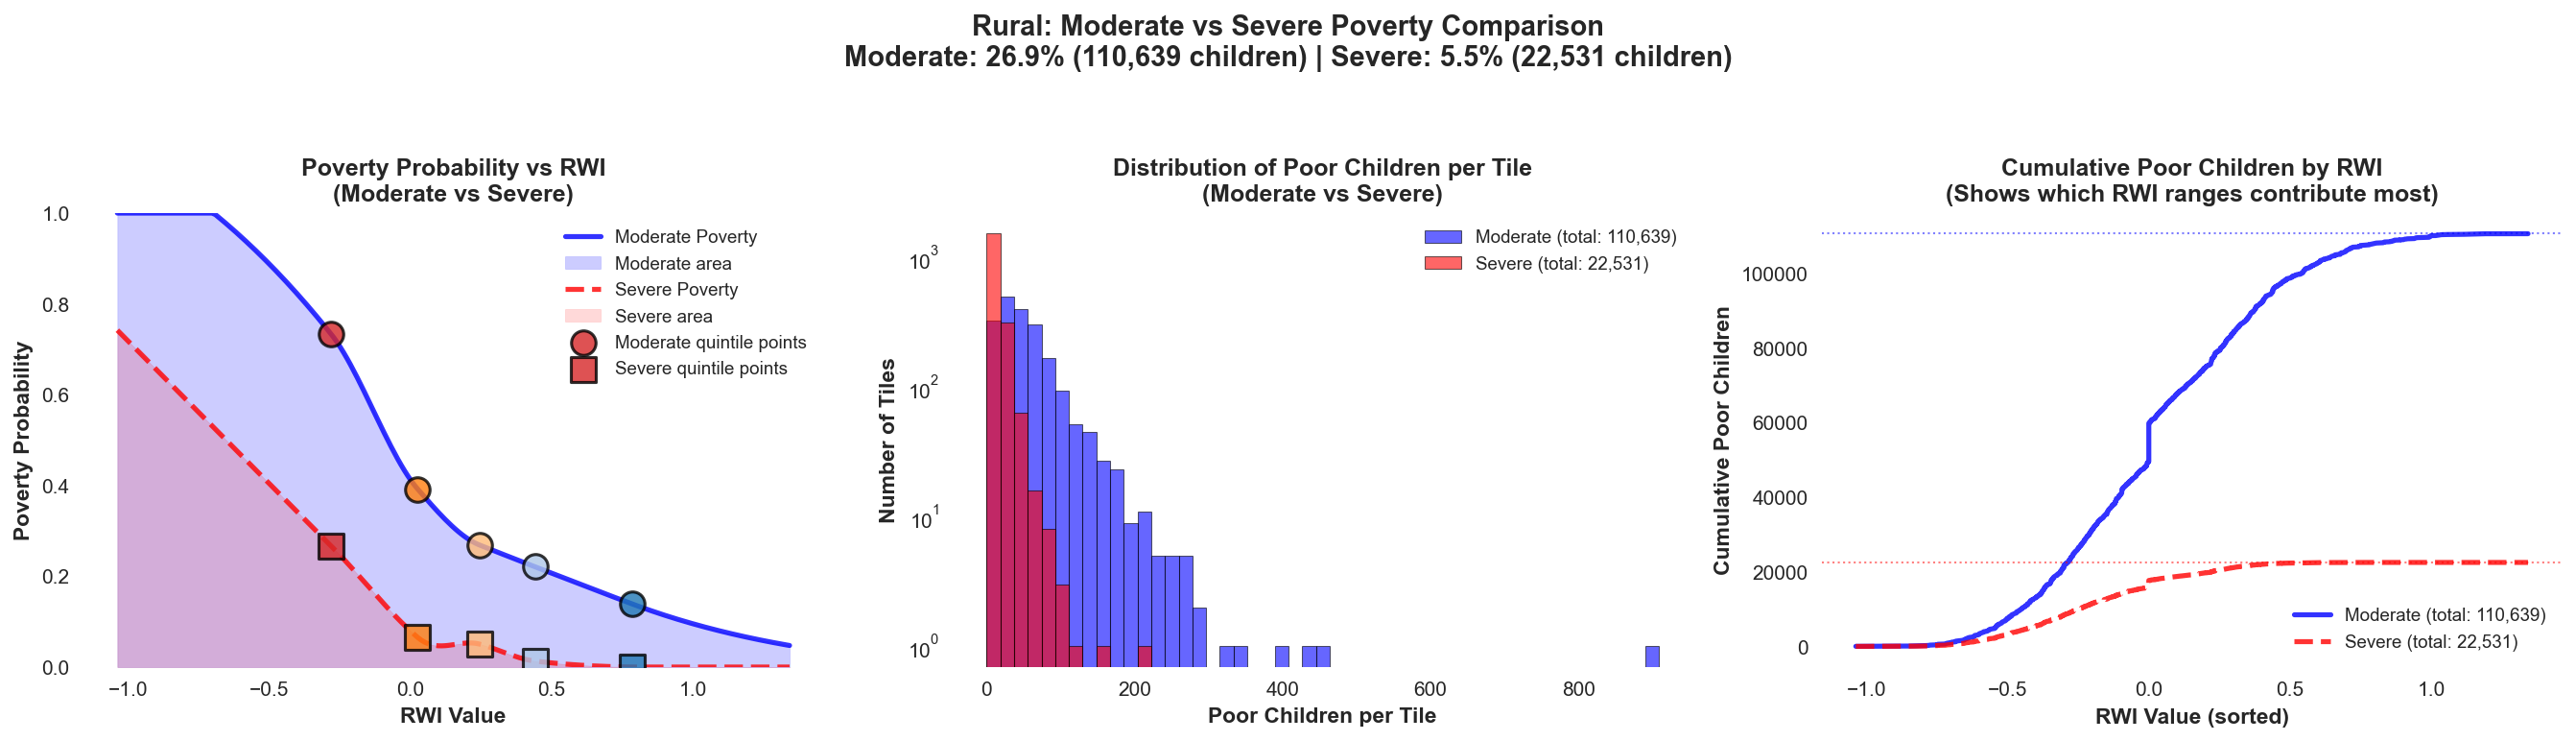

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/urban_moderate_vs_severe_poverty_comparison_moderate_217_53843_children__severe_.png


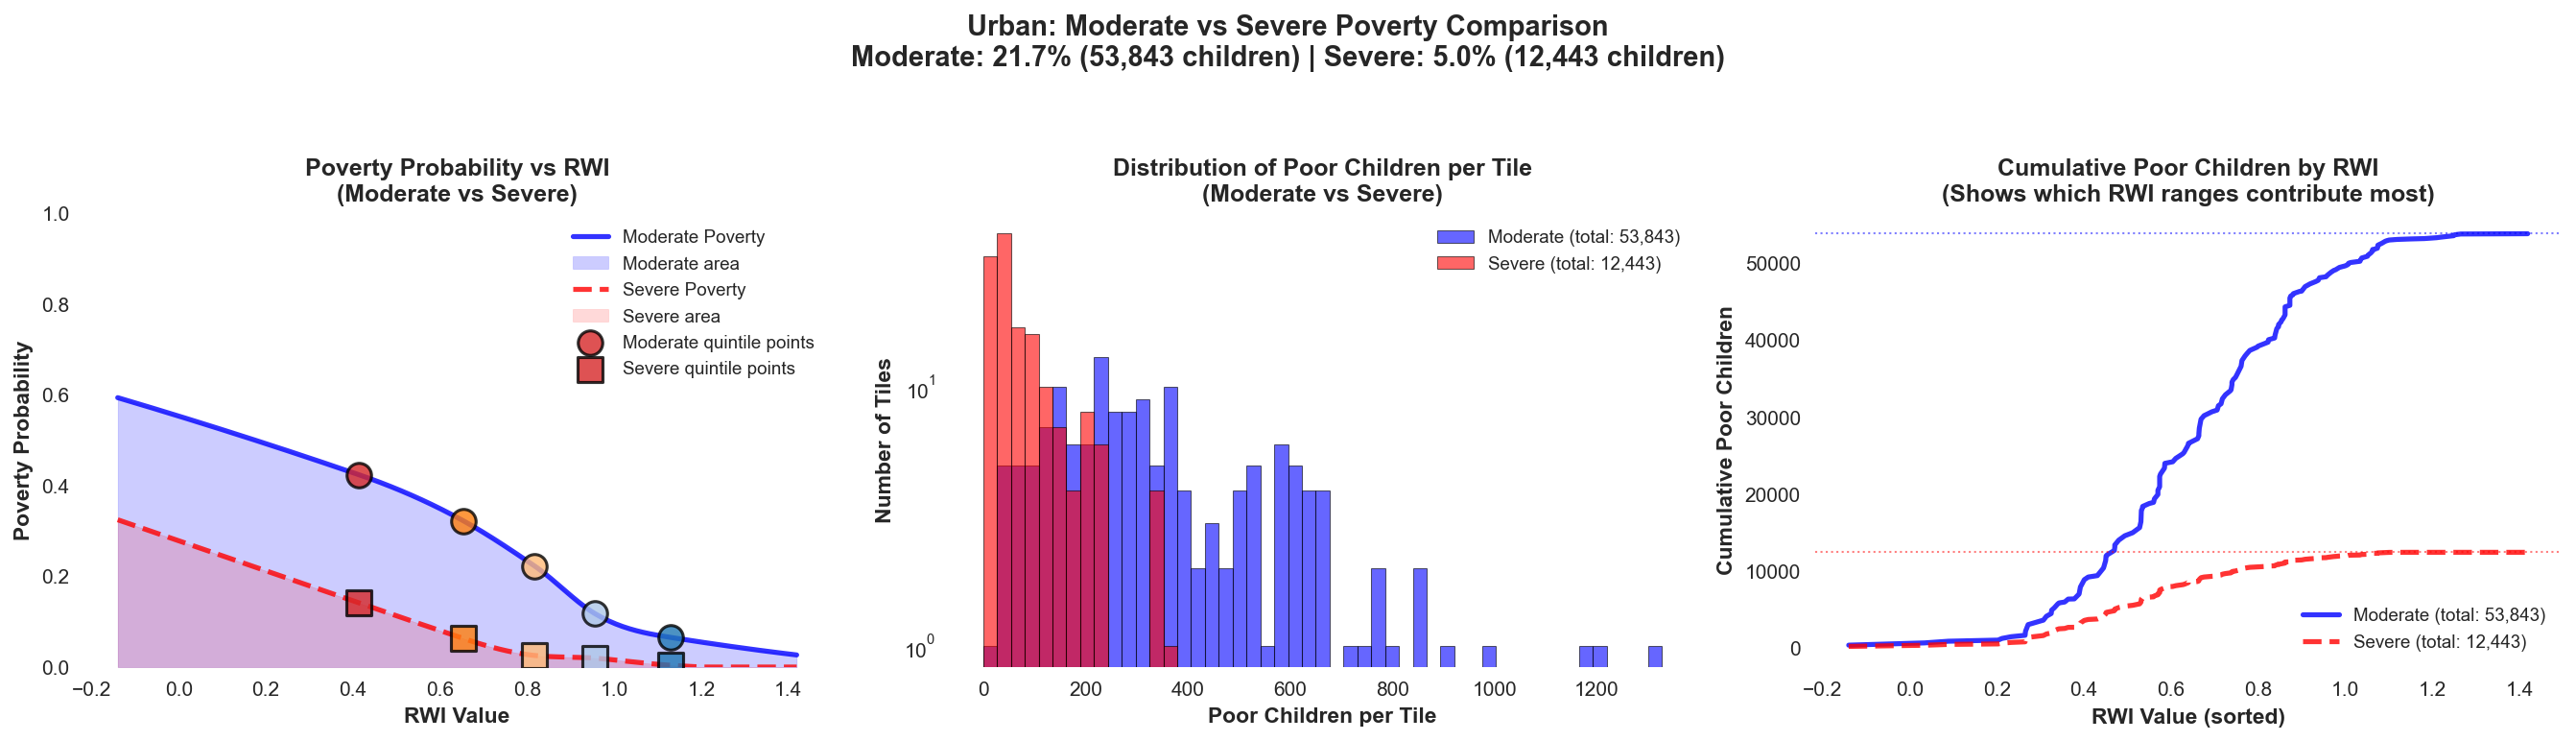

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/kma_moderate_vs_severe_poverty_comparison_moderate_334_62051_children__severe_64.png


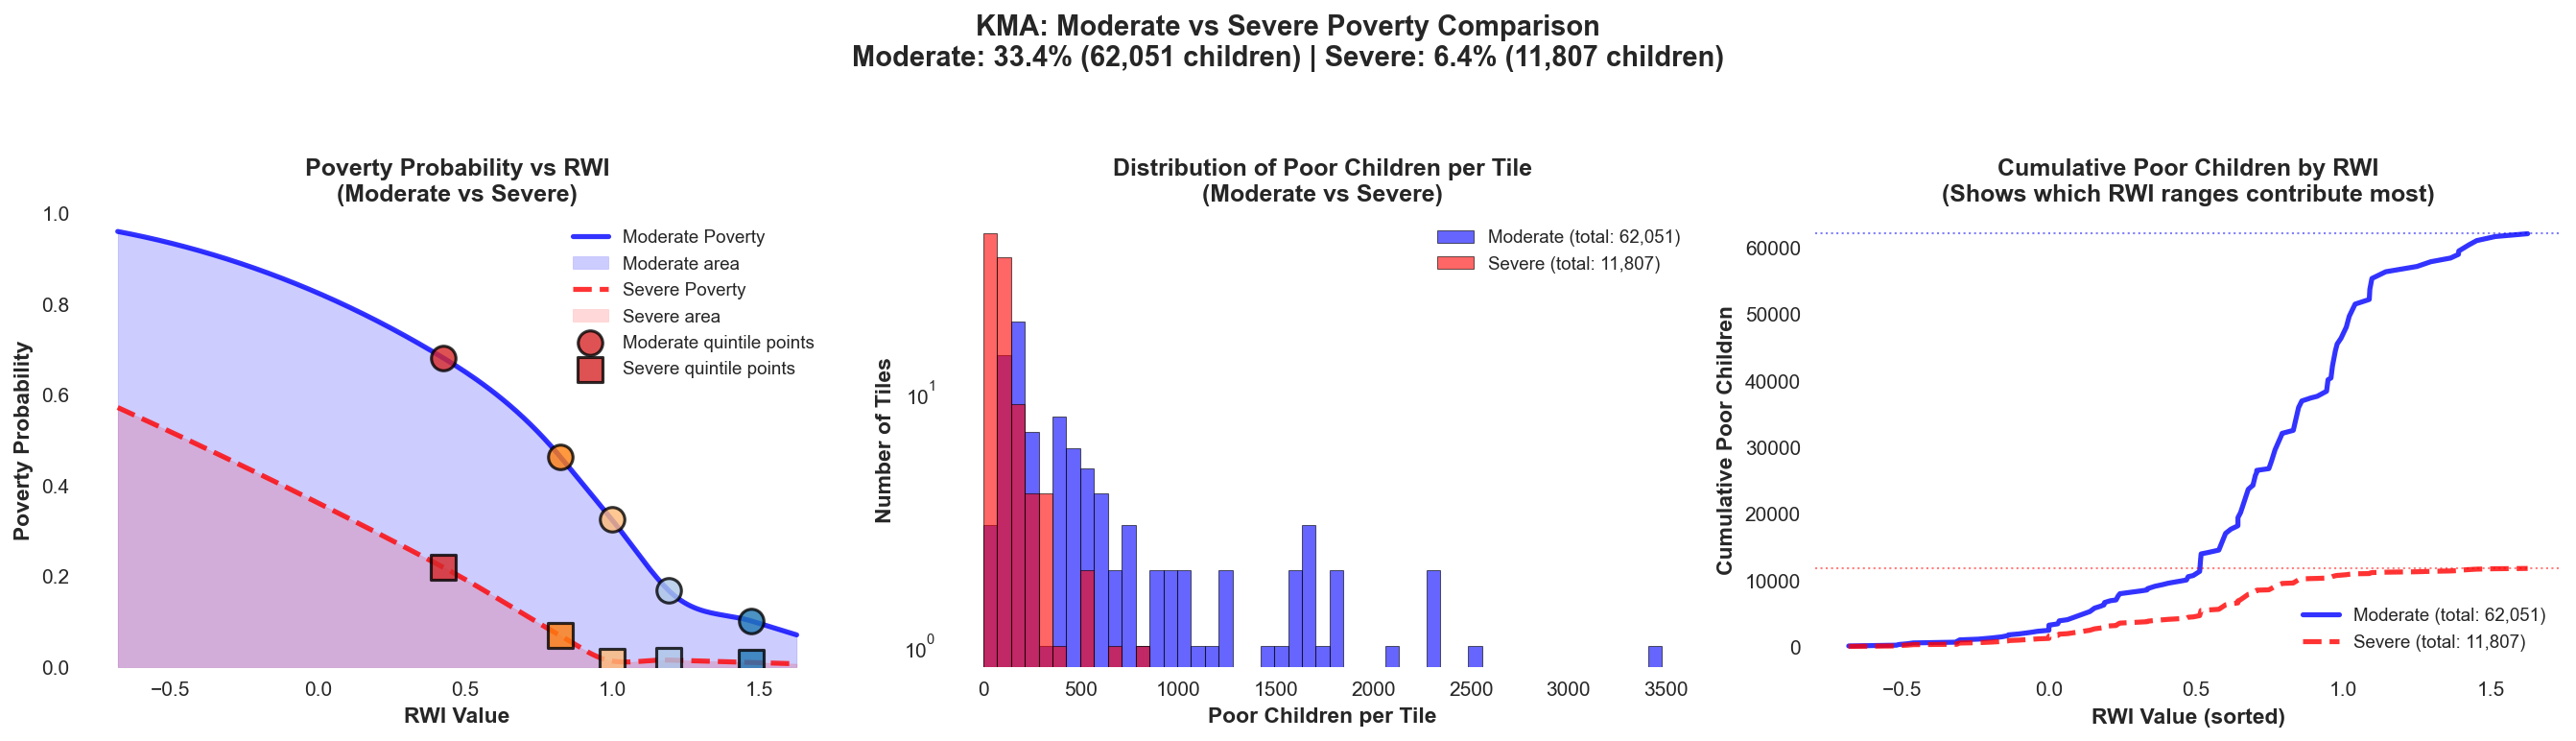

In [11]:
# Color scheme for quintiles
quintile_colors = {
    1: '#d62728',  # Red - Poorest
    2: '#ff7f0e',  # Orange
    3: '#ffbb78',  # Light Orange
    4: '#aec7e8',  # Light Blue
    5: '#1f77b4'   # Blue - Richest
}

# Plot moderate vs severe poverty for each region
for region in ['Rural', 'Urban', 'KMA']:
    if region not in all_results.get('moderate', {}) or region not in all_results.get('severe', {}):
        continue
    
    mask = gdf_tiles_with_admin['area_classification'] == region
    df_region = gdf_tiles_with_admin[mask].copy()
    
    if len(df_region) == 0:
        continue
    
    # Get quintile points
    region_quintile_points_moderate = df_quintile_points_moderate[df_quintile_points_moderate['classification'] == region]
    region_quintile_points_severe = df_quintile_points_severe[df_quintile_points_severe['classification'] == region]
    
    # Get moderate and severe results
    moderate_result = all_results['moderate'][region]
    severe_result = all_results['severe'][region]
    
    # Get poverty probabilities for all tiles in this region
    rwi_values = df_region['rwi'].values
    moderate_poverty_prob = moderate_result['predict_func'](rwi_values, moderate_result['params'])
    severe_poverty_prob = severe_result['predict_func'](rwi_values, severe_result['params'])
    
    # Calculate poor children
    children_pop = df_region['children_population'].values
    moderate_poor_children = moderate_poverty_prob * children_pop
    severe_poor_children = severe_poverty_prob * children_pop
    
    total_moderate = moderate_poor_children.sum()
    total_severe = severe_poor_children.sum()
    moderate_pct = (total_moderate / children_pop.sum() * 100) if children_pop.sum() > 0 else 0
    severe_pct = (total_severe / children_pop.sum() * 100) if children_pop.sum() > 0 else 0
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Extend RWI range to show boundary conditions
    rwi_min_plot = max(df_region['rwi'].min(), RWI_MIN - 0.2)
    rwi_max_plot = min(df_region['rwi'].max(), RWI_MAX + 0.2)
    rwi_range = np.linspace(rwi_min_plot, rwi_max_plot, 200)
    

    # Plot 1: Poverty Probability vs RWI (Moderate vs Severe)
    ax1 = axes[0]
    
    # Moderate poverty
    moderate_base = predict_akima(rwi_range, moderate_result['params'])
    moderate_scale_factor = moderate_result['scale_factor']
    moderate_predictions_scaled = np.clip(moderate_base * moderate_scale_factor, 0, 1)
    
    # Severe poverty
    severe_base = predict_akima(rwi_range, severe_result['params'])
    severe_scale_factor = severe_result['scale_factor']
    severe_predictions_scaled = np.clip(severe_base * severe_scale_factor, 0, 1)
    
    # Plot scaled curves
    ax1.plot(rwi_range, moderate_predictions_scaled, 'b-', linewidth=2.5, label='Moderate Poverty', alpha=0.8)
    ax1.fill_between(rwi_range, 0, moderate_predictions_scaled, alpha=0.2, color='blue', label='Moderate area')
    ax1.plot(rwi_range, severe_predictions_scaled, 'r--', linewidth=2.5, label='Severe Poverty', alpha=0.8)
    ax1.fill_between(rwi_range, 0, severe_predictions_scaled, alpha=0.15, color='red', label='Severe area')
    
    # Plot quintile points
    for _, row in region_quintile_points_moderate.iterrows():
        q = int(row['quintile'])
        rwi_avg = row['weighted_avg_rwi']
        
        # Scaled predicted point
        predicted_rate = predict_akima(np.array([rwi_avg]), moderate_result['params'])[0]
        predicted_rate_scaled = np.clip(predicted_rate * moderate_scale_factor, 0, 1)
        ax1.scatter(rwi_avg, predicted_rate_scaled, s=150, marker='o', 
                   color=quintile_colors[q], edgecolor='black', linewidth=1.5, 
                   zorder=5, alpha=0.8, label='Moderate quintile points' if q == 1 else '')
    
    for _, row in region_quintile_points_severe.iterrows():
        q = int(row['quintile'])
        rwi_avg = row['weighted_avg_rwi']
        
        # Scaled predicted point
        predicted_rate = predict_akima(np.array([rwi_avg]), severe_result['params'])[0]
        predicted_rate_scaled = np.clip(predicted_rate * severe_scale_factor, 0, 1)
        ax1.scatter(rwi_avg, predicted_rate_scaled, s=150, marker='s', 
                   color=quintile_colors[q], edgecolor='black', linewidth=1.5, 
                   zorder=5, alpha=0.8, label='Severe quintile points' if q == 1 else '')
    
    ax1.set_xlabel('RWI Value', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Poverty Probability', fontsize=11, fontweight='bold')
    ax1.set_title('Poverty Probability vs RWI\n(Moderate vs Severe)', fontsize=12, fontweight='bold')
    ax1.set_ylim([0, 1])
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=9, loc='upper right')
    

    # Plot 2: Distribution of Poor Children per Tile (Moderate vs Severe)
    ax2 = axes[1]
    
    # Filter out zeros for better visualization
    moderate_nonzero = moderate_poor_children[moderate_poor_children > 0]
    severe_nonzero = severe_poor_children[severe_poor_children > 0]
    
    # Use log scale for y-axis
    max_val = max(max(moderate_nonzero) if len(moderate_nonzero) > 0 else 0, 
                 max(severe_nonzero) if len(severe_nonzero) > 0 else 0)
    bins = np.linspace(0, max_val, 50) if max_val > 0 else np.linspace(0, 100, 50)
    
    ax2.hist(moderate_nonzero, bins=bins, alpha=0.6, color='blue', edgecolor='black', linewidth=0.5,
            label=f'Moderate (total: {total_moderate:,.0f})')
    ax2.hist(severe_nonzero, bins=bins, alpha=0.6, color='red', edgecolor='black', linewidth=0.5,
            label=f'Severe (total: {total_severe:,.0f})')
    
    ax2.set_xlabel('Poor Children per Tile', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Number of Tiles', fontsize=11, fontweight='bold')
    ax2.set_title('Distribution of Poor Children per Tile\n(Moderate vs Severe)', fontsize=12, fontweight='bold')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend(fontsize=9)
    
    
    # Plot 3: Cumulative Poor Children by RWI
    ax3 = axes[2]
    
    # Sort by RWI for cumulative plot
    df_sorted = df_region.copy()
    df_sorted['moderate_poor'] = moderate_poor_children
    df_sorted['severe_poor'] = severe_poor_children
    df_sorted = df_sorted.sort_values('rwi').reset_index(drop=True)
    
    # Calculate cumulative sums
    cumulative_moderate = df_sorted['moderate_poor'].cumsum()
    cumulative_severe = df_sorted['severe_poor'].cumsum()
    
    ax3.plot(df_sorted['rwi'].values, cumulative_moderate, 'b-', linewidth=2.5, 
            label=f'Moderate (total: {total_moderate:,.0f})', alpha=0.8)
    ax3.plot(df_sorted['rwi'].values, cumulative_severe, 'r--', linewidth=2.5, 
            label=f'Severe (total: {total_severe:,.0f})', alpha=0.8)
    
    # Add horizontal lines for totals
    ax3.axhline(y=total_moderate, color='blue', linestyle=':', linewidth=1, alpha=0.5)
    ax3.axhline(y=total_severe, color='red', linestyle=':', linewidth=1, alpha=0.5)
    
    ax3.set_xlabel('RWI Value (sorted)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Cumulative Poor Children', fontsize=11, fontweight='bold')
    ax3.set_title('Cumulative Poor Children by RWI\n(Shows which RWI ranges contribute most)', 
                 fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=9)
    
    # Add summary text at the top
    summary_text = f"Moderate: {moderate_pct:.1f}% ({total_moderate:,.0f} children) | Severe: {severe_pct:.1f}% ({total_severe:,.0f} children)"
    plt.suptitle(f'{region}: Moderate vs Severe Poverty Comparison\n{summary_text}',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    plt.show()

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/wind-dependent_poverty_calculation_key_components.png


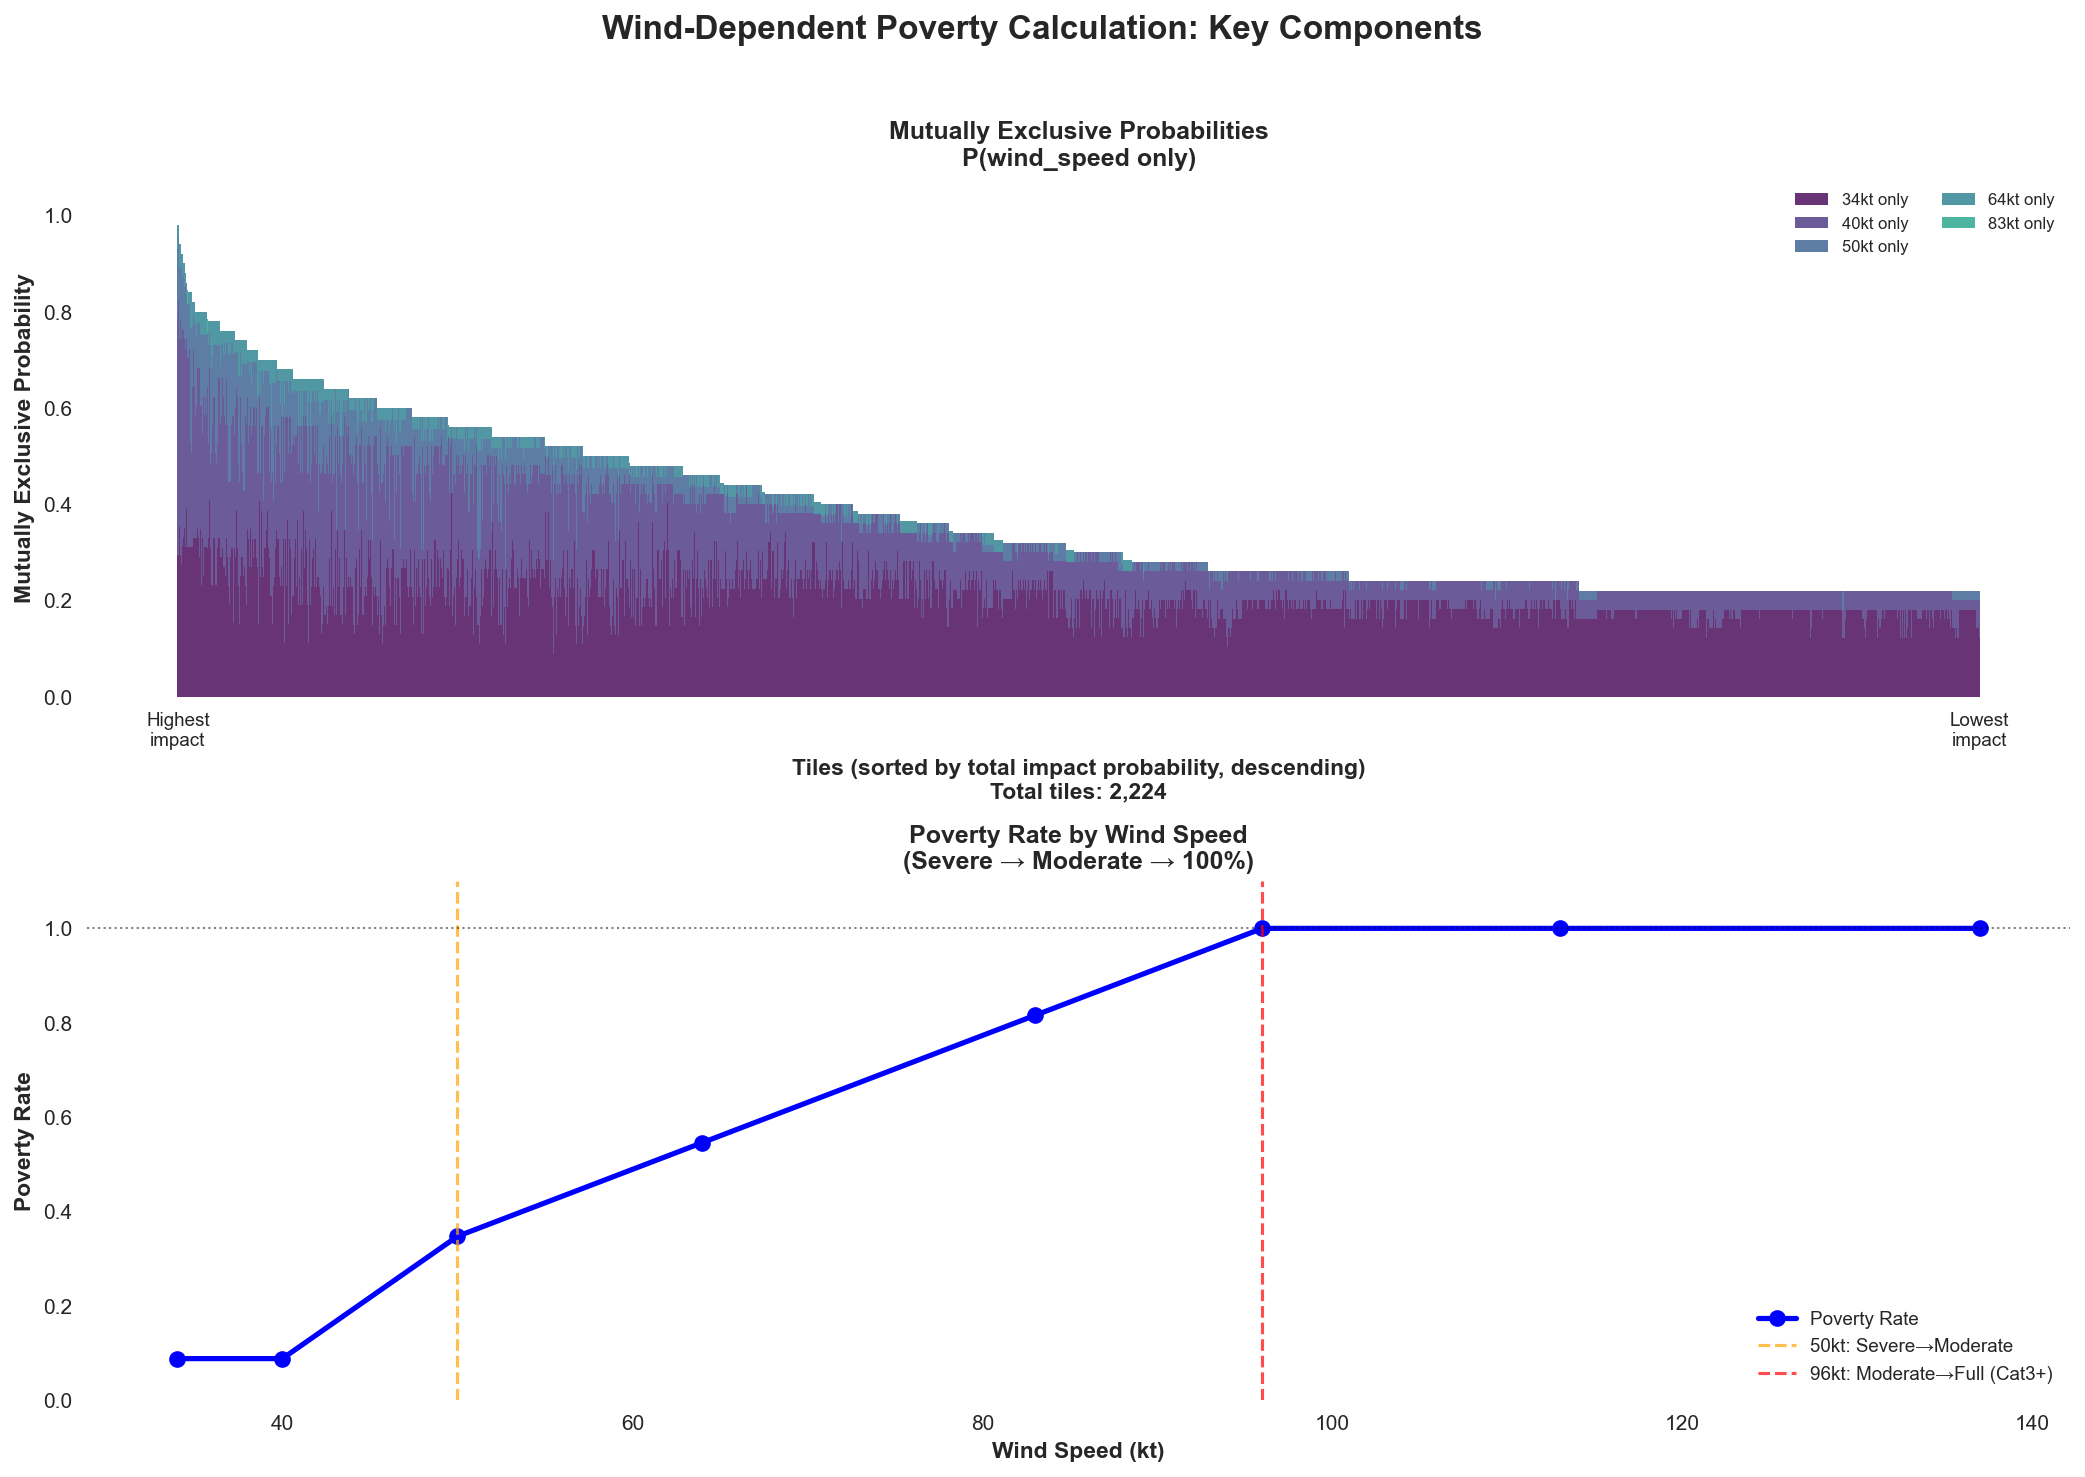

In [12]:
# Visualization: Mutually Exclusive Probabilities and Poverty Rate by Wind Speed
all_tiles = gdf_tiles_final.copy()
threshold_ints = sorted(WIND_THRESHOLDS_DICT.keys())

# Create a clean 2-panel visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Wind-Dependent Poverty Calculation: Key Components', 
             fontsize=16, fontweight='bold', y=0.98)

# 1. Mutually Exclusive Probabilities (Stacked)
ax1 = axes[0]
prob_only_cols = [f'prob_{kt}kt_only' for kt in threshold_ints]

if all([col in all_tiles.columns for col in prob_only_cols]):
    # Calculate total wind exposure for each tile
    total_wind = all_tiles[prob_only_cols].sum(axis=1)
    
    # Sort tiles by total impact probability (descending)
    all_tiles_sorted_stacked = all_tiles.copy()
    all_tiles_sorted_stacked['total_wind_exposure'] = total_wind
    all_tiles_sorted_stacked = all_tiles_sorted_stacked.sort_values('total_wind_exposure', ascending=False).reset_index(drop=True)
    
    # Colors for each threshold
    colors_list = plt.cm.viridis(np.linspace(0, 1, len(threshold_ints)))
    color_map = {kt: color for kt, color in zip(threshold_ints, colors_list)}
    
    # Create stacked bars for all tiles
    x_positions = np.arange(len(all_tiles_sorted_stacked))
    width = 1.0
    bottoms = np.zeros(len(all_tiles_sorted_stacked))
    bars_list = []
    
    for kt, col in zip(threshold_ints, prob_only_cols):
        probs = all_tiles_sorted_stacked[col].fillna(0.0).values
        if probs.sum() > 0:
            bars = ax1.bar(x_positions, probs, width, bottom=bottoms, 
                          color=color_map[kt], alpha=0.8, edgecolor='none', linewidth=0,
                          label=f'{kt}kt only')
            bars_list.append((kt, bars))
            bottoms += probs
    
    ax1.set_xlabel(f'Tiles (sorted by total impact probability, descending)\nTotal tiles: {len(all_tiles_sorted_stacked):,}', 
                  fontsize=11, fontweight='bold')
    ax1.set_ylabel('Mutually Exclusive Probability', fontsize=11, fontweight='bold')
    ax1.set_title('Mutually Exclusive Probabilities\nP(wind_speed only)', 
                 fontsize=12, fontweight='bold')
    ax1.set_xticks([0, len(all_tiles_sorted_stacked)-1])
    ax1.set_xticklabels(['Highest\nimpact', 'Lowest\nimpact'], fontsize=9)
    ax1.set_ylim([0, max(bottoms) * 1.1 if len(bottoms) > 0 else 1.0])
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.legend([bars for _, bars in bars_list], [f'{kt}kt only' for kt, _ in bars_list], 
              fontsize=8, loc='upper right', ncol=2)

# 2. Poverty Rate by Wind Speed
ax2 = axes[1]
wind_speeds_demo = np.array([34, 40, 50, 64, 83, 96, 113, 137])
poverty_rates_by_wind = []

for ws in wind_speeds_demo:
    if ws < SEVERE_TO_MODERATE_THRESHOLD:
        # Use severe poverty (average across all tiles)
        poverty_rate = all_tiles['poverty_prob_severe'].mean()
    elif ws < MODERATE_TO_FULL_THRESHOLD:
        # Interpolate between moderate and 100%
        interp_factor = (ws - SEVERE_TO_MODERATE_THRESHOLD) / (MODERATE_TO_FULL_THRESHOLD - SEVERE_TO_MODERATE_THRESHOLD)
        moderate_rate = all_tiles['poverty_prob_moderate'].mean()
        poverty_rate = moderate_rate * (1 - interp_factor) + 1.0 * interp_factor
    else:
        # 100% poverty
        poverty_rate = 1.0
    poverty_rates_by_wind.append(poverty_rate)

ax2.plot(wind_speeds_demo, poverty_rates_by_wind, 'b-o', linewidth=2.5, markersize=8, label='Poverty Rate')
ax2.axvline(x=SEVERE_TO_MODERATE_THRESHOLD, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='50kt: Severe→Moderate')
ax2.axvline(x=MODERATE_TO_FULL_THRESHOLD, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='96kt: Moderate→Full (Cat3+)')
ax2.axhline(y=1.0, color='black', linestyle=':', linewidth=1, alpha=0.5)
ax2.set_xlabel('Wind Speed (kt)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Poverty Rate', fontsize=11, fontweight='bold')
ax2.set_title('Poverty Rate by Wind Speed\n(Severe → Moderate → 100%)', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 1.1])
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=9, loc='lower right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/poverty_rates_comparison_by_region.png


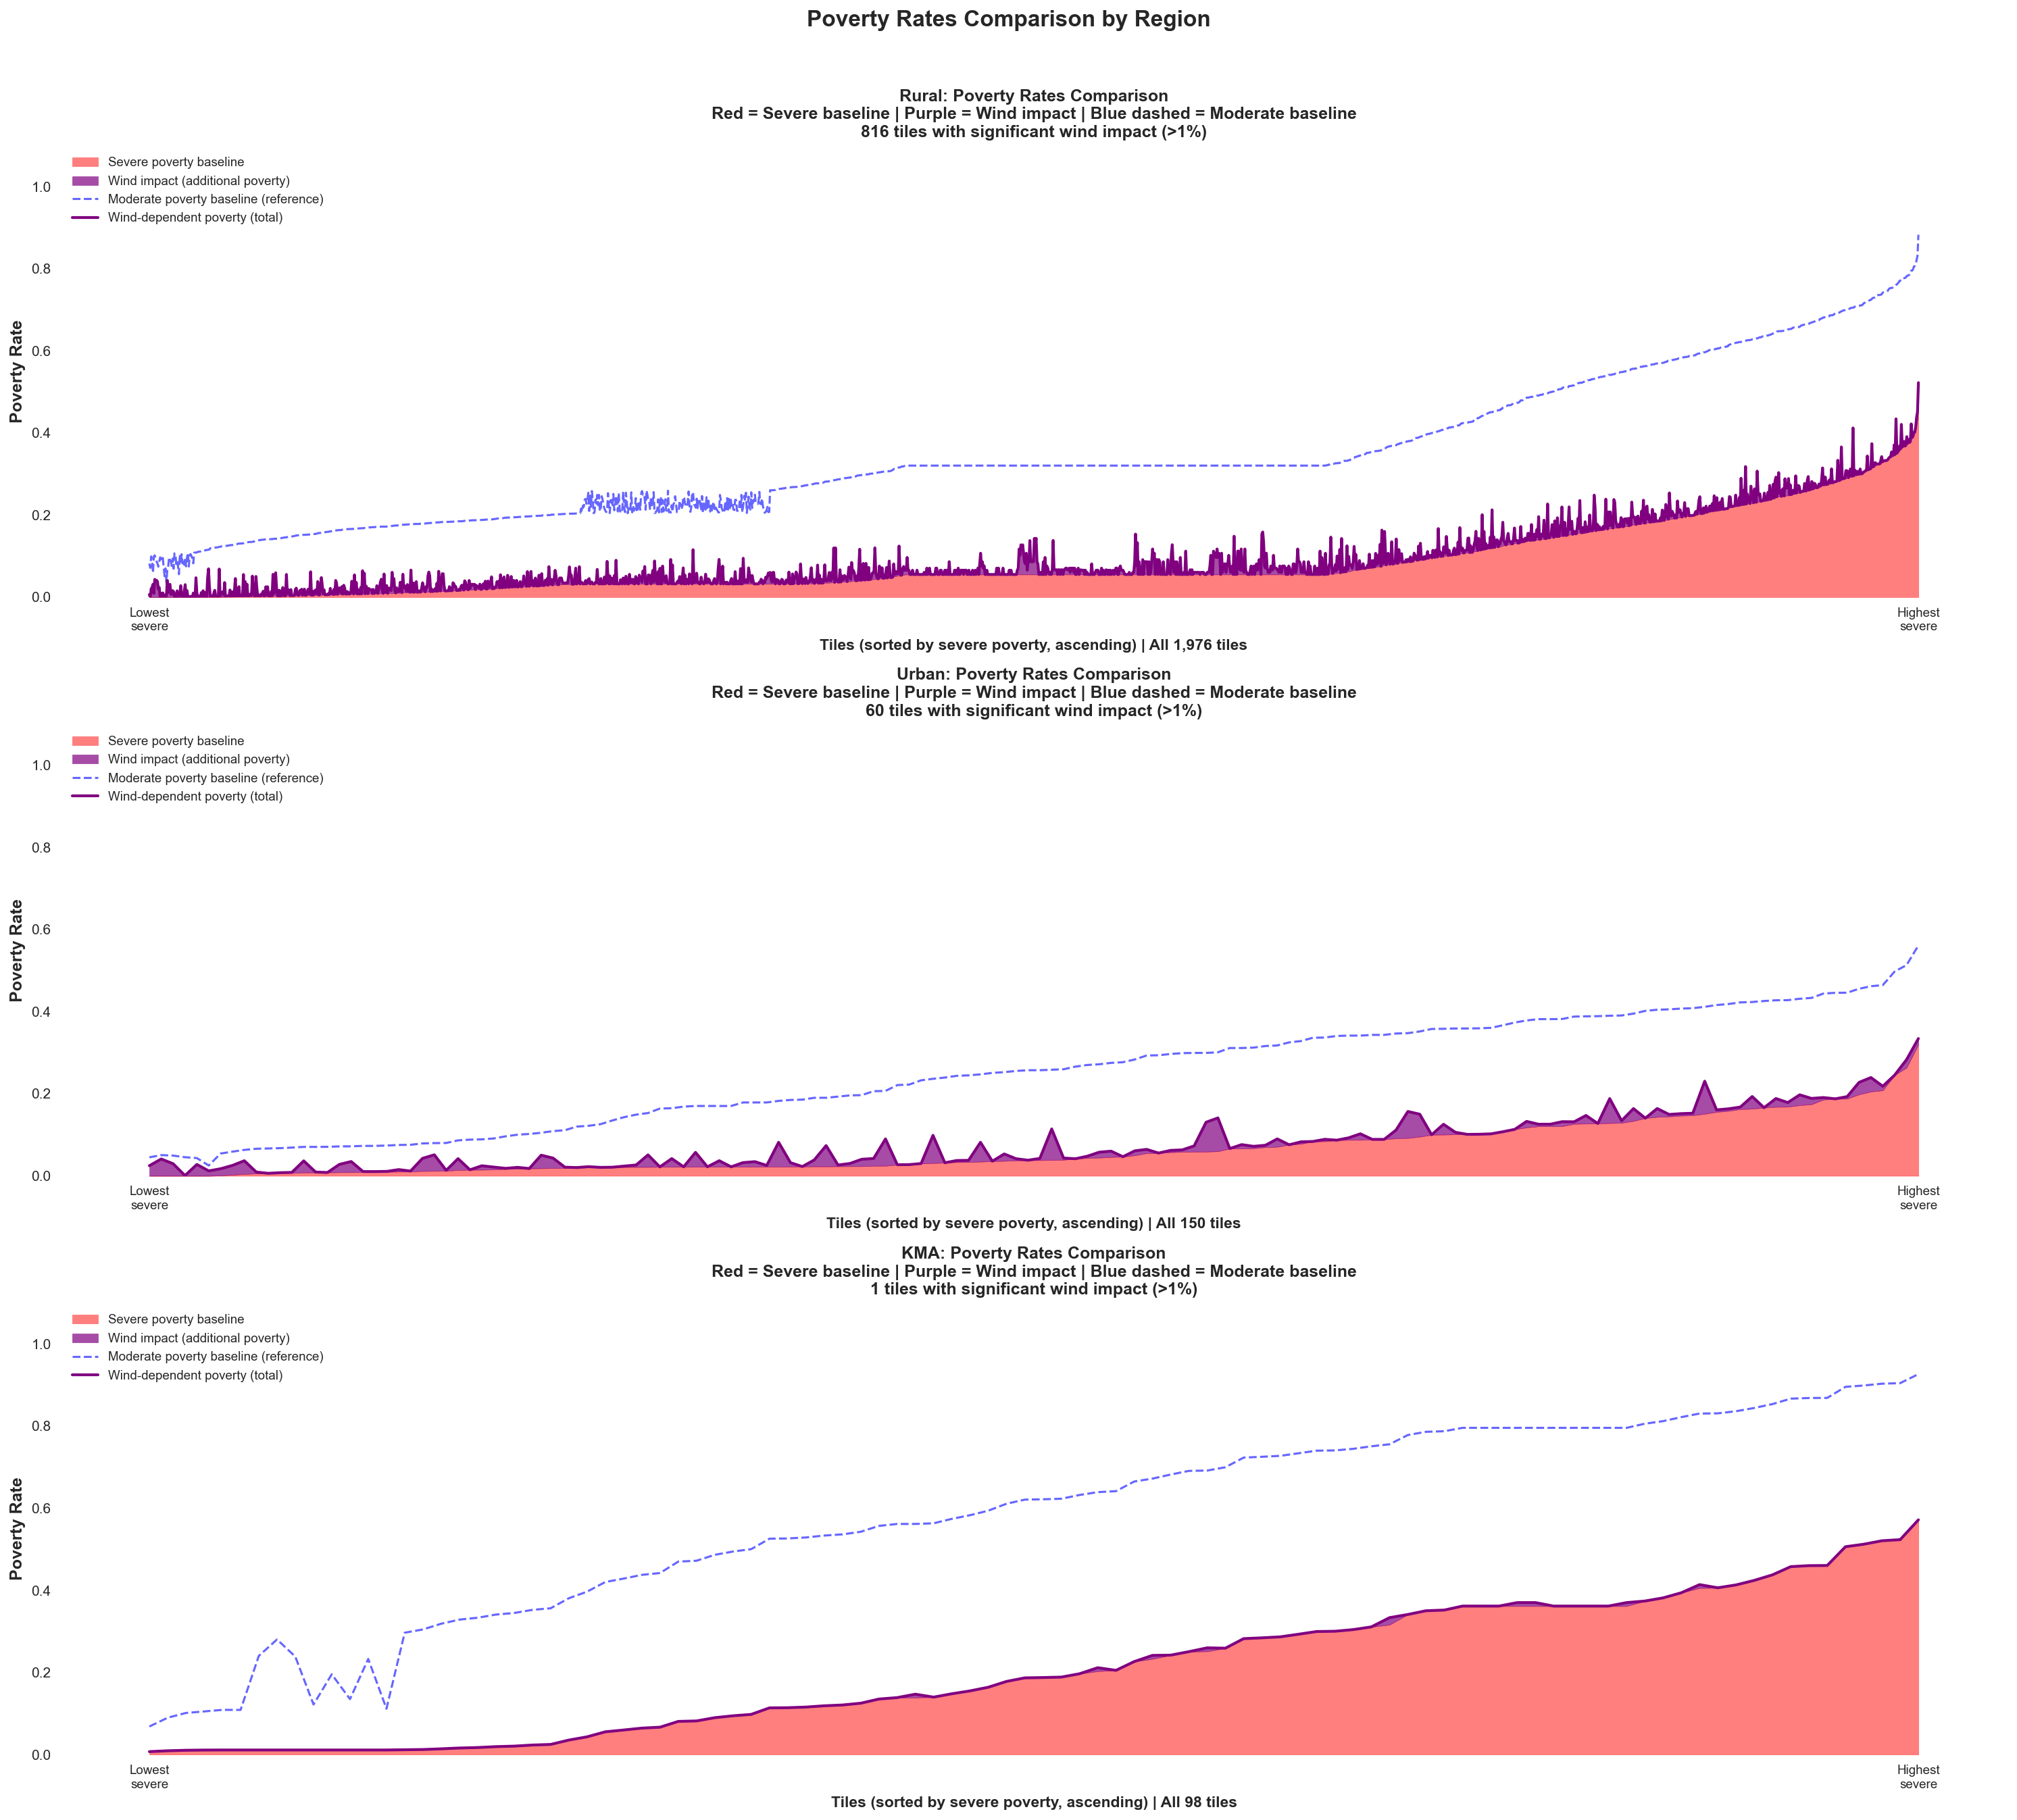

In [13]:
# Create poverty rates comparison visualization for each region
# This shows: Severe baseline, Wind impact, Moderate baseline, and Wind-dependent poverty

if 'area_classification' in gdf_tiles_final.columns:
    regions = ['Rural', 'Urban', 'KMA']
    
    # Create a figure with 3 subplots (one for each region)
    fig, axes = plt.subplots(3, 1, figsize=(20, 18))
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    
    for region_idx, region in enumerate(regions):
        ax_region = axes[region_idx]
        
        # Filter tiles for this region
        region_mask = gdf_tiles_final['area_classification'] == region
        region_tiles = gdf_tiles_final[region_mask].copy()
        
        if len(region_tiles) == 0:
            ax_region.text(0.5, 0.5, f'No tiles found for {region}', 
                    ha='center', va='center', fontsize=14, fontweight='bold',
                    transform=ax_region.transAxes)
            ax_region.set_title(f'{region}: Poverty Rates Comparison - No Data', fontsize=12, fontweight='bold')
            continue
        
        # Get data for this region
        region_severe = region_tiles['poverty_prob_severe'].values
        region_moderate = region_tiles['poverty_prob_moderate'].values
        region_wind_dep = region_tiles['poverty_prob_wind_dependent'].values
        region_wind_impact = region_wind_dep - region_severe
        
        # Sort by severe poverty for better visualization
        sort_idx = np.argsort(region_severe)
        severe_sorted = region_severe[sort_idx]
        wind_dep_sorted = region_wind_dep[sort_idx]
        wind_impact_sorted = region_wind_impact[sort_idx]
        moderate_sorted = region_moderate[sort_idx]
        
        x_positions = np.arange(len(severe_sorted))
        
        # Plot all tiles (not sampled)
        x_all = x_positions
        severe_all = severe_sorted
        wind_dep_all = wind_dep_sorted
        wind_impact_all = wind_impact_sorted
        moderate_all = moderate_sorted
        
        # Plot severe baseline as filled area
        ax_region.fill_between(x_all, 0, severe_all, alpha=0.5, color='red', 
                        label='Severe poverty baseline', zorder=1)
        
        # Plot wind impact stacked on top (only where positive)
        wind_impact_positive = np.maximum(0, wind_impact_all)
        ax_region.fill_between(x_all, severe_all, severe_all + wind_impact_positive, 
                        alpha=0.7, color='purple', 
                        label='Wind impact (additional poverty)', zorder=3)
        
        # Add moderate baseline as reference line
        ax_region.plot(x_all, moderate_all, color='blue', linewidth=1.5, alpha=0.6, 
                 linestyle='--', label='Moderate poverty baseline (reference)', zorder=2)
        
        # Add wind-dependent line on top
        ax_region.plot(x_all, wind_dep_all, color='purple', linewidth=2, alpha=1.0, 
                 label='Wind-dependent poverty (total)', zorder=4)
        
        ax_region.set_xlabel(f'Tiles (sorted by severe poverty, ascending) | All {len(severe_sorted):,} tiles', 
                      fontsize=11, fontweight='bold')
        ax_region.set_ylabel('Poverty Rate', fontsize=12, fontweight='bold')
        ax_region.set_title(f'{region}: Poverty Rates Comparison\n' +
                     f'Red = Severe baseline | Purple = Wind impact | Blue dashed = Moderate baseline\n' +
                     f'{np.sum(region_wind_impact > 0.01):,} tiles with significant wind impact (>1%)', 
                     fontsize=12, fontweight='bold')
        ax_region.set_xticks([0, len(severe_sorted)-1])
        ax_region.set_xticklabels(['Lowest\nsevere', 'Highest\nsevere'], fontsize=9)
        ax_region.set_ylim([0, 1.1])
        ax_region.grid(True, alpha=0.3, axis='y')
        ax_region.legend(fontsize=9, loc='upper left', framealpha=0.9)
    
    plt.suptitle('Poverty Rates Comparison by Region', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
else:
    print("Warning: 'area_classification' column not found in gdf_tiles_final")

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/rural_wind-speed_dependent_poverty_by_quintile.png


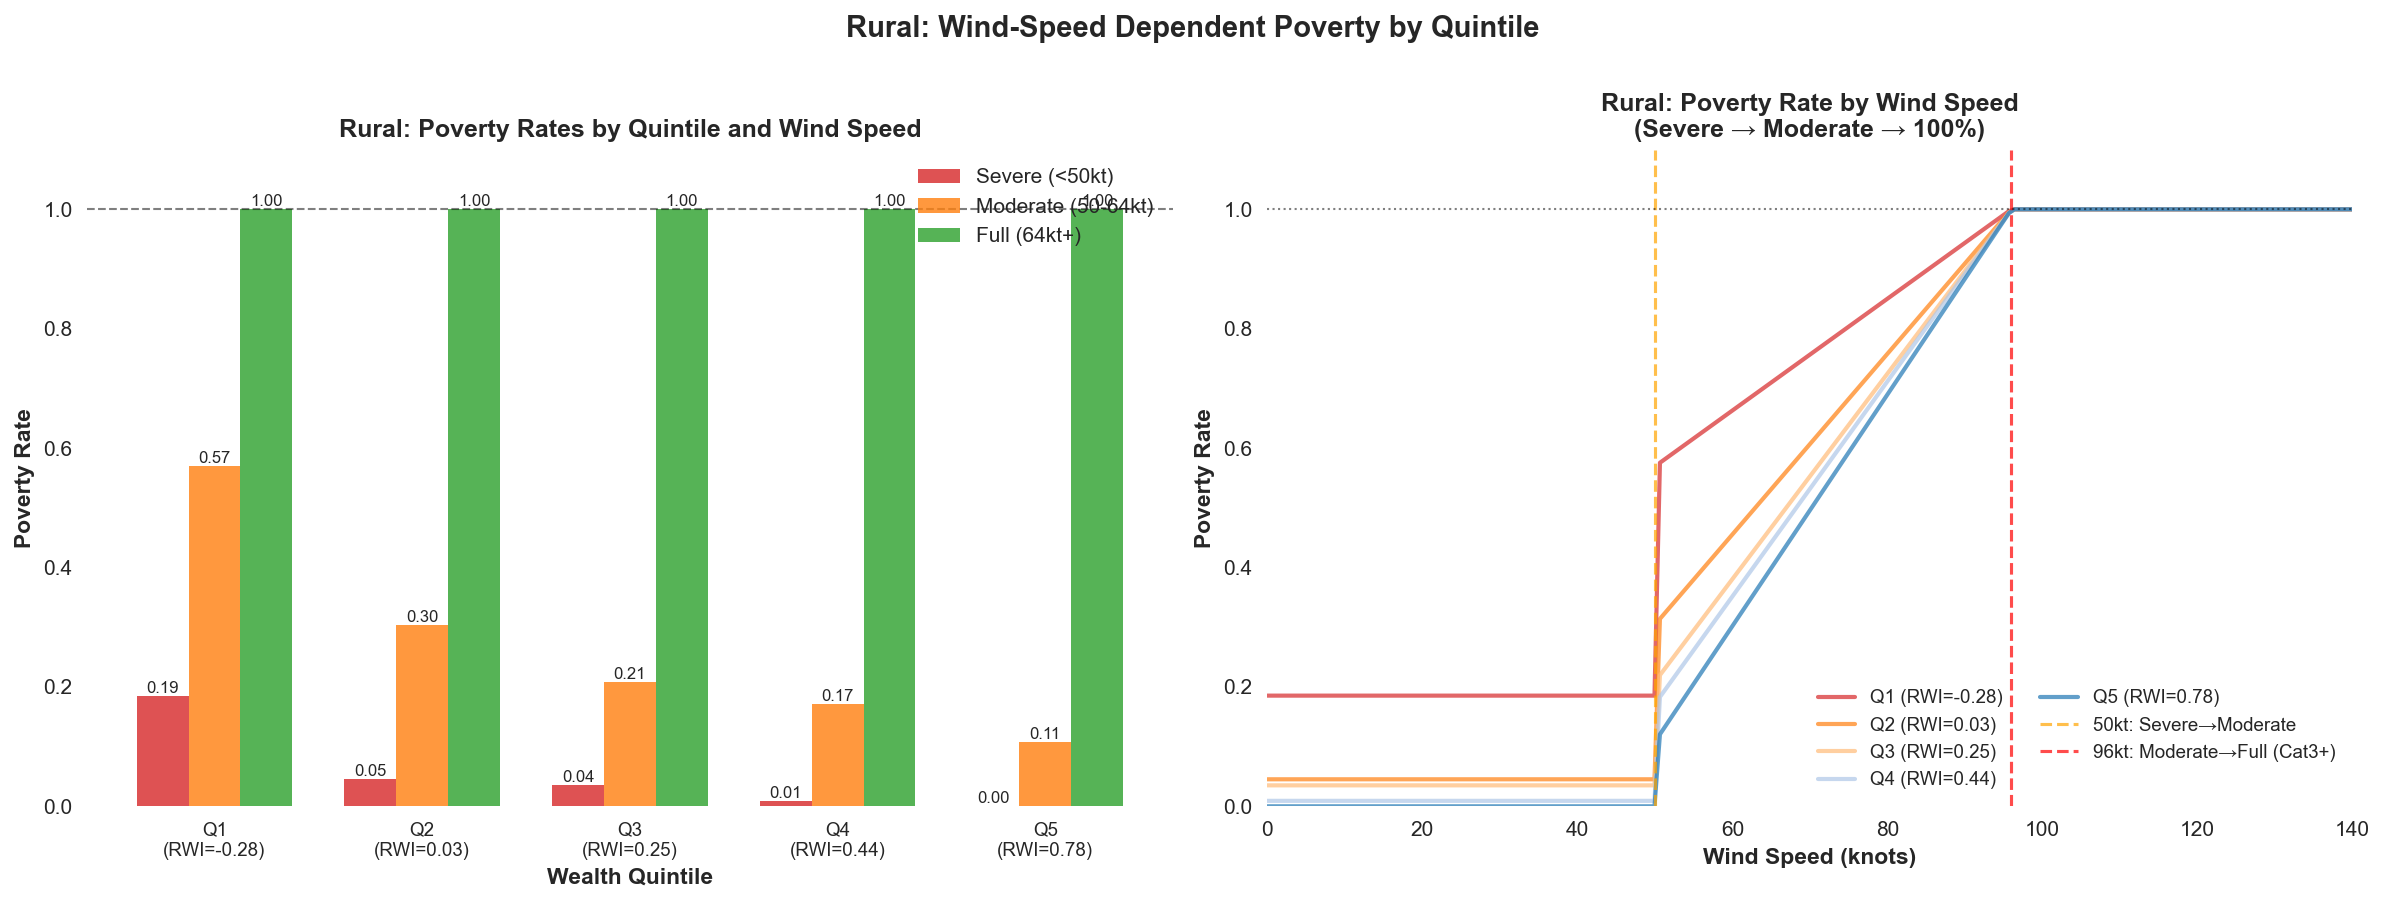

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/urban_wind-speed_dependent_poverty_by_quintile.png


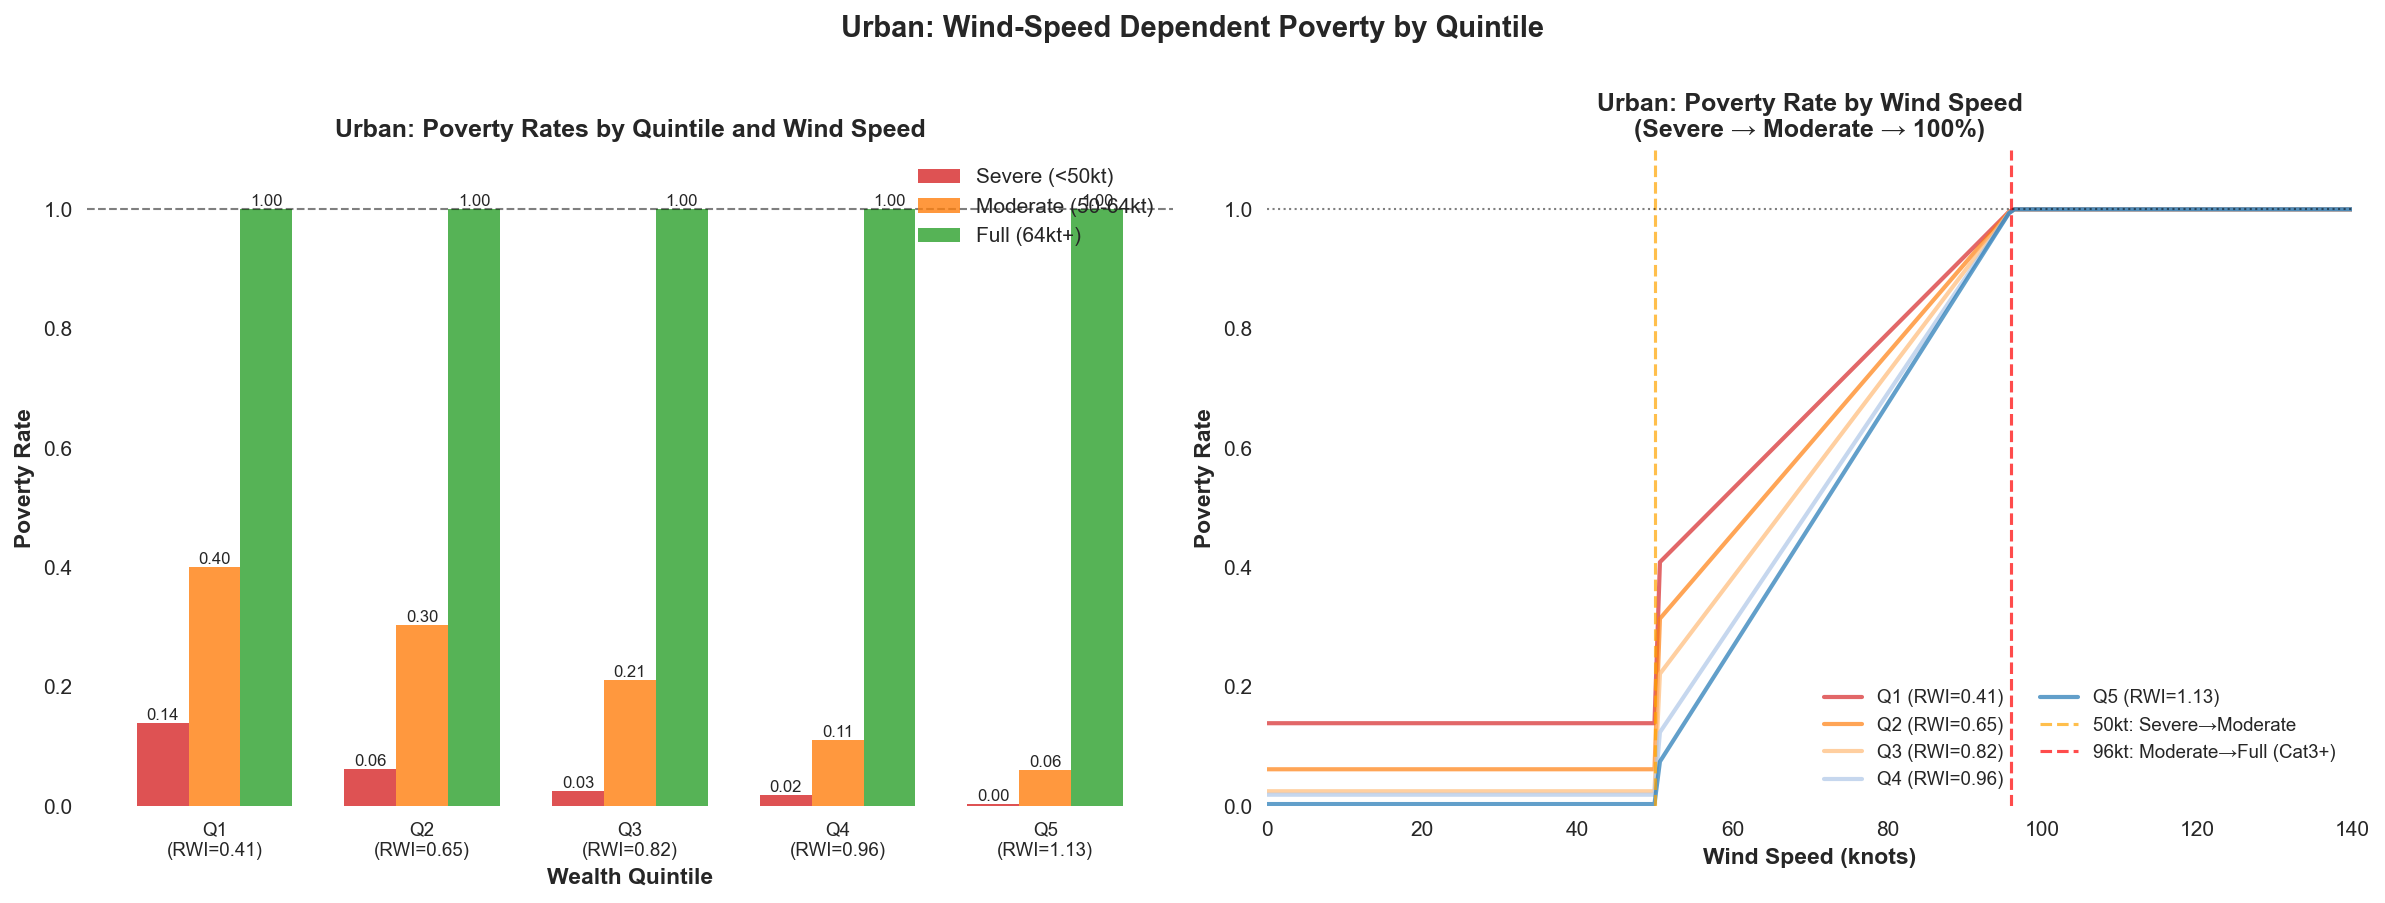

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/kma_wind-speed_dependent_poverty_by_quintile.png


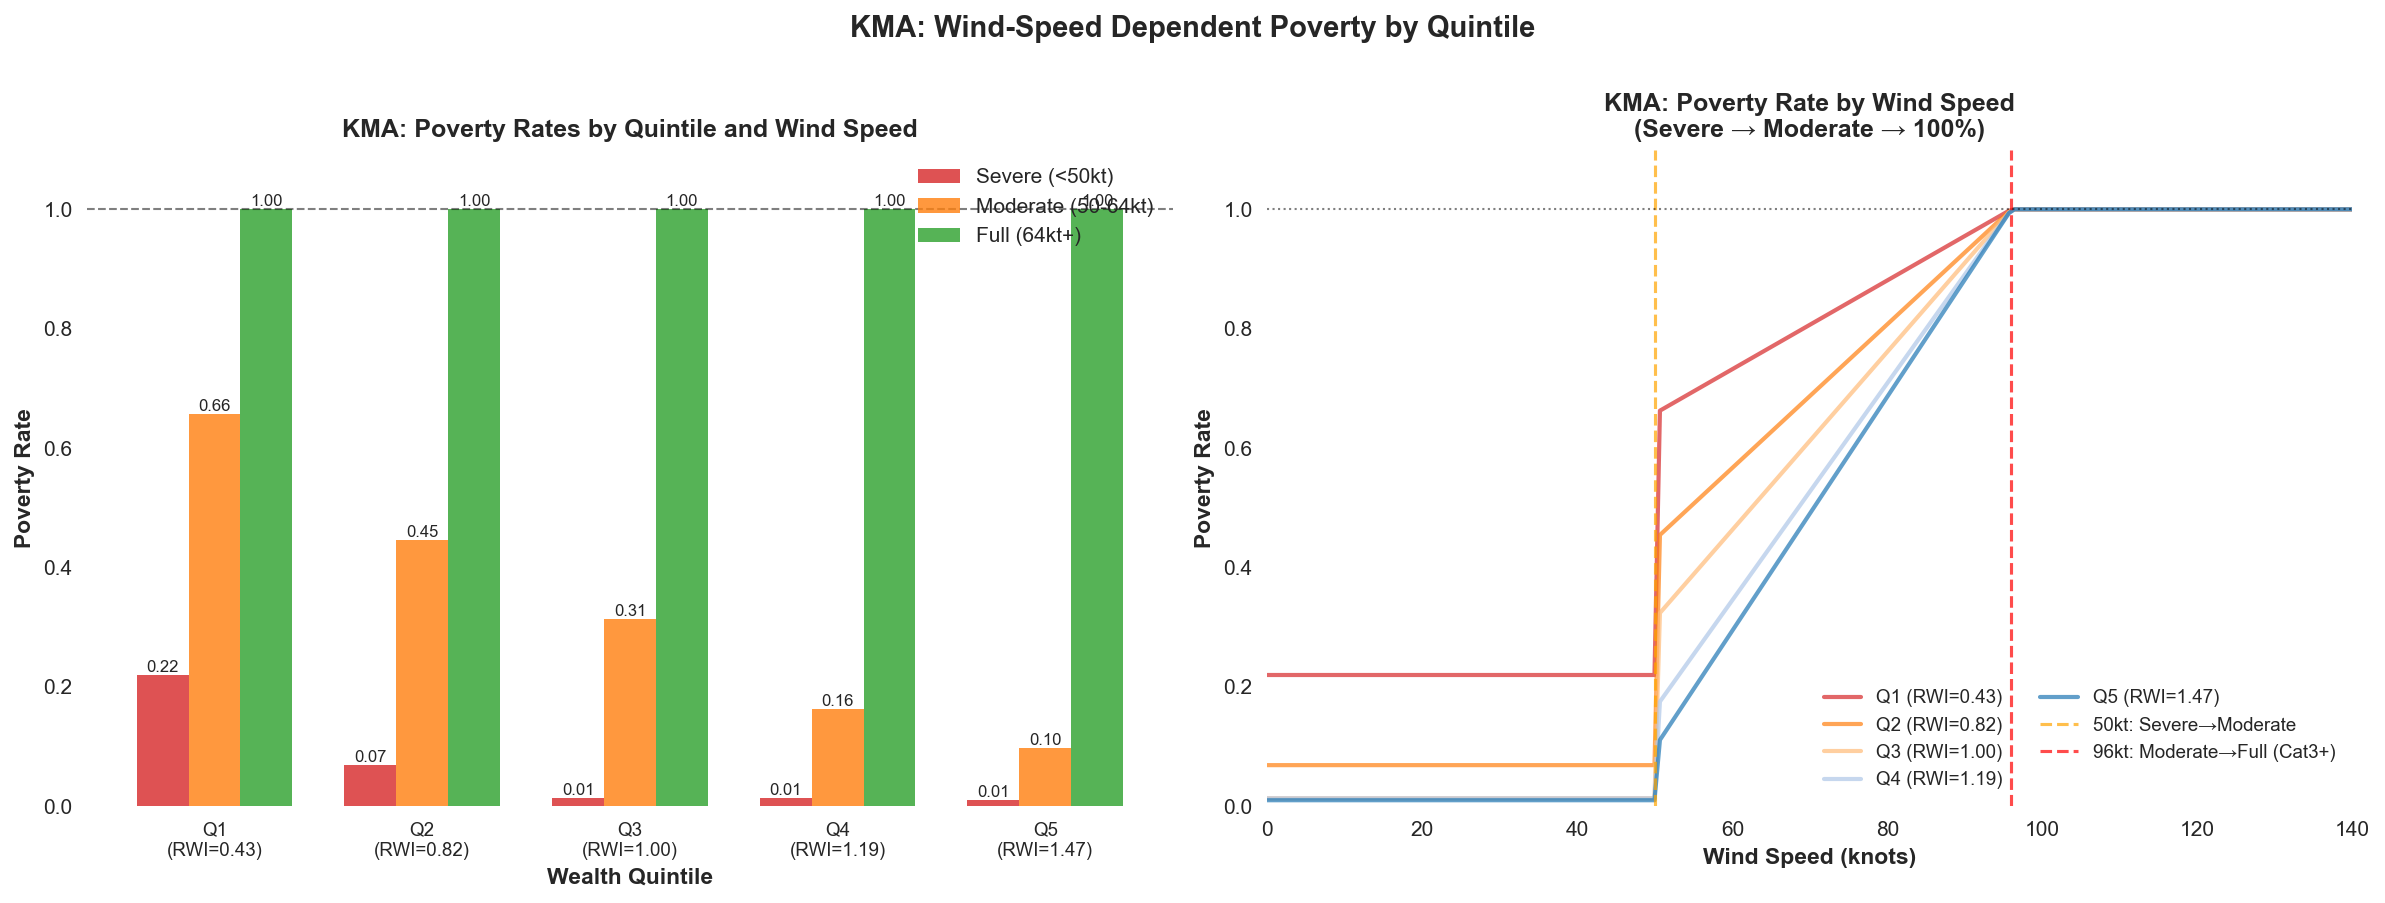

In [14]:
# Visualize how poverty rates change with wind speed for different quintiles
# For each region, show how each quintile's poverty rate changes from severe -> moderate -> 100%

for region in ['Rural', 'Urban', 'KMA']:
    if region not in all_results.get('moderate', {}) or region not in all_results.get('severe', {}):
        continue
    
    # Get quintile RWI values for this region
    region_quintile_points = df_quintile_points_moderate[df_quintile_points_moderate['classification'] == region].copy()
    region_quintile_points = region_quintile_points.sort_values('quintile')
    
    if len(region_quintile_points) == 0:
        continue
    
    # Get moderate and severe results
    moderate_result = all_results['moderate'][region]
    severe_result = all_results['severe'][region]
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left plot: Poverty rates by quintile for different wind speeds
    ax1 = axes[0]
    
    quintile_rwi_values = region_quintile_points['weighted_avg_rwi'].values
    quintile_numbers = region_quintile_points['quintile'].values
    
    # Get poverty rates for each quintile (predict_func now includes scaling)
    severe_rates = severe_result['predict_func'](quintile_rwi_values, severe_result['params'])
    
    moderate_rates = moderate_result['predict_func'](quintile_rwi_values, moderate_result['params'])
    
    # 100% for 64kt+
    full_rates = np.ones(len(quintile_rwi_values))
    
    x_pos = np.arange(len(quintile_numbers))
    width = 0.25
    
    bars1 = ax1.bar(x_pos - width, severe_rates, width, label='Severe (<50kt)', color='#d62728', alpha=0.8)
    bars2 = ax1.bar(x_pos, moderate_rates, width, label='Moderate (50-64kt)', color='#ff7f0e', alpha=0.8)
    bars3 = ax1.bar(x_pos + width, full_rates, width, label='Full (64kt+)', color='#2ca02c', alpha=0.8)
    
    ax1.set_xlabel('Wealth Quintile', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Poverty Rate', fontsize=11, fontweight='bold')
    ax1.set_title(f'{region}: Poverty Rates by Quintile and Wind Speed', fontsize=12, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f'Q{q}\n(RWI={rwi:.2f})' for q, rwi in zip(quintile_numbers, quintile_rwi_values)], fontsize=9)
    ax1.set_ylim([0, 1.1])
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=8)
    
    # Right plot: Full poverty rate curve from severe (below 50kt) through moderate (50-96kt) to 100% (96kt+)
    ax2 = axes[1]
    
    # Create wind speed range from 0 to 140kt to show full range
    wind_speeds_full = np.linspace(0, 140, 200)
    
    # For each quintile, show how poverty rate changes with wind speed
    for idx, (q, rwi_val) in enumerate(zip(quintile_numbers, quintile_rwi_values)):
        # Get severe and moderate poverty rates for this quintile
        poverty_severe = severe_rates[idx]
        poverty_moderate = moderate_rates[idx]
        
        # Initialize poverty rates array
        poverty_rates_full = np.zeros_like(wind_speeds_full)
        
        for i, ws in enumerate(wind_speeds_full):
            if ws < SEVERE_TO_MODERATE_THRESHOLD:
                # Below 50kt: use severe poverty rate
                poverty_rates_full[i] = poverty_severe
            elif ws < MODERATE_TO_FULL_THRESHOLD:
                # Between 50kt and 96kt: linear interpolation from moderate to 100%
                interp_factor = (ws - SEVERE_TO_MODERATE_THRESHOLD) / (MODERATE_TO_FULL_THRESHOLD - SEVERE_TO_MODERATE_THRESHOLD)
                poverty_rates_full[i] = poverty_moderate * (1 - interp_factor) + 1.0 * interp_factor
            else:
                # 96kt+: 100% poverty
                poverty_rates_full[i] = 1.0
        
        ax2.plot(wind_speeds_full, poverty_rates_full, 
                linewidth=2, alpha=0.7, 
                label=f'Q{q} (RWI={rwi_val:.2f})',
                color=quintile_colors[q])
    
    # Add threshold lines
    ax2.axvline(x=SEVERE_TO_MODERATE_THRESHOLD, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label=f'{SEVERE_TO_MODERATE_THRESHOLD}kt: Severe→Moderate')
    ax2.axvline(x=MODERATE_TO_FULL_THRESHOLD, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'{MODERATE_TO_FULL_THRESHOLD}kt: Moderate→Full (Cat3+)')
    ax2.axhline(y=1.0, color='black', linestyle=':', linewidth=1, alpha=0.5)
    
    ax2.set_xlabel('Wind Speed (knots)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Poverty Rate', fontsize=11, fontweight='bold')
    ax2.set_title(f'{region}: Poverty Rate by Wind Speed\n(Severe → Moderate → 100%)', fontsize=12, fontweight='bold')
    ax2.set_xlim([0, 140])
    ax2.set_ylim([0, 1.1])
    ax2.legend(loc='lower right', fontsize=9, ncol=2)
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'{region}: Wind-Speed Dependent Poverty by Quintile', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/rural_wind_speed_thresholds_-_poverty_rates_by_quintile_and_tile_coverage.png


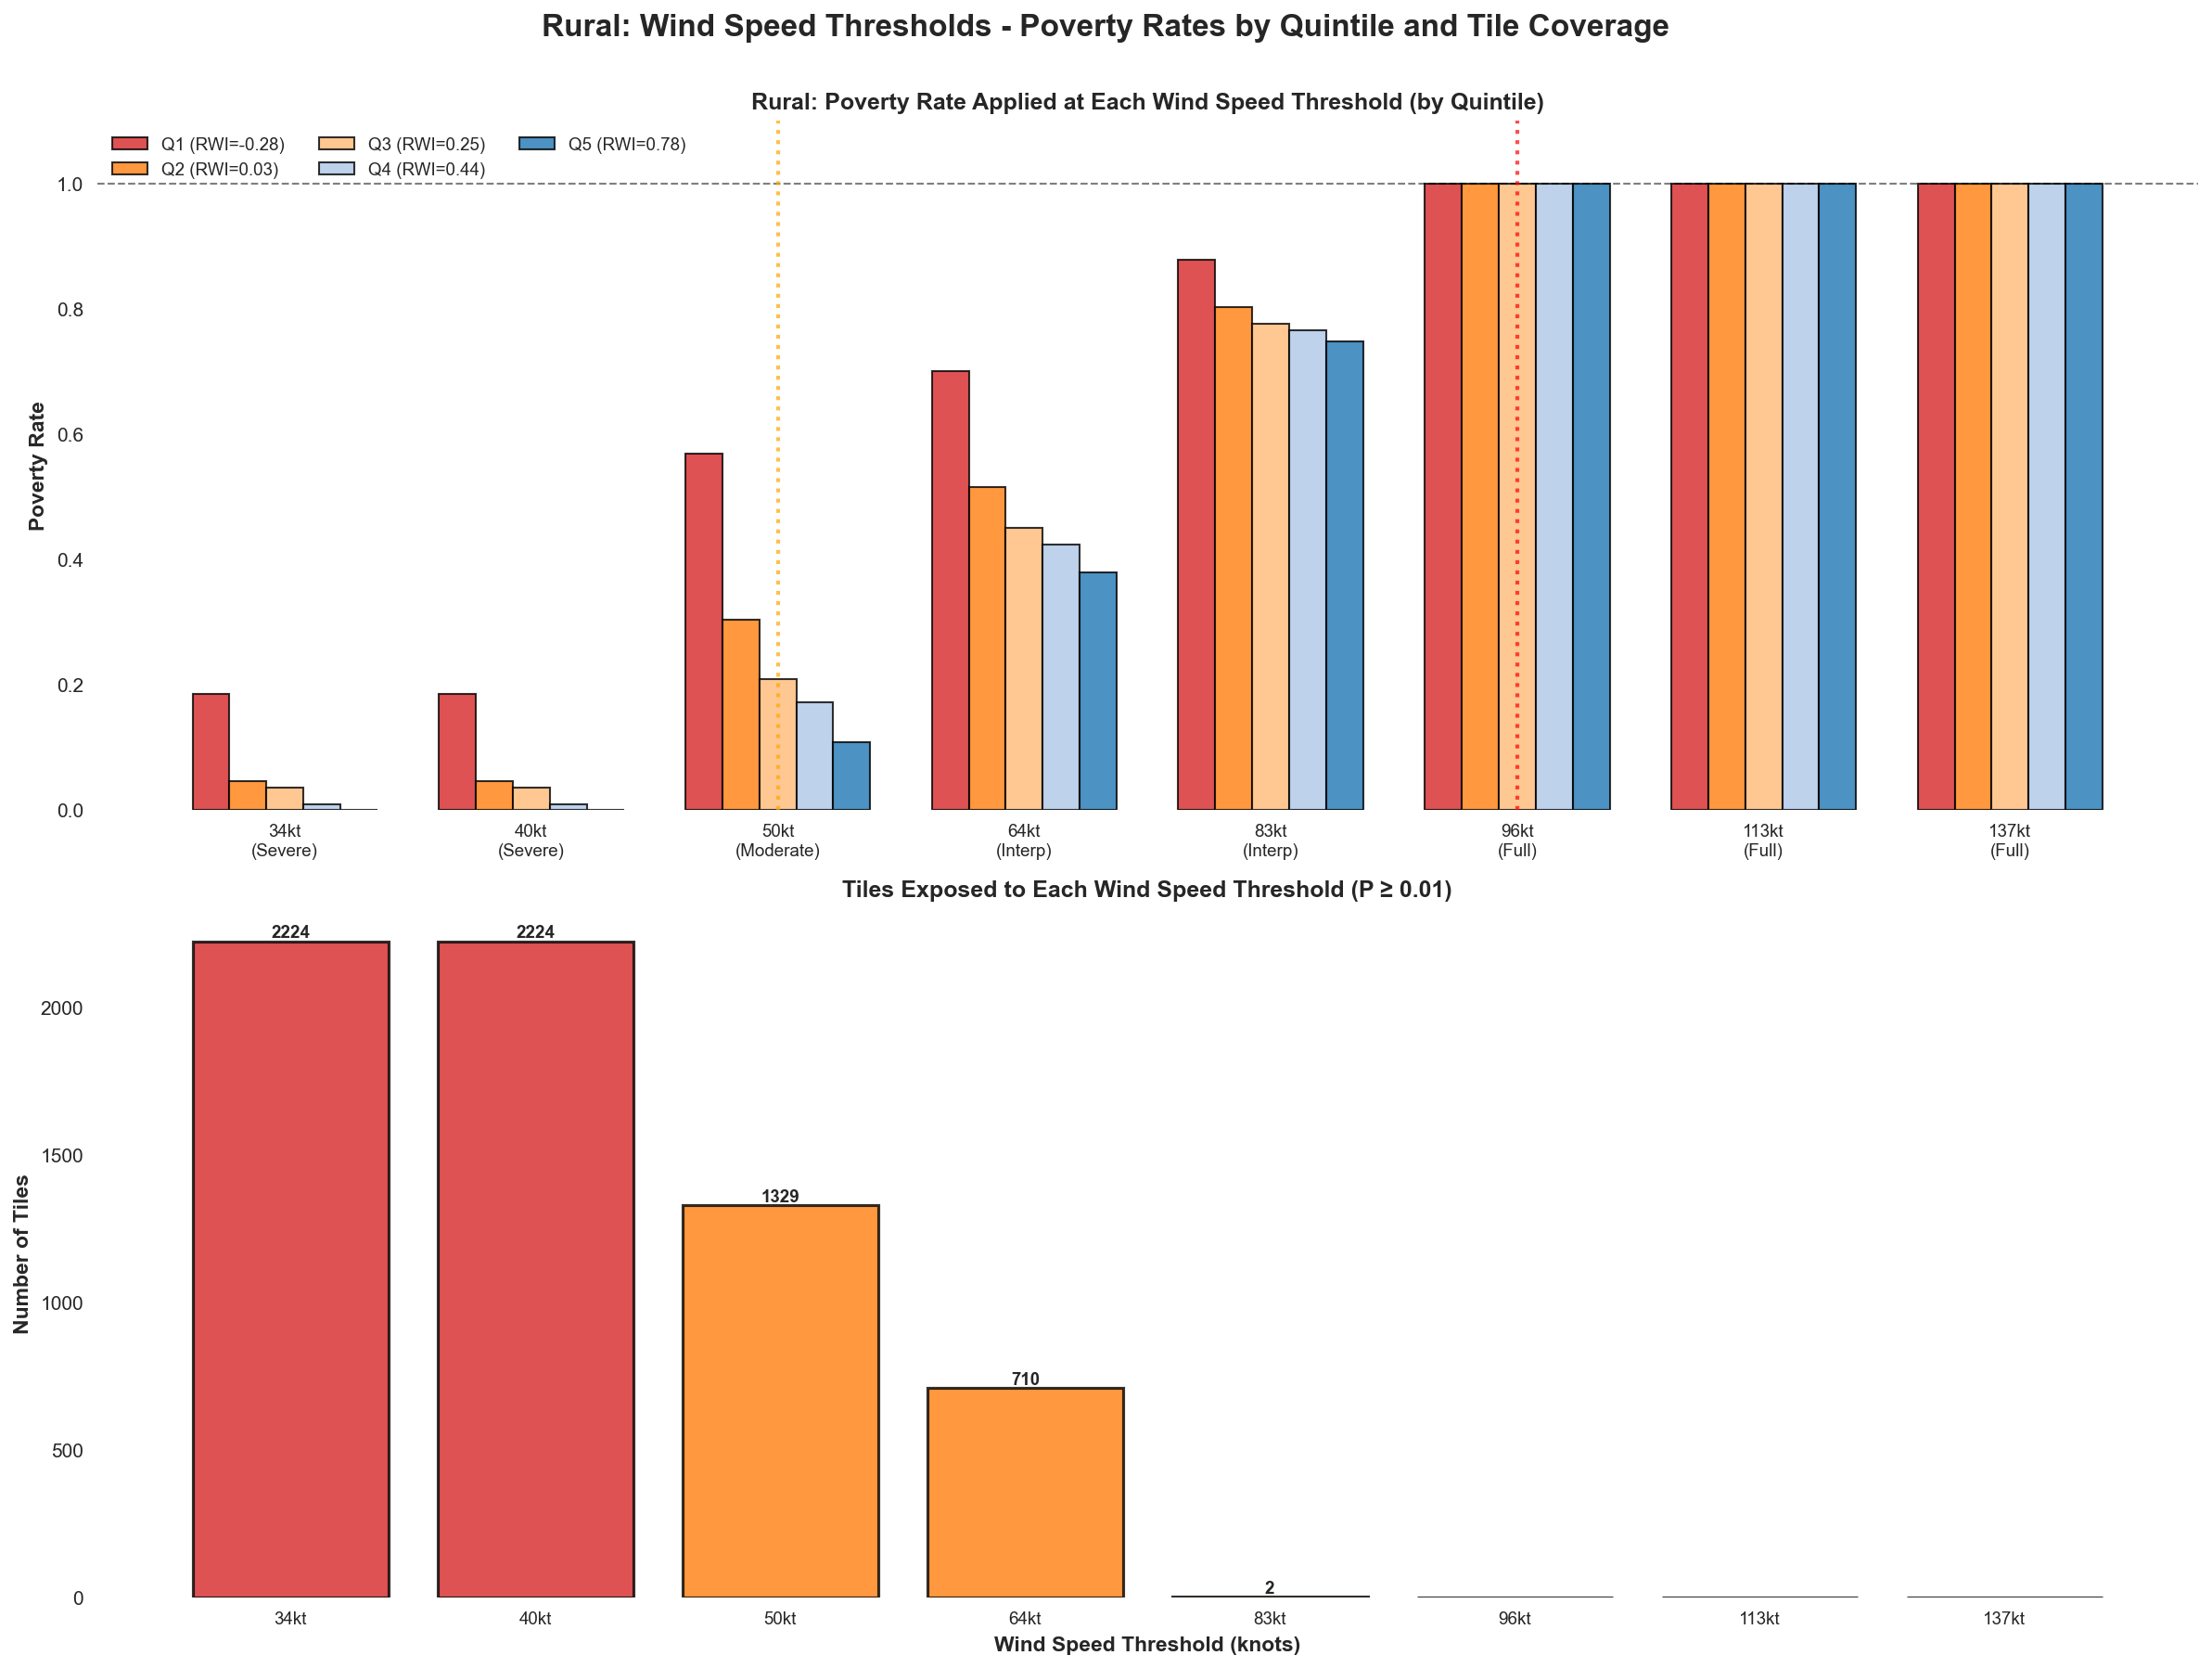

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/urban_wind_speed_thresholds_-_poverty_rates_by_quintile_and_tile_coverage.png


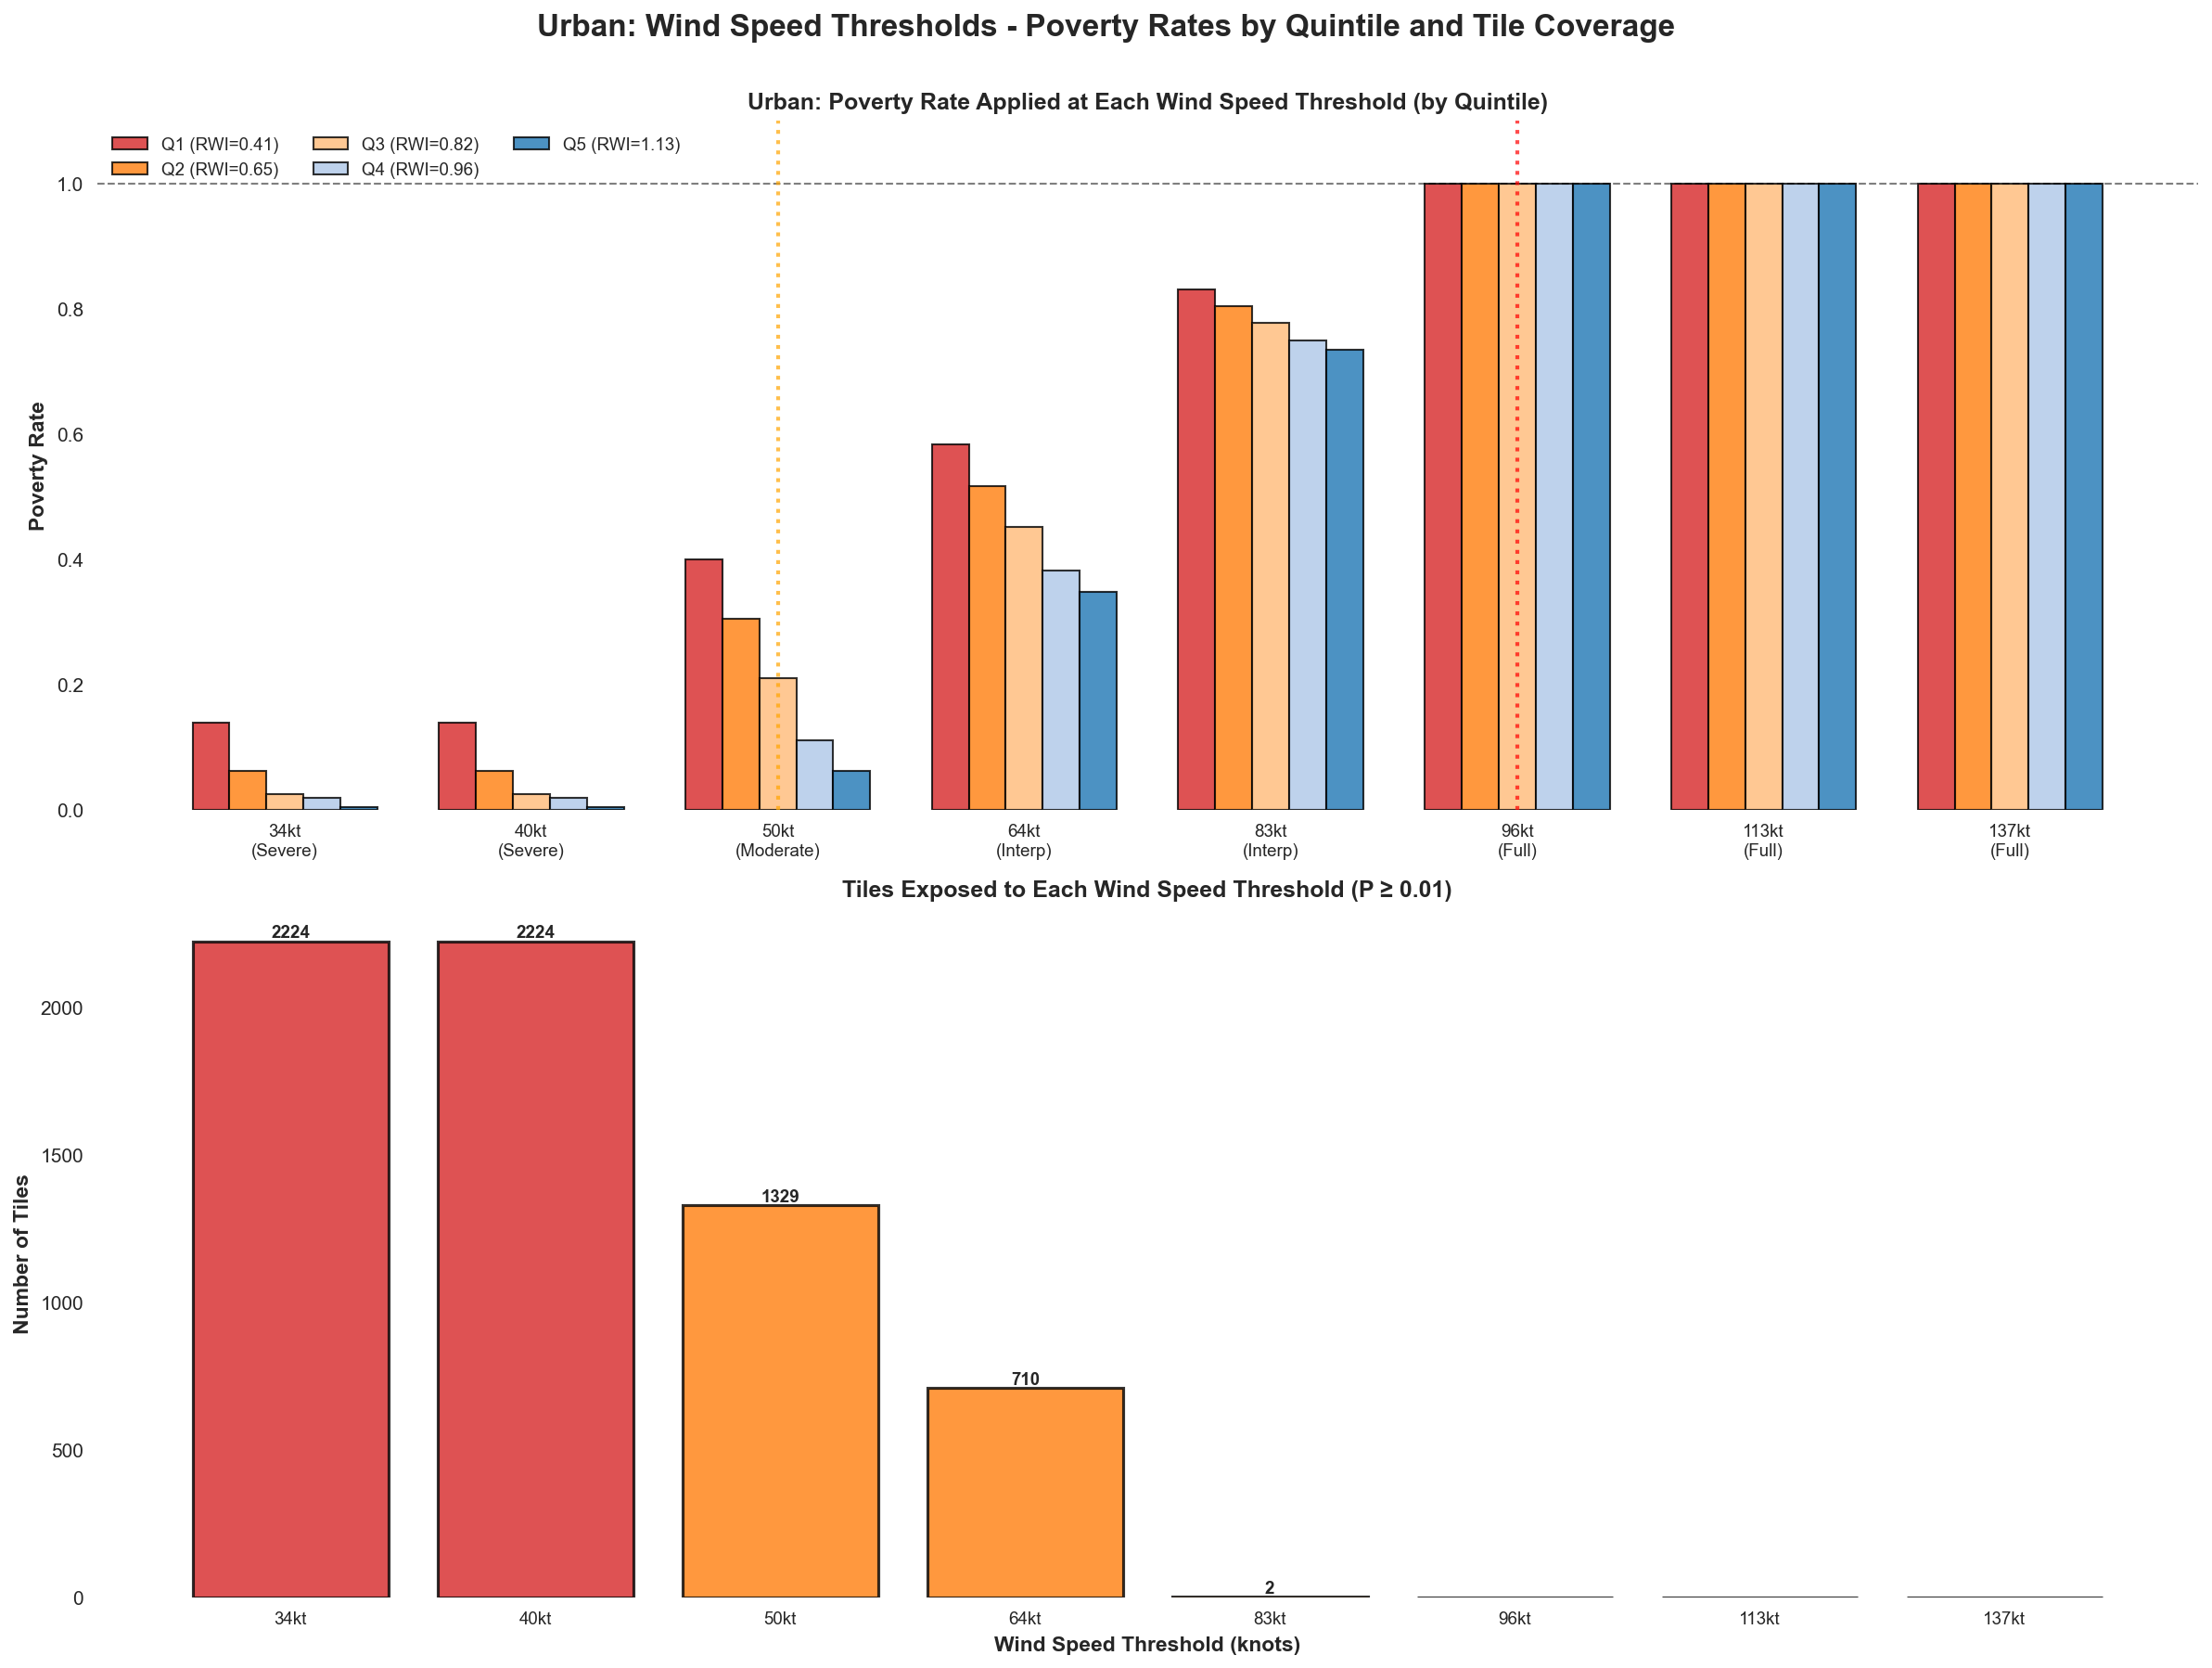

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/kma_wind_speed_thresholds_-_poverty_rates_by_quintile_and_tile_coverage.png


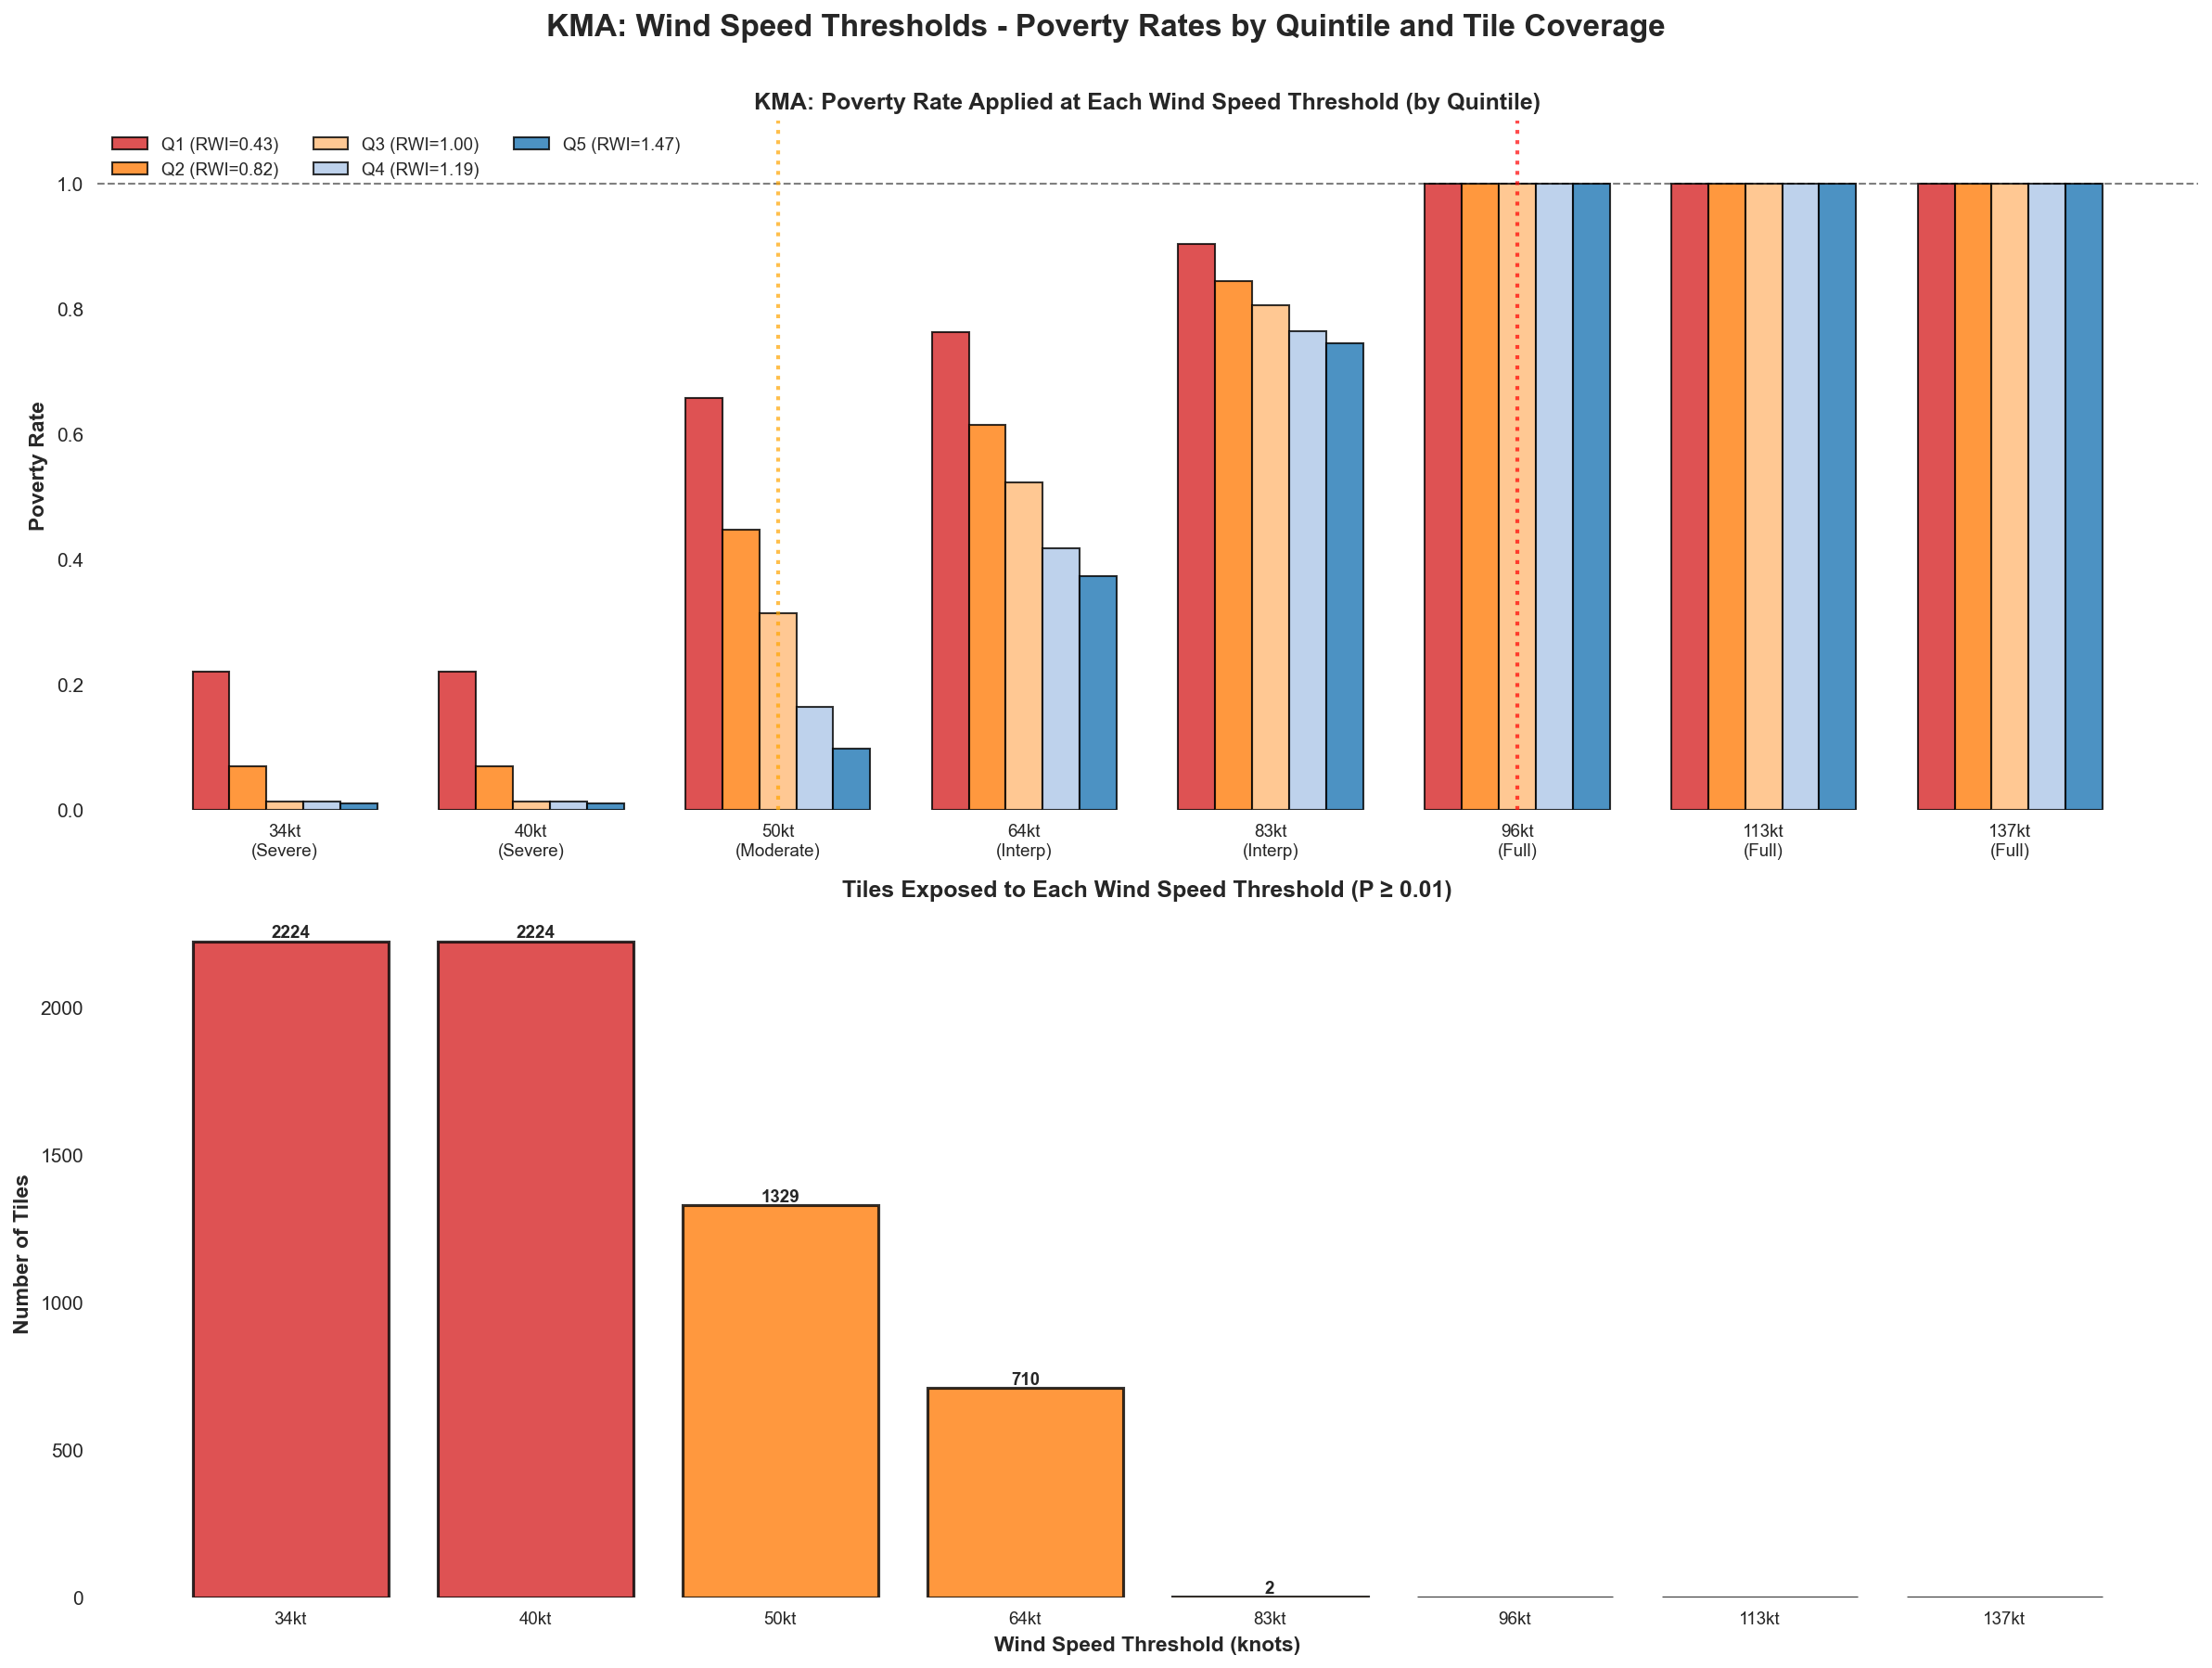


Wind Threshold Summary

Total thresholds available: 8
Thresholds: [34, 40, 50, 64, 83, 96, 113, 137] kt

Poverty Rate Configuration:
  Below 50kt: Severe poverty
  50kt to 96kt: Moderate poverty (interpolating to 100%)
  96kt+: Full poverty (Category 3+ hurricane)

Tile Exposure Summary:
  34kt: 2224 tiles (100.0%)
  40kt: 2224 tiles (100.0%)
  50kt: 1329 tiles (59.8%)
  64kt: 710 tiles (31.9%)
  83kt: 2 tiles (0.1%)
  96kt: 0 tiles (0.0%)
  113kt: 0 tiles (0.0%)
  137kt: 0 tiles (0.0%)


In [15]:
# Visualize how all wind thresholds contribute to poverty calculation
# Show poverty rates by quintile for each region
threshold_ints = sorted(WIND_THRESHOLDS_DICT.keys())

# Create visualization for each region
for region in ['Rural', 'Urban', 'KMA']:
    if region not in all_results.get('moderate', {}) or region not in all_results.get('severe', {}):
        continue
    
    # Get quintile data for this region
    region_quintile_points = df_quintile_points_moderate[df_quintile_points_moderate['classification'] == region].copy()
    region_quintile_points = region_quintile_points.sort_values('quintile')
    
    if len(region_quintile_points) == 0:
        continue
    
    # Get moderate and severe results
    moderate_result = all_results['moderate'][region]
    severe_result = all_results['severe'][region]
    
    quintile_rwi_values = region_quintile_points['weighted_avg_rwi'].values
    quintile_numbers = region_quintile_points['quintile'].values
    
    # Get poverty rates for each quintile
    severe_rates = severe_result['predict_func'](quintile_rwi_values, severe_result['params'])
    moderate_rates = moderate_result['predict_func'](quintile_rwi_values, moderate_result['params'])
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Top plot: Poverty rate by wind speed threshold for each quintile
    ax1 = axes[0]
    
    # Calculate poverty rates for each threshold and quintile
    x_pos = np.arange(len(threshold_ints))
    width = 0.15  # Width of each bar group
    n_quintiles = len(quintile_numbers)
    
    # Colors for each quintile
    quintile_colors_list = [quintile_colors[q] for q in quintile_numbers]
    
    # Calculate poverty rates for each threshold and quintile
    for quintile_idx, (q, rwi_val, severe_rate, moderate_rate) in enumerate(zip(quintile_numbers, quintile_rwi_values, severe_rates, moderate_rates)):
        poverty_rates_by_threshold = []
        
        for kt in threshold_ints:
            if kt < SEVERE_TO_MODERATE_THRESHOLD:
                # Below 50kt: use severe poverty rate for this quintile
                poverty_rate = severe_rate
            elif kt < MODERATE_TO_FULL_THRESHOLD:
                # Between 50kt and 96kt: interpolate
                if kt == SEVERE_TO_MODERATE_THRESHOLD:
                    poverty_rate = moderate_rate
                else:
                    interp_factor = (kt - SEVERE_TO_MODERATE_THRESHOLD) / (MODERATE_TO_FULL_THRESHOLD - SEVERE_TO_MODERATE_THRESHOLD)
                    poverty_rate = moderate_rate * (1 - interp_factor) + 1.0 * interp_factor
            else:
                # 96kt+: 100%
                poverty_rate = 1.0
            
            poverty_rates_by_threshold.append(poverty_rate)
        
        # Plot bars for this quintile
        offset = (quintile_idx - n_quintiles/2 + 0.5) * width
        bars = ax1.bar(x_pos + offset, poverty_rates_by_threshold, 
                       width, label=f'Q{q} (RWI={rwi_val:.2f})',
                       color=quintile_colors_list[quintile_idx], alpha=0.8, edgecolor='black', linewidth=1)
    
    # Set labels and formatting
    threshold_labels = []
    for kt in threshold_ints:
        if kt < SEVERE_TO_MODERATE_THRESHOLD:
            label = f'{kt}kt\n(Severe)'
        elif kt < MODERATE_TO_FULL_THRESHOLD:
            if kt == SEVERE_TO_MODERATE_THRESHOLD:
                label = f'{kt}kt\n(Moderate)'
            else:
                label = f'{kt}kt\n(Interp)'
        else:
            label = f'{kt}kt\n(Full)'
        threshold_labels.append(label)
    
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(threshold_labels, fontsize=9)
    ax1.set_ylabel('Poverty Rate', fontsize=11, fontweight='bold')
    ax1.set_title(f'{region}: Poverty Rate Applied at Each Wind Speed Threshold (by Quintile)', fontsize=12, fontweight='bold')
    ax1.set_ylim([0, 1.1])
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax1.legend(loc='upper left', fontsize=9, ncol=3)
    
    # Add threshold lines
    ax1.axvline(x=threshold_ints.index(SEVERE_TO_MODERATE_THRESHOLD), 
               color='orange', linestyle=':', linewidth=2, alpha=0.7, label=f'{SEVERE_TO_MODERATE_THRESHOLD}kt: Severe→Moderate')
    ax1.axvline(x=threshold_ints.index(MODERATE_TO_FULL_THRESHOLD), 
               color='red', linestyle=':', linewidth=2, alpha=0.7, label=f'{MODERATE_TO_FULL_THRESHOLD}kt: Moderate→Full (Cat3+)')
    
    # Bottom plot: Number of tiles exposed to each threshold (unchanged)
    ax2 = axes[1]
    
    # Count tiles with exposure at each threshold
    tile_counts = []
    for kt in threshold_ints:
        prob_col = f'impact_probability_{kt}kt'
        if prob_col in gdf_tiles_final.columns:
            count = (gdf_tiles_final[prob_col].fillna(0.0) > 0.01).sum()
        else:
            count = 0
        tile_counts.append(count)
    
    # Colors for threshold bars
    colors_threshold = []
    for kt in threshold_ints:
        if kt < SEVERE_TO_MODERATE_THRESHOLD:
            colors_threshold.append('#d62728')  # Red for severe
        elif kt < MODERATE_TO_FULL_THRESHOLD:
            colors_threshold.append('#ff7f0e')  # Orange for moderate/interp
        else:
            colors_threshold.append('#2ca02c')  # Green for full
    
    bars2 = ax2.bar(range(len(threshold_ints)), tile_counts, 
                    color=colors_threshold, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_xticks(range(len(threshold_ints)))
    ax2.set_xticklabels([f'{kt}kt' for kt in threshold_ints], fontsize=9)
    ax2.set_ylabel('Number of Tiles', fontsize=11, fontweight='bold')
    ax2.set_xlabel('Wind Speed Threshold (knots)', fontsize=11, fontweight='bold')
    ax2.set_title('Tiles Exposed to Each Wind Speed Threshold (P ≥ 0.01)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars2, tile_counts)):
        if count > 0:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{count}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.suptitle(f'{region}: Wind Speed Thresholds - Poverty Rates by Quintile and Tile Coverage', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

# Print summary
print("\n" + "="*80)
print("Wind Threshold Summary")
print("="*80)
print(f"\nTotal thresholds available: {len(threshold_ints)}")
print(f"Thresholds: {threshold_ints} kt")
print(f"\nPoverty Rate Configuration:")
print(f"  Below {SEVERE_TO_MODERATE_THRESHOLD}kt: Severe poverty")
print(f"  {SEVERE_TO_MODERATE_THRESHOLD}kt to {MODERATE_TO_FULL_THRESHOLD}kt: Moderate poverty (interpolating to 100%)")
print(f"  {MODERATE_TO_FULL_THRESHOLD}kt+: Full poverty (Category 3+ hurricane)")
print(f"\nTile Exposure Summary:")
for i, kt in enumerate(threshold_ints):
    prob_col = f'impact_probability_{kt}kt'
    if prob_col in gdf_tiles_final.columns:
        count = (gdf_tiles_final[prob_col].fillna(0.0) > 0.01).sum()
    else:
        count = 0
    pct = (count / len(gdf_tiles_final) * 100) if len(gdf_tiles_final) > 0 else 0
    print(f"  {kt}kt: {count} tiles ({pct:.1f}%)")

## Save Results

Using 34kt wind threshold for hurricane impact: impact_probability_34kt

Validation passed: CHIN <= Affected Children for all parishes
COMPREHENSIVE PARISH-LEVEL IMPACT ANALYSIS SUMMARY
(Wind-Dependent Poverty / CHIN)

Note: CHIN = Wind-dependent poor children among those affected by 34kt+ wind
      CHIN is calculated as: poor_children_wind_dependent × impact_probability_34kt
      This ensures CHIN <= Affected Children

Parish and Constituency Total Children % affectation expected HUR (34kt) Affected Children Child poverty rates (%) Severe poverty rate (%) Moderate poverty rate (%)   CHIN CHIN (Severe) CHIN (Moderate)
                  Total        845,815                                             297,544                    6.4%                    5.5%                     26.8% 19,648        15,137          74,712
              Clarendon         83,314                               34%            28,555                    7.5%                    6.8%                     29.6%  2,18

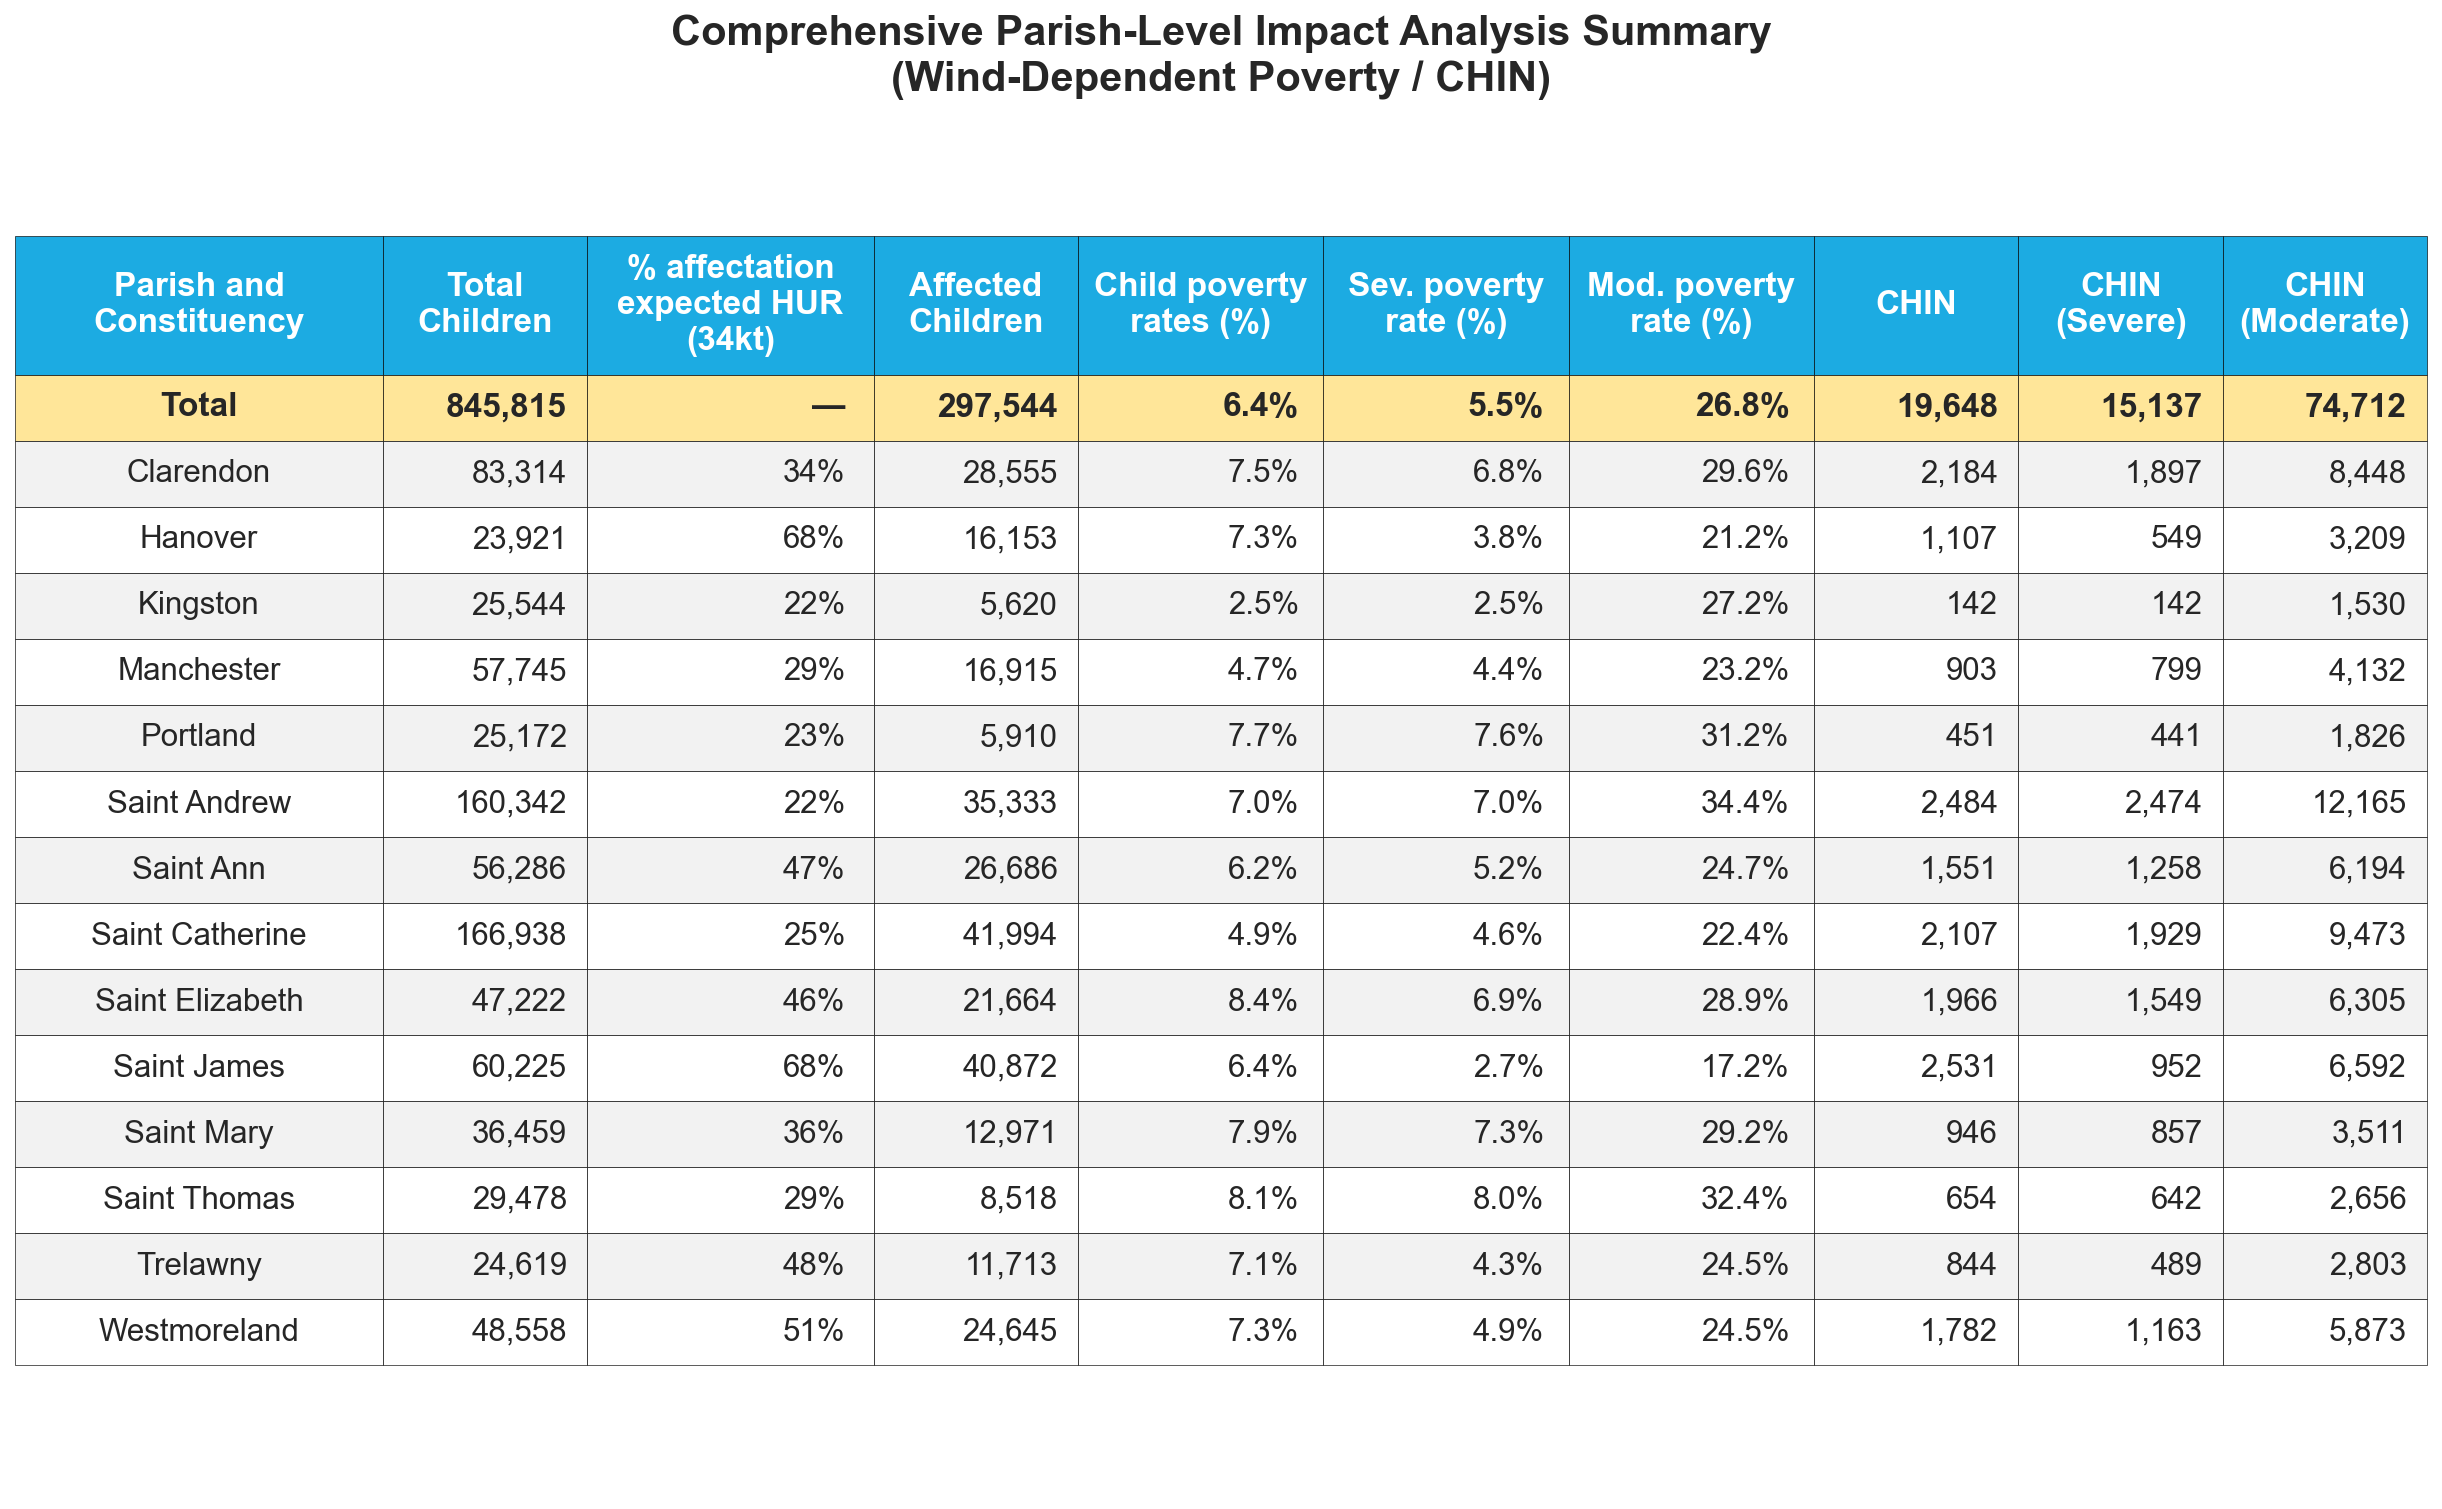


Table visualization created successfully from: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/comprehensive_parish_summary_table.csv


In [16]:
# Define output directory
output_dir = 'analysis_output/poor_children_impact_analysis_wind_dependent_poverty'
os.makedirs(output_dir, exist_ok=True)

# Check if we have impact data
has_impact_data = False
impact_cols = []
hur_34kt_col = None
if 'gdf_tiles_final' in locals():
    for col in gdf_tiles_final.columns:
        if col.startswith('impact_probability_') and col.endswith('kt'):
            has_impact_data = True
            impact_cols.append(col)
            # Find 34kt column specifically (includes all wind scenarios from 34kt+)
            if '34kt' in col:
                hur_34kt_col = col
    
    if hur_34kt_col:
        print(f"Using 34kt wind threshold for hurricane impact: {hur_34kt_col}")
    elif impact_cols:
        print(f"Warning: 34kt threshold not found. Available thresholds: {impact_cols}")
        print(f"  Using first available threshold: {impact_cols[0]}")
        hur_34kt_col = impact_cols[0]
    print()

# Aggregate data by parish
parish_summary = []

for parish_name in sorted(gdf_tiles_final['parish'].unique()):
    parish_tiles = gdf_tiles_final[gdf_tiles_final['parish'] == parish_name]
    
    if len(parish_tiles) == 0:
        continue
    
    # Children data (ages 0-15) - actual data from tiles
    total_children = parish_tiles['children_population'].sum()
    
    # Impact data - use 34kt wind threshold for hurricane impact (includes all wind scenarios from 34kt+)
    affected_children_hur = 0
    chin_hur = 0  # Children In Need (wind-dependent poor children among those affected)
    affectation_rate_hur = 0
    
    if has_impact_data and hur_34kt_col and hur_34kt_col in parish_tiles.columns:
        # Calculate affected children based on 34kt impact probability (at tile level)
            # Affected Children: children_population x impact_probability_34kt
        affected_children_hur = (parish_tiles['children_population'] * parish_tiles[hur_34kt_col]).sum()
        
        # Calculate affectation rate (weighted average impact probability for children)
        total_children_weight = parish_tiles['children_population'].sum()
        affectation_rate_hur = (parish_tiles['children_population'] * parish_tiles[hur_34kt_col]).sum() / total_children_weight * 100 if total_children_weight > 0 else 0
        
        # CHIN (Children In Need) - wind-dependent poor children among those affected by 34kt+ wind
            # Compute at tile level: poor_children_wind_dependent × impact_probability_34kt, then sum
        # This ensures CHIN <= Affected Children (since poor_children_wind_dependent <= children_population)
        chin_hur = (parish_tiles['poor_children_wind_dependent'].fillna(0) * parish_tiles[hur_34kt_col].fillna(0)).sum()
    
    # Calculate wind-dependent child poverty rate (overall, not just affected)
    total_poor_children_wind_dep = parish_tiles['poor_children_wind_dependent'].sum()
    child_poverty_rate_wind_dep = (total_poor_children_wind_dep / total_children * 100) if total_children > 0 else 0
    
    # Calculate severe poverty rates and CHIN
    total_poor_children_severe = 0
    chin_severe = 0
    if 'poverty_prob_severe' in parish_tiles.columns:
        # Calculate poor children using severe poverty rate
        total_poor_children_severe = (parish_tiles['children_population'] * parish_tiles['poverty_prob_severe']).sum()
        child_poverty_rate_severe = (total_poor_children_severe / total_children * 100) if total_children > 0 else 0
        # CHIN_severe = poor_children_severe × impact_probability_34kt
        if has_impact_data and hur_34kt_col and hur_34kt_col in parish_tiles.columns:
            chin_severe = (parish_tiles['children_population'] * parish_tiles['poverty_prob_severe'] * parish_tiles[hur_34kt_col].fillna(0)).sum()
    else:
        child_poverty_rate_severe = 0
    
    # Calculate moderate poverty rates and CHIN
    total_poor_children_moderate = 0
    chin_moderate = 0
    if 'poverty_prob_moderate' in parish_tiles.columns:
        # Calculate poor children using moderate poverty rate
        total_poor_children_moderate = (parish_tiles['children_population'] * parish_tiles['poverty_prob_moderate']).sum()
        child_poverty_rate_moderate = (total_poor_children_moderate / total_children * 100) if total_children > 0 else 0
        # CHIN_moderate = poor_children_moderate × impact_probability_34kt
        if has_impact_data and hur_34kt_col and hur_34kt_col in parish_tiles.columns:
            chin_moderate = (parish_tiles['children_population'] * parish_tiles['poverty_prob_moderate'] * parish_tiles[hur_34kt_col].fillna(0)).sum()
    else:
        child_poverty_rate_moderate = 0
    
    parish_summary.append({
        'Parish and Constituency': parish_name,
        'Total Children': np.ceil(total_children),
        '% affectation expected HUR (34kt)': affectation_rate_hur,
        'Affected Children': np.ceil(affected_children_hur),
        'Child poverty rates (%)': child_poverty_rate_wind_dep,
                'Severe poverty rate (%)': child_poverty_rate_severe,
                'Moderate poverty rate (%)': child_poverty_rate_moderate,
        'CHIN': np.ceil(chin_hur),  # Wind-dependent poor children among those affected by 34kt+ wind
        'CHIN (Severe)': np.ceil(chin_severe),
        'CHIN (Moderate)': np.ceil(chin_moderate)
    })

# Create DataFrame
df_parish_summary = pd.DataFrame(parish_summary)

# Validate: CHIN should be <= Affected Children
validation_errors = df_parish_summary[df_parish_summary['CHIN'] > df_parish_summary['Affected Children']]
if len(validation_errors) > 0:
    print("WARNING: Found parishes where CHIN > Affected Children:")
    print(validation_errors[['Parish and Constituency', 'Affected Children', 'CHIN']])
    print("\nThis should not happen. Checking data...")
    # Cap CHIN at Affected Children for safety
    df_parish_summary['CHIN'] = df_parish_summary[['CHIN', 'Affected Children']].min(axis=1)
else:
    print("Validation passed: CHIN <= Affected Children for all parishes")

# Compute totals from original unrounded data (before rounding in the dataframe)
# This ensures accuracy - sum first, then round up (not round then sum)
total_children_unrounded = gdf_tiles_final['children_population'].sum()

affected_children_unrounded = 0
chin_unrounded = 0
if has_impact_data and hur_34kt_col and hur_34kt_col in gdf_tiles_final.columns:
    # Compute totals fresh at tile level
    affected_children_unrounded = (gdf_tiles_final['children_population'] * gdf_tiles_final[hur_34kt_col]).sum()
    # CHIN = poor_children_wind_dependent × impact_probability_34kt
    chin_unrounded = (gdf_tiles_final['poor_children_wind_dependent'].fillna(0) * gdf_tiles_final[hur_34kt_col].fillna(0)).sum()

total_poor_children_wind_dep_unrounded = gdf_tiles_final['poor_children_wind_dependent'].sum()

# Calculate severe and moderate poverty totals
total_poor_children_severe_unrounded = 0
total_poor_children_moderate_unrounded = 0
chin_severe_unrounded = 0
chin_moderate_unrounded = 0
if 'poverty_prob_severe' in gdf_tiles_final.columns:
    total_poor_children_severe_unrounded = (gdf_tiles_final['children_population'] * gdf_tiles_final['poverty_prob_severe']).sum()
    if has_impact_data and hur_34kt_col and hur_34kt_col in gdf_tiles_final.columns:
        chin_severe_unrounded = (gdf_tiles_final['children_population'] * gdf_tiles_final['poverty_prob_severe'] * gdf_tiles_final[hur_34kt_col].fillna(0)).sum()
if 'poverty_prob_moderate' in gdf_tiles_final.columns:
    total_poor_children_moderate_unrounded = (gdf_tiles_final['children_population'] * gdf_tiles_final['poverty_prob_moderate']).sum()
    if has_impact_data and hur_34kt_col and hur_34kt_col in gdf_tiles_final.columns:
        chin_moderate_unrounded = (gdf_tiles_final['children_population'] * gdf_tiles_final['poverty_prob_moderate'] * gdf_tiles_final[hur_34kt_col].fillna(0)).sum()

# Add Total row - use unrounded totals, then round up
total_row = {
    'Parish and Constituency': 'Total',
    'Total Children': np.ceil(total_children_unrounded),
    '% affectation expected HUR (34kt)': '',  # Leave blank for total
    'Affected Children': np.ceil(affected_children_unrounded),
    'Child poverty rates (%)': (total_poor_children_wind_dep_unrounded / total_children_unrounded * 100) if total_children_unrounded > 0 else 0,
        'Severe poverty rate (%)': (total_poor_children_severe_unrounded / total_children_unrounded * 100) if total_children_unrounded > 0 else 0,
        'Moderate poverty rate (%)': (total_poor_children_moderate_unrounded / total_children_unrounded * 100) if total_children_unrounded > 0 else 0,
    'CHIN': np.ceil(chin_unrounded),
    'CHIN (Severe)': np.ceil(chin_severe_unrounded),
    'CHIN (Moderate)': np.ceil(chin_moderate_unrounded)
}

# Insert total row at the beginning
df_parish_summary = pd.concat([pd.DataFrame([total_row]), df_parish_summary], ignore_index=True)

# Format the table for display
print("="*120)
print("COMPREHENSIVE PARISH-LEVEL IMPACT ANALYSIS SUMMARY")
print("(Wind-Dependent Poverty / CHIN)")
print("="*120)
print()
print("Note: CHIN = Wind-dependent poor children among those affected by 34kt+ wind")
print("      CHIN is calculated as: poor_children_wind_dependent × impact_probability_34kt")
print("      This ensures CHIN <= Affected Children")
print()

# Display formatted table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Format numbers for display
df_display = df_parish_summary.copy()
for col in ['Total Children', 'Affected Children', 'CHIN', 'CHIN (Severe)', 'CHIN (Moderate)']:
    if col in df_display.columns:
        df_display[col] = df_display[col].apply(lambda x: f"{x:,.0f}" if pd.notna(x) and isinstance(x, (int, float)) else "")

for col in ['% affectation expected HUR (34kt)']:
    if col in df_display.columns:
        df_display[col] = df_display[col].apply(lambda x: f"{x:.0f}%" if pd.notna(x) and isinstance(x, (int, float)) and x > 0 else "")

for col in ['Child poverty rates (%)', 'Severe poverty rate (%)', 'Moderate poverty rate (%)']:
    if col in df_display.columns:
        df_display[col] = df_display[col].apply(lambda x: f"{x:.1f}%" if pd.notna(x) and isinstance(x, (int, float)) else "")

print(df_display.to_string(index=False))
print()

# Export to CSV
summary_file = os.path.join('analysis_output', 'poor_children_impact_analysis_wind_dependent_poverty', 'comprehensive_parish_summary_table.csv')
df_parish_summary.to_csv(summary_file, index=False)
print(f"\nExported comprehensive summary table to: {summary_file}")

# Create visualization table
fig, ax = plt.subplots(figsize=(16, max(10, len(df_parish_summary) * 0.4)))
ax.axis('tight')
ax.axis('off')

# Prepare table data with formatted values
table_data = []
headers = ['Parish and\nConstituency', 'Total\nChildren', '% affectation\nexpected HUR\n(34kt)', 
           'Affected\nChildren', 'Child poverty\nrates (%)', 'Sev. poverty\nrate (%)', 'Mod. poverty\nrate (%)',
           'CHIN', 'CHIN\n(Severe)', 'CHIN\n(Moderate)']
table_data.append(headers)

# Data rows
for idx, row in df_parish_summary.iterrows():
    parish_name = str(row['Parish and Constituency'])
    
    # Format values - handle different data types safely
    total_children_val = row['Total Children']
    if pd.notna(total_children_val):
        try:
            total_children = f"{float(total_children_val):,.0f}"
        except (ValueError, TypeError):
            total_children = str(total_children_val)
    else:
        total_children = ""
    
    affectation_rate_val = row['% affectation expected HUR (34kt)']
    # Check if this is the Total row
    if parish_name == 'Total':
        affectation_rate = "—"
    elif pd.notna(affectation_rate_val) and affectation_rate_val != '':
        try:
            affectation_rate = f"{float(affectation_rate_val):.0f}%"
        except (ValueError, TypeError):
            affectation_rate = str(affectation_rate_val) if affectation_rate_val else ""
    else:
        affectation_rate = ""
    
    affected_children_val = row['Affected Children']
    if pd.notna(affected_children_val):
        try:
            affected_children = f"{float(affected_children_val):,.0f}"
        except (ValueError, TypeError):
            affected_children = str(affected_children_val)
    else:
        affected_children = ""
    
    poverty_rate_val = row['Child poverty rates (%)']
    if pd.notna(poverty_rate_val):
        try:
            poverty_rate = f"{float(poverty_rate_val):.1f}%"
        except (ValueError, TypeError):
            poverty_rate = str(poverty_rate_val)
    else:
        poverty_rate = ""
    
    chin_val = row['CHIN']
    if pd.notna(chin_val):
        try:
            chin = f"{float(chin_val):,.0f}"
        except (ValueError, TypeError):
            chin = str(chin_val)
    else:
        chin = ""
    
    table_data.append([
        parish_name,
        total_children,
        affectation_rate,
        affected_children,
        poverty_rate,
        f"{float(row['Severe poverty rate (%)']):.1f}%" if pd.notna(row.get('Severe poverty rate (%)')) else "",
        f"{float(row['Moderate poverty rate (%)']):.1f}%" if pd.notna(row.get('Moderate poverty rate (%)')) else "",
        chin,
        f"{float(row['CHIN (Severe)']):,.0f}" if pd.notna(row.get('CHIN (Severe)')) else "",
        f"{float(row['CHIN (Moderate)']):,.0f}" if pd.notna(row.get('CHIN (Moderate)')) else ""
    ])
table = ax.table(cellText=table_data, loc='center', cellLoc='center',
                colWidths=[0.18, 0.10, 0.14, 0.10, 0.12, 0.12, 0.12, 0.10, 0.10, 0.10])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(15)
table.scale(1, 2.2)

# Style header row
for i in range(len(headers)):
    table[(0, i)].set_facecolor('#1cabe2')
    table[(0, i)].set_text_props(weight='bold', color='white', fontsize=16)
    table[(0, i)].set_height(0.10)

# Style data rows
for i in range(1, len(table_data)):
    # Highlight total row
    if table_data[i][0] == 'Total':
        for j in range(len(headers)):
            table[(i, j)].set_facecolor('#FFE699')
            table[(i, j)].set_text_props(weight='bold', fontsize=16)
    else:
        # Alternate row colors for readability
        if i % 2 == 0:
            for j in range(len(headers)):
                table[(i, j)].set_facecolor('#F2F2F2')
    
    # Right-align numeric columns
    for j in [1, 2, 3, 4, 5, 6, 7, 8, 9]:  # All columns except parish name
        table[(i, j)].set_text_props(ha='right')

# Set title
ax.set_title('Comprehensive Parish-Level Impact Analysis Summary\n(Wind-Dependent Poverty / CHIN)', 
             fontsize=20, fontweight='bold', pad=8)

plt.tight_layout(pad=0.5)  # Minimal padding
plt.show()

print(f"\nTable visualization created successfully from: {summary_file}")


## Expected Impacted Poor Children (CHIN) by Parish and Wind Threshold

Visualizations showing wind-dependent poor children (CHIN) among those affected by different wind thresholds.


Parish CHIN Summary (Wind-Dependent Poor Children Among Affected):
         parish  total_tiles  poor_children_wind_dep
      Clarendon          240             6214.495198
        Hanover          100             1738.812743
       Kingston            4              644.748751
     Manchester          159             2689.372422
       Portland          171             1949.932836
   Saint Andrew           94            11206.652519
      Saint Ann          240             3471.333048
Saint Catherine          239             8259.462304
Saint Elizabeth          235             3969.123235
    Saint James          119             3844.994051
     Saint Mary          131             2868.298761
   Saint Thomas          157             2388.199316
       Trelawny          170             1747.097781
   Westmoreland          165             3531.753282
  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/expected_impacted_poor_children_chin_by_parish_and_wind_thr

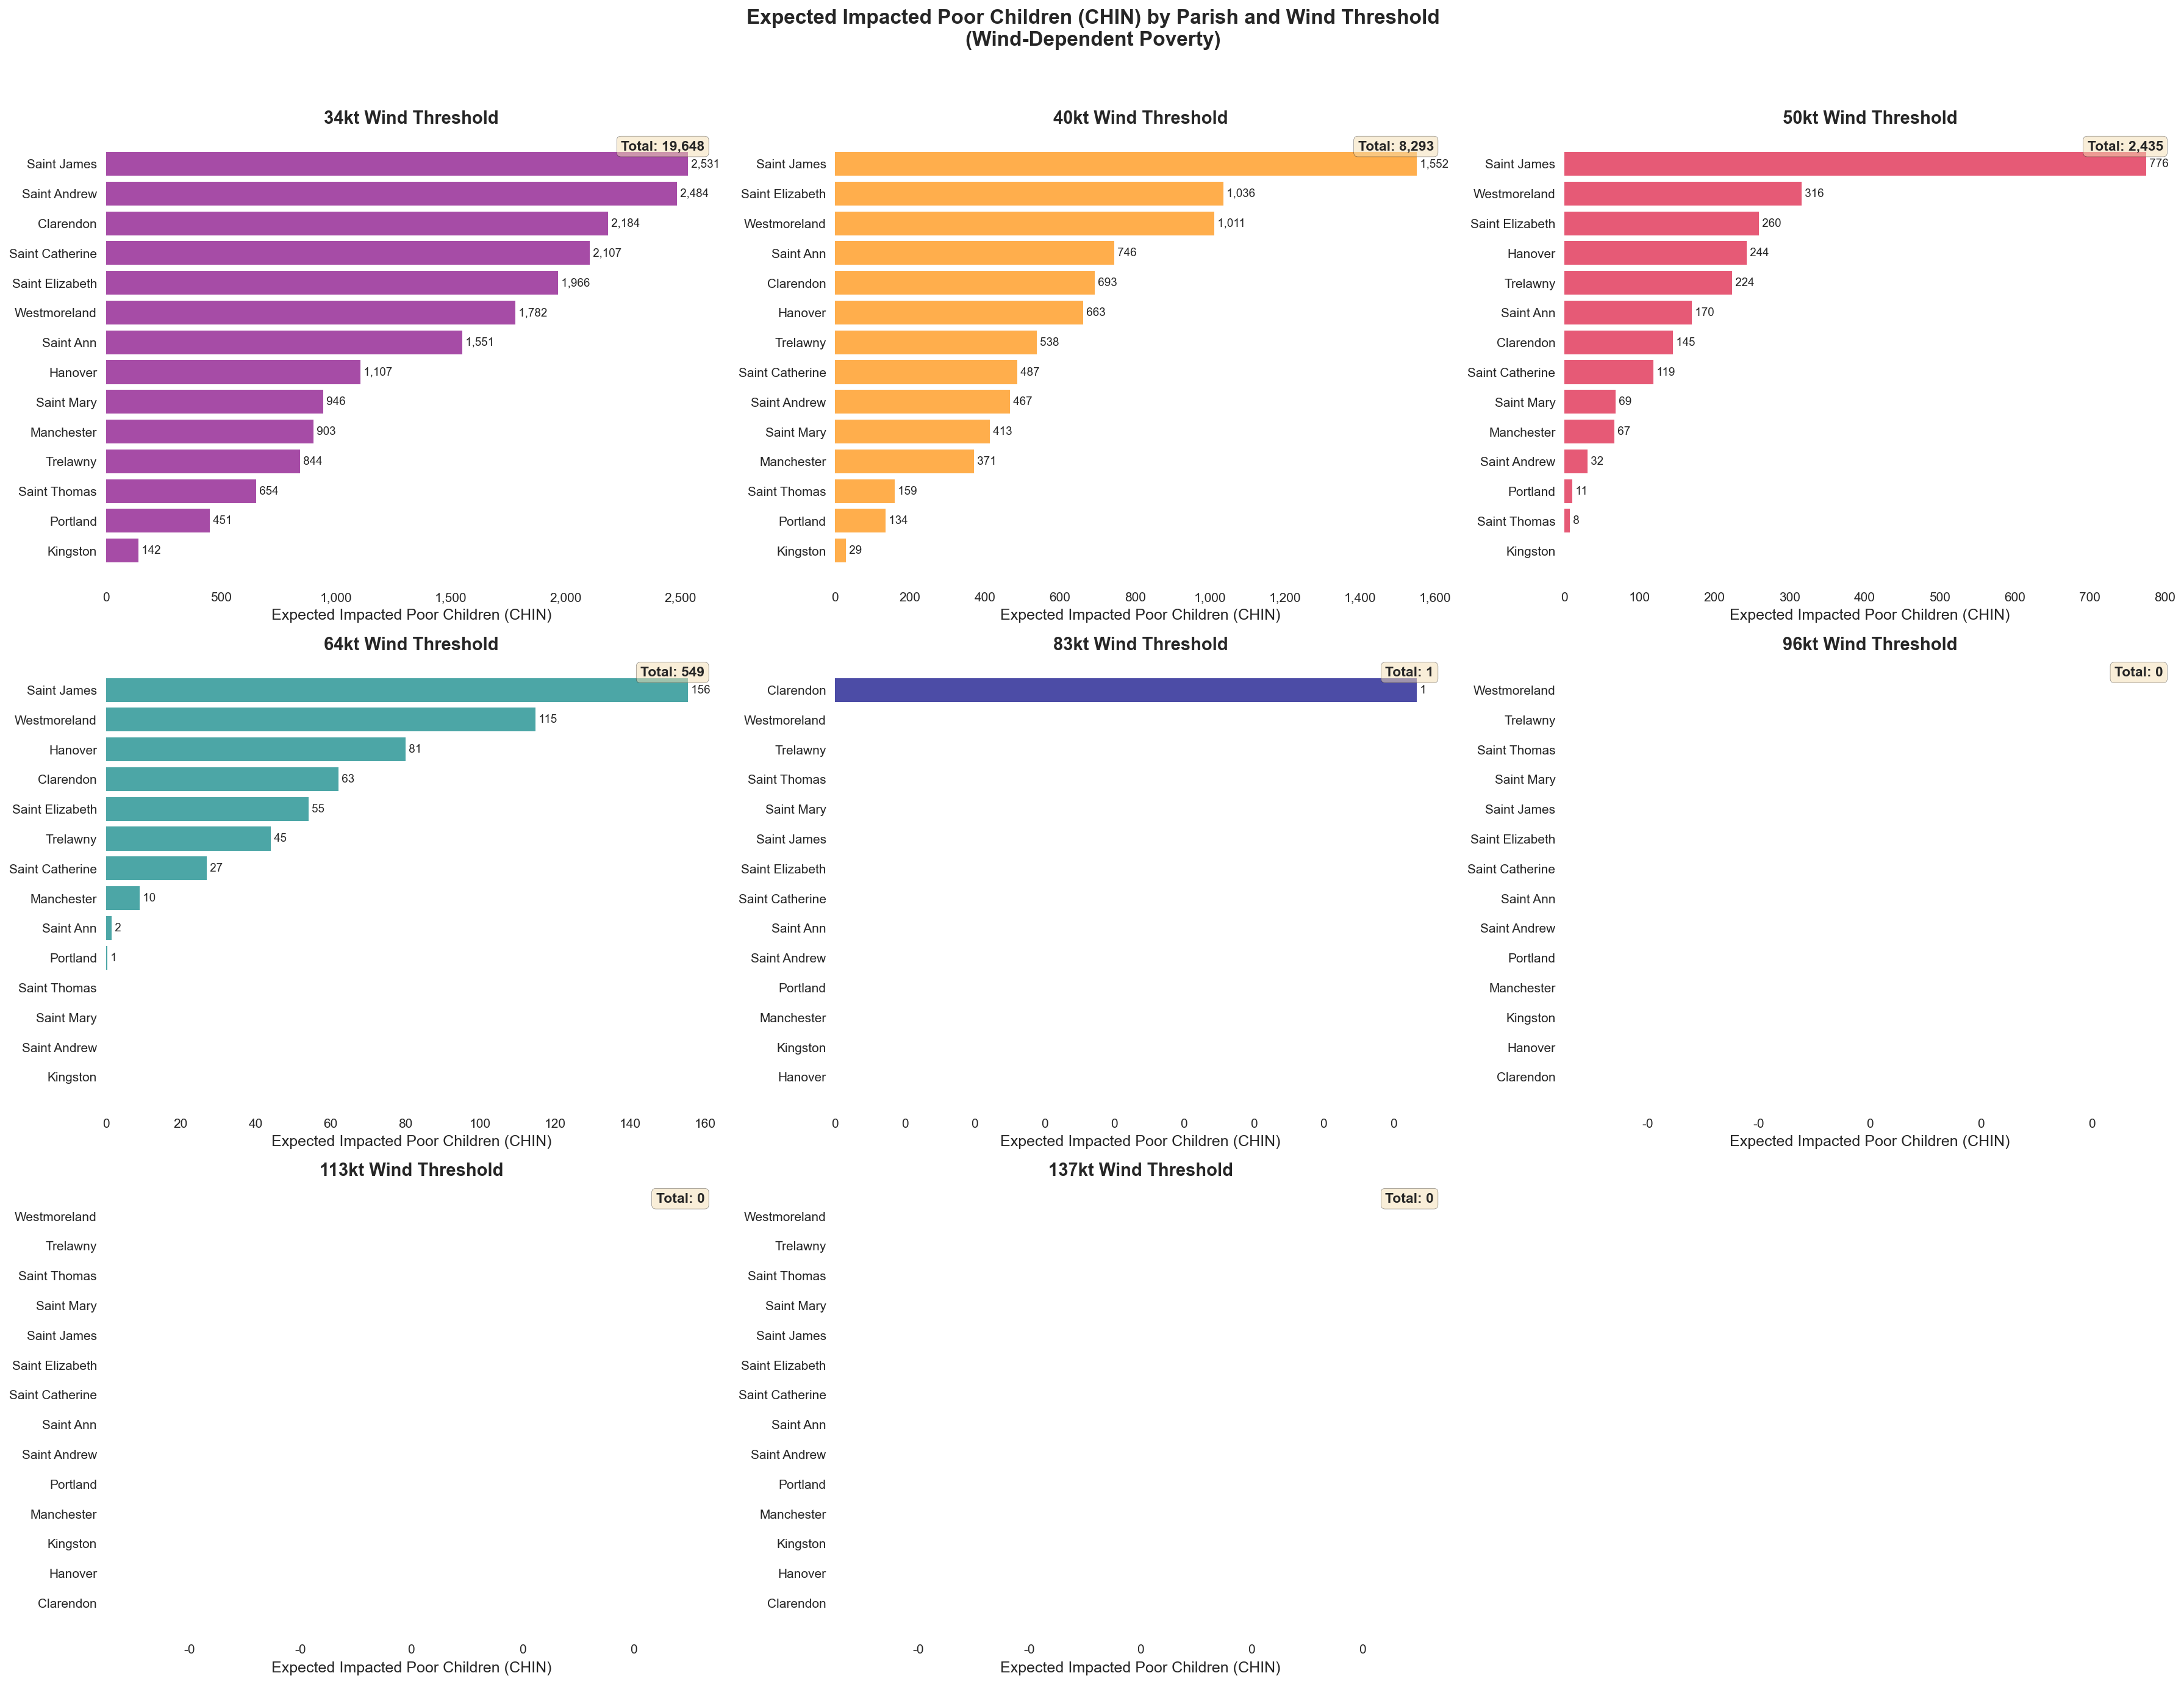

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/expected_impacted_poor_children_chin_comparison_across_wind_thresholds_by_parish.png


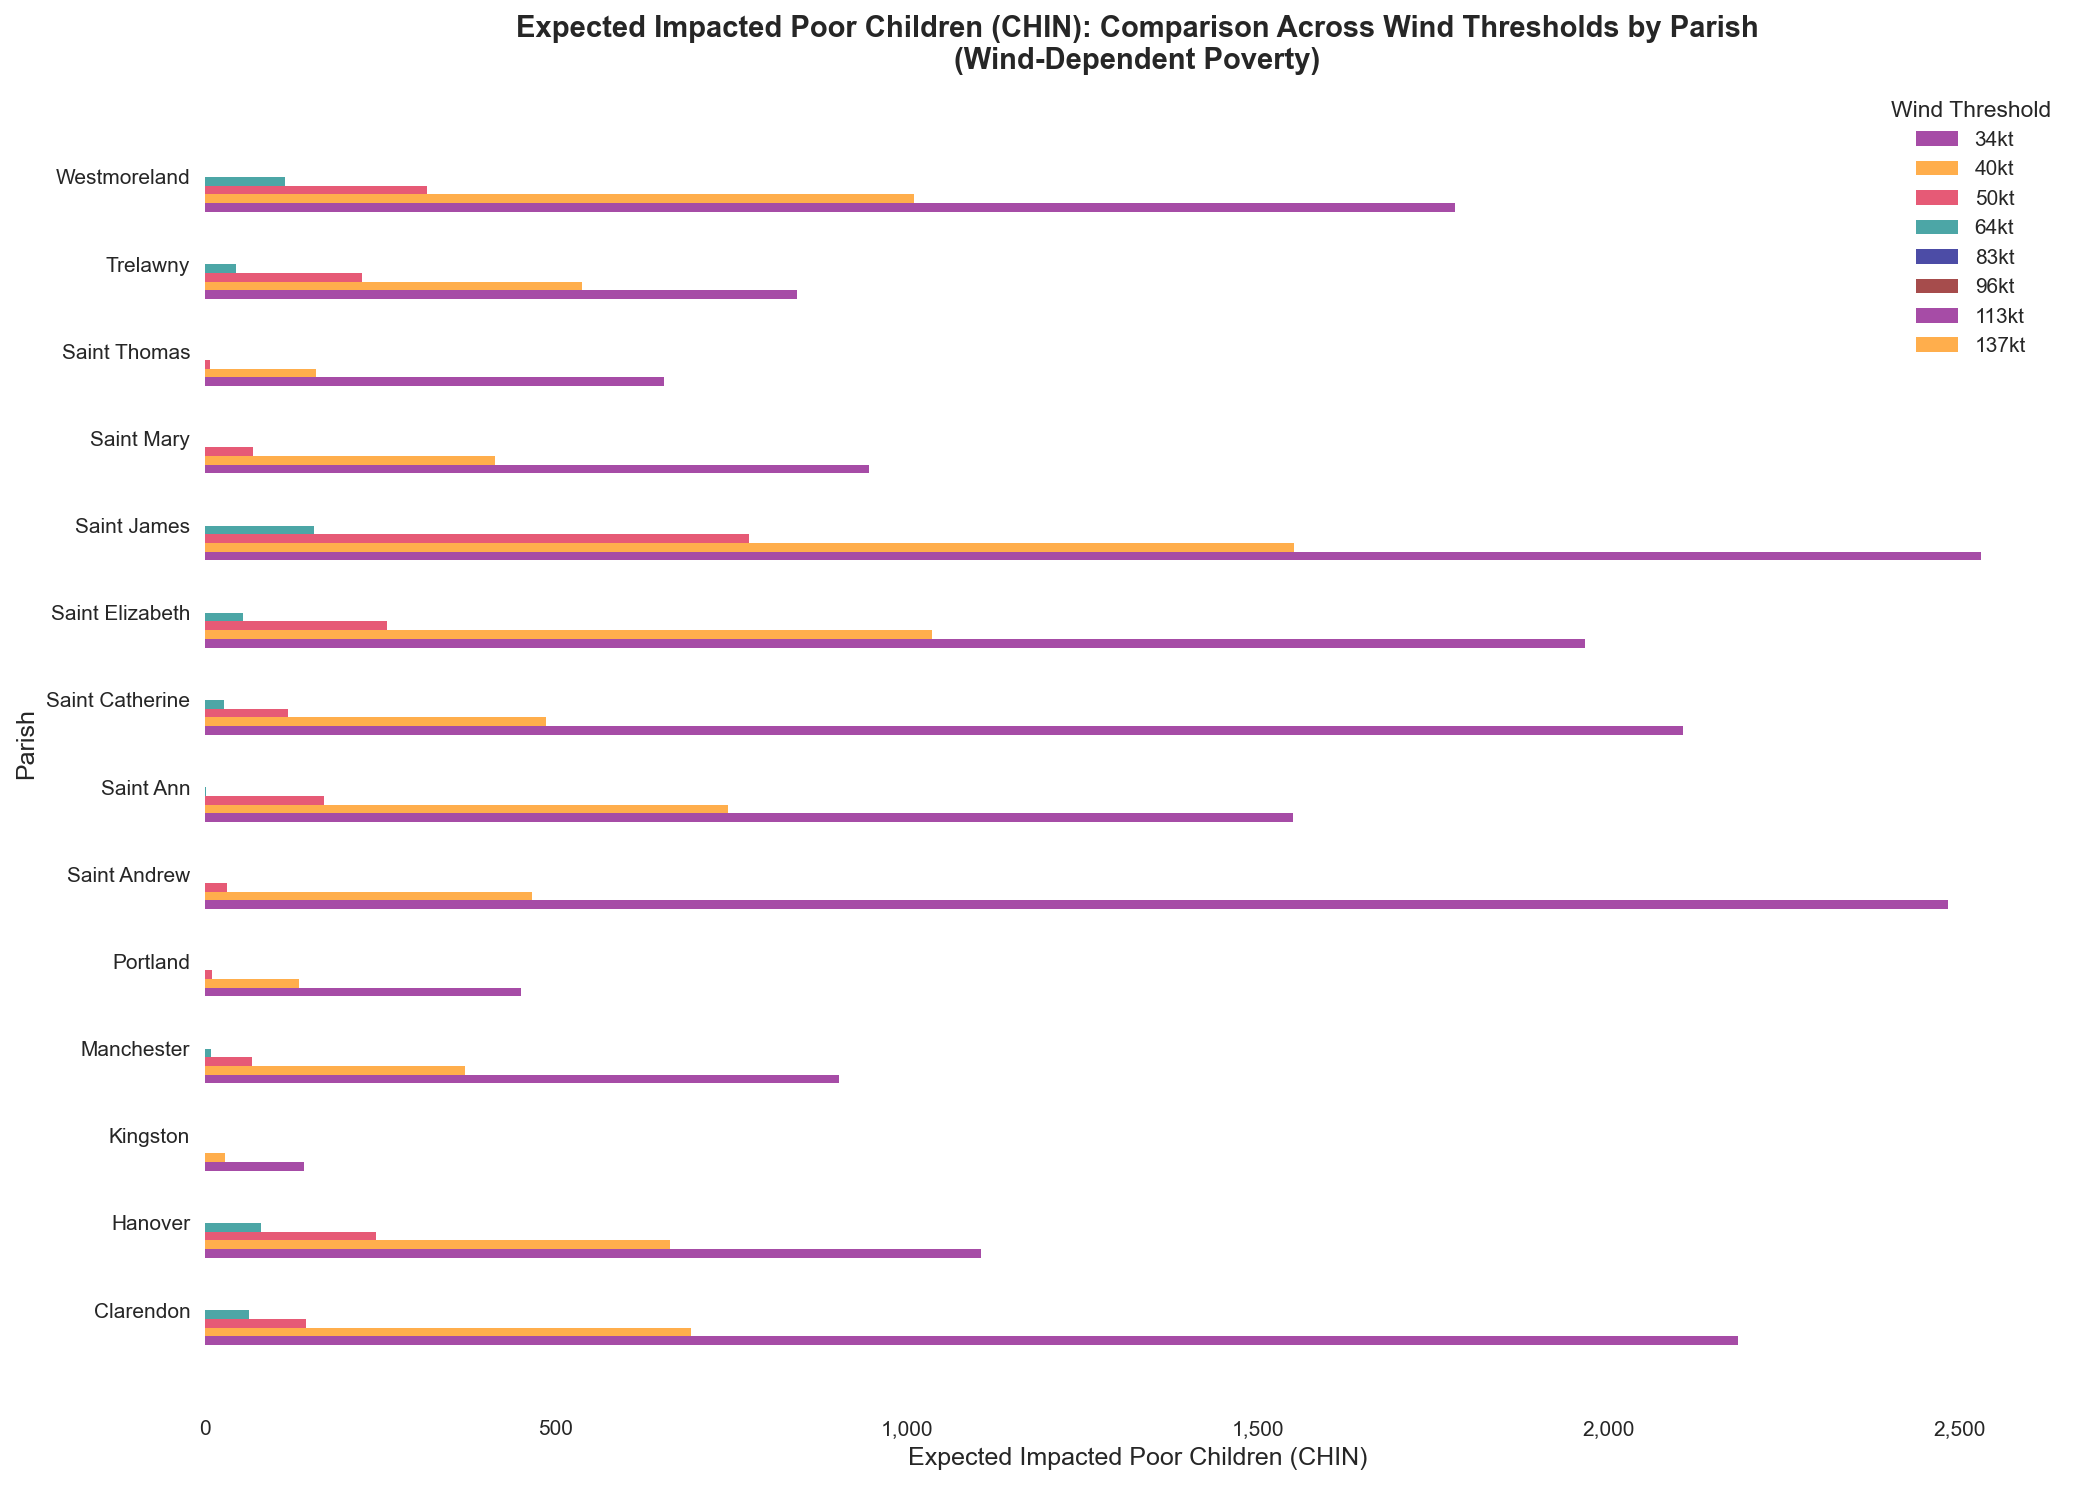

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/34kt_wind_threshold_-_expected_impacted_poor_children_chin_by_parish_wind-depend.png


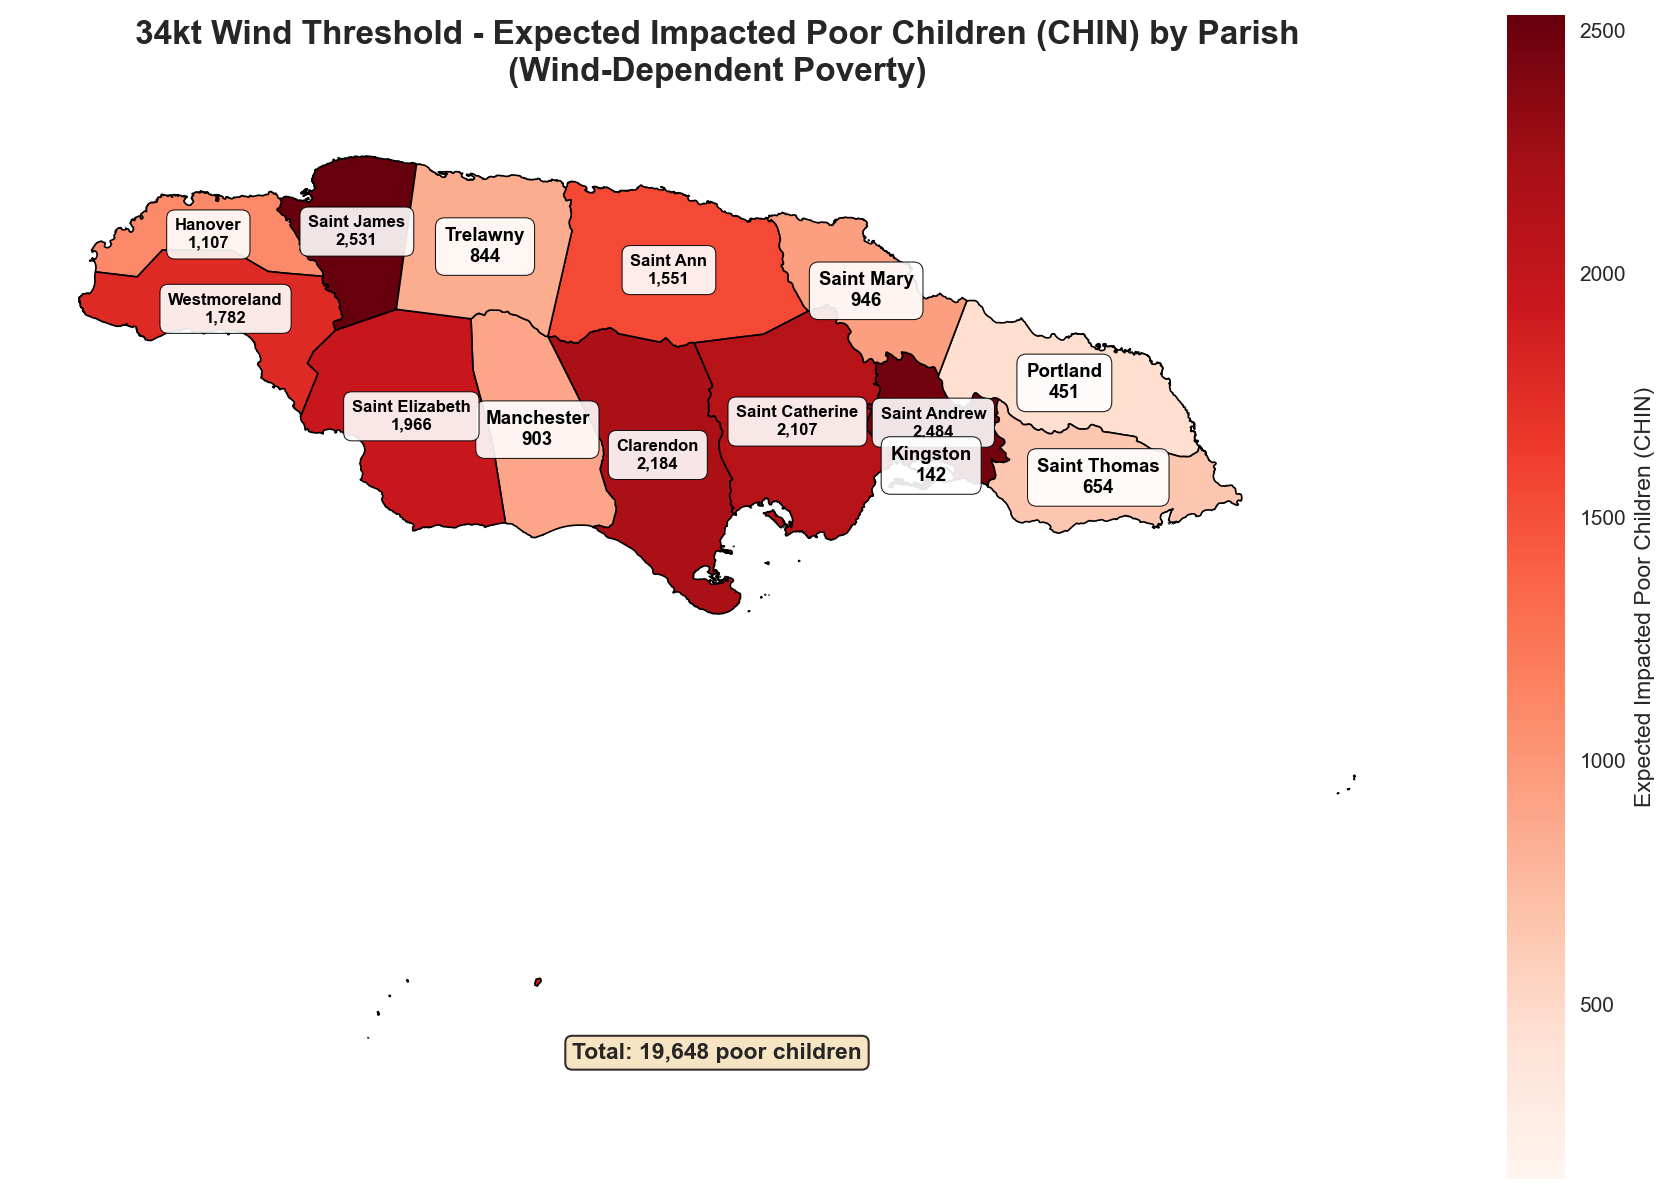

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/40kt_wind_threshold_-_expected_impacted_poor_children_chin_by_parish_wind-depend.png


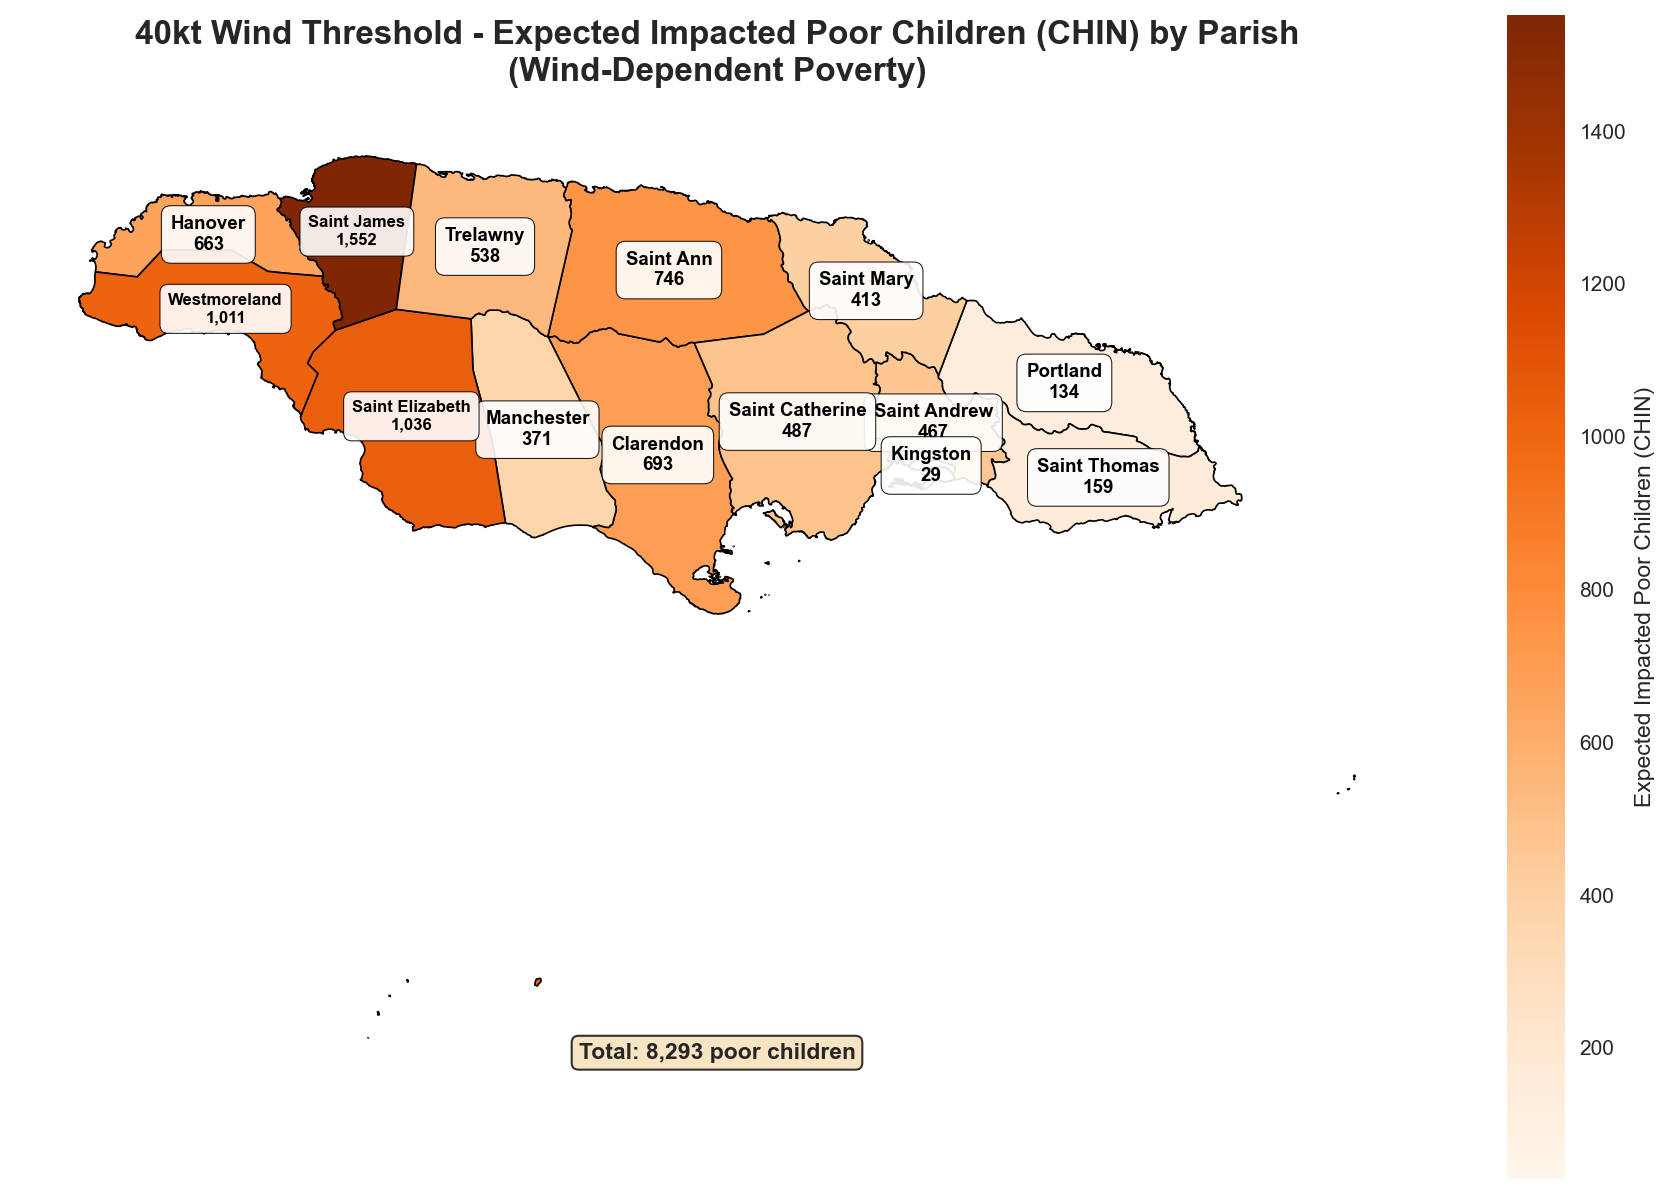

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/50kt_wind_threshold_-_expected_impacted_poor_children_chin_by_parish_wind-depend.png


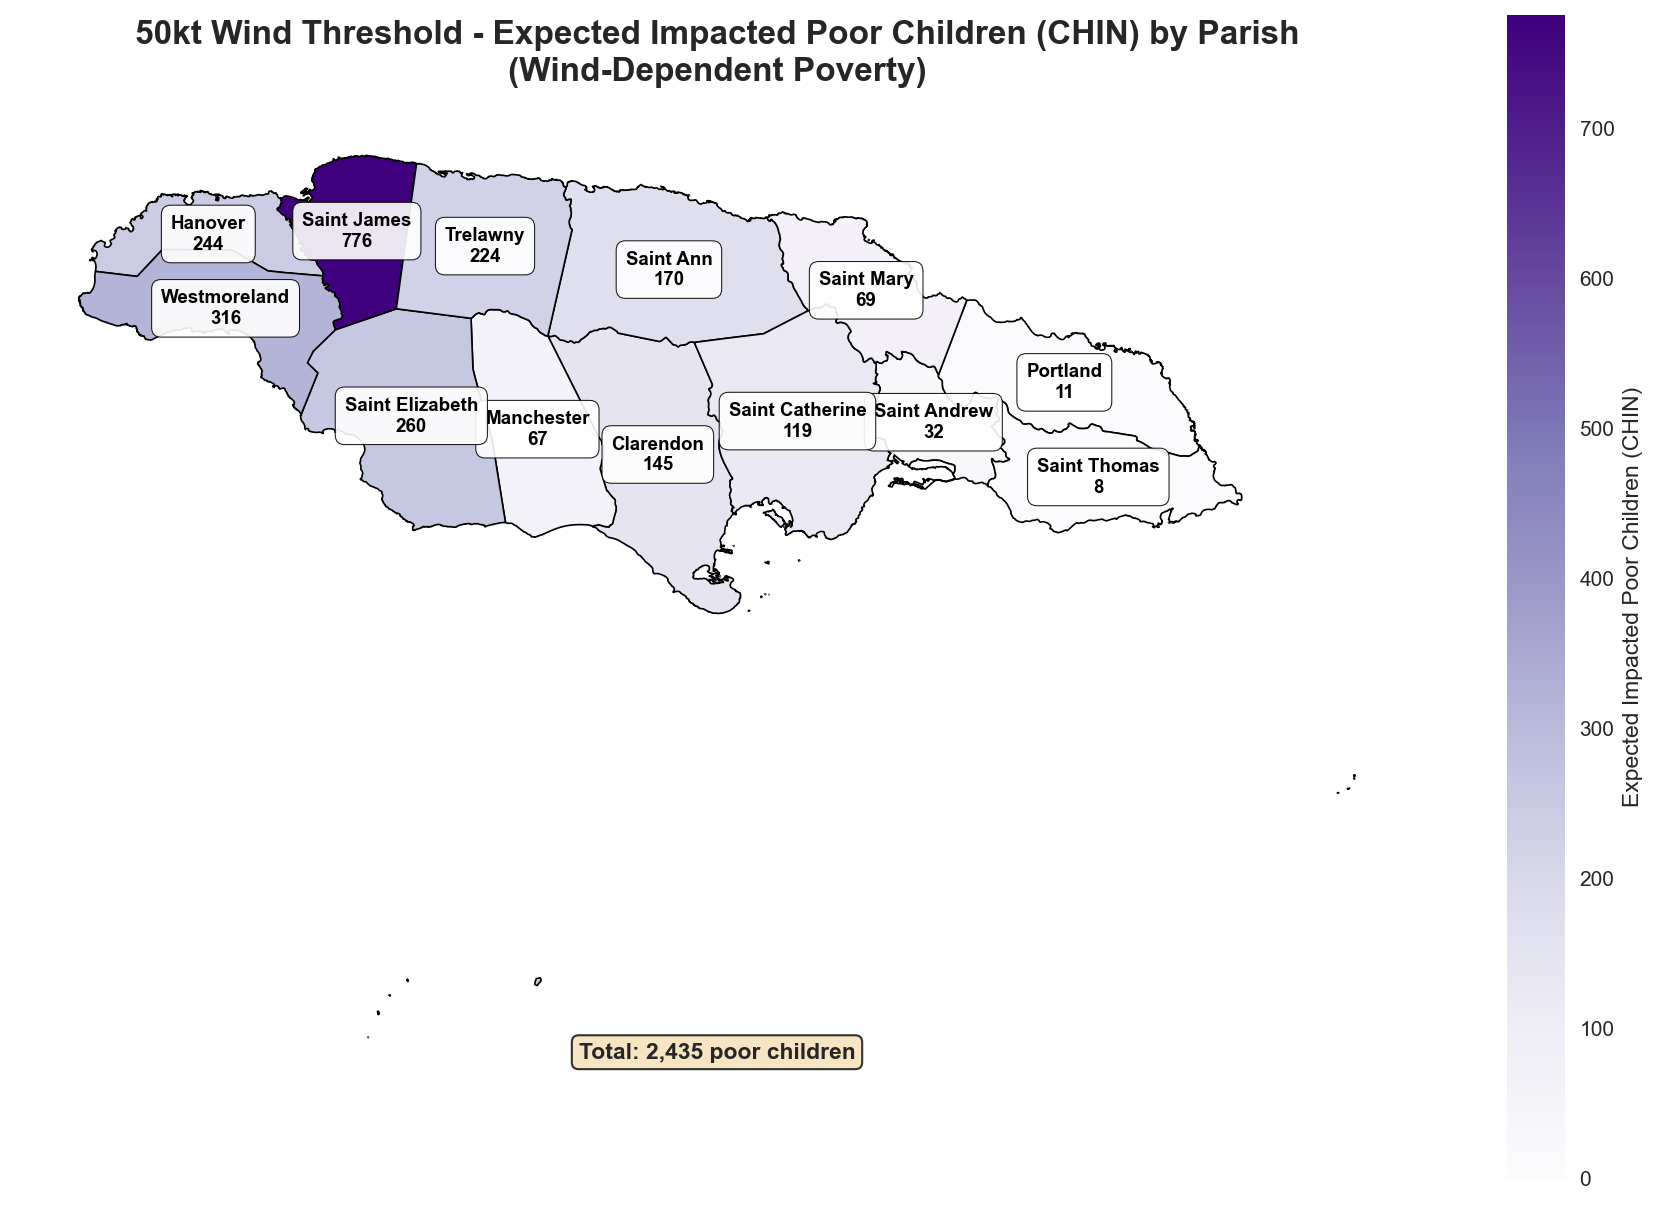

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/64kt_wind_threshold_-_expected_impacted_poor_children_chin_by_parish_wind-depend.png


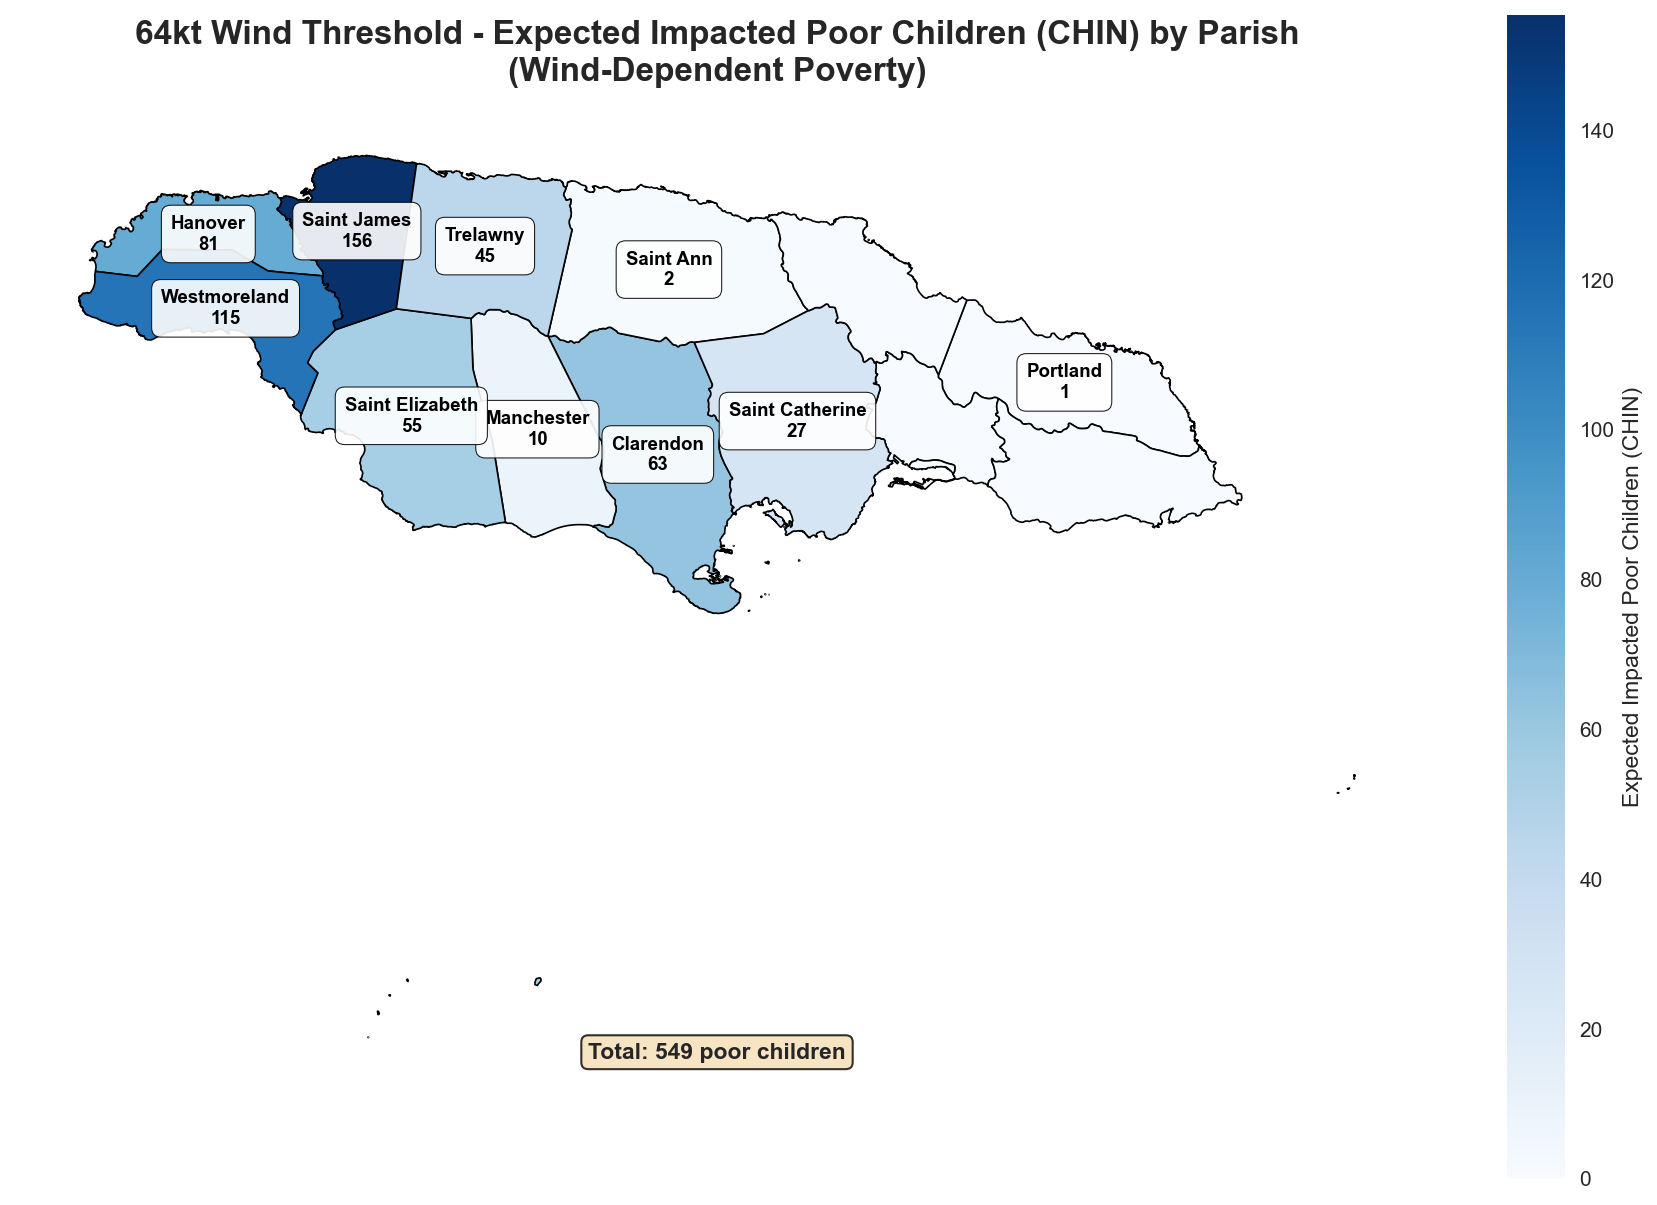

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/83kt_wind_threshold_-_expected_impacted_poor_children_chin_by_parish_wind-depend.png


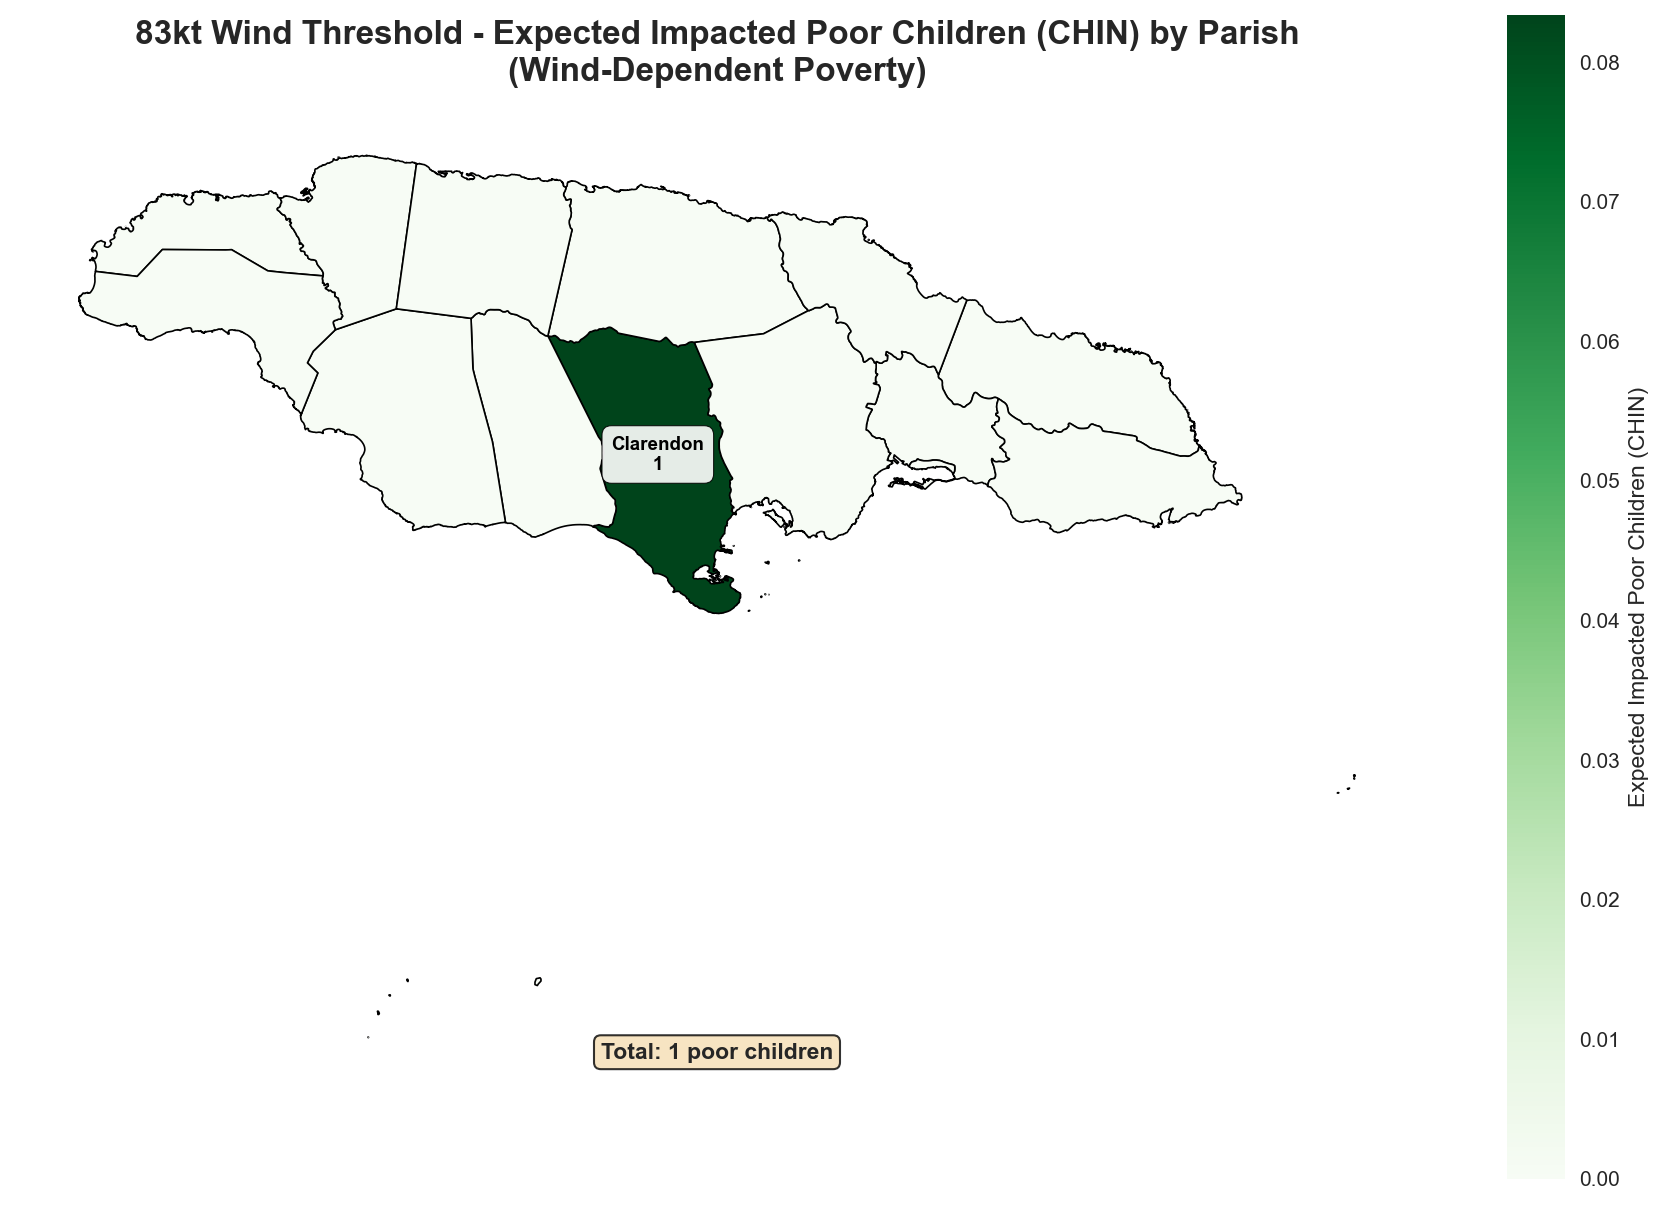

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/96kt_wind_threshold_-_expected_impacted_poor_children_chin_by_parish_wind-depend.png


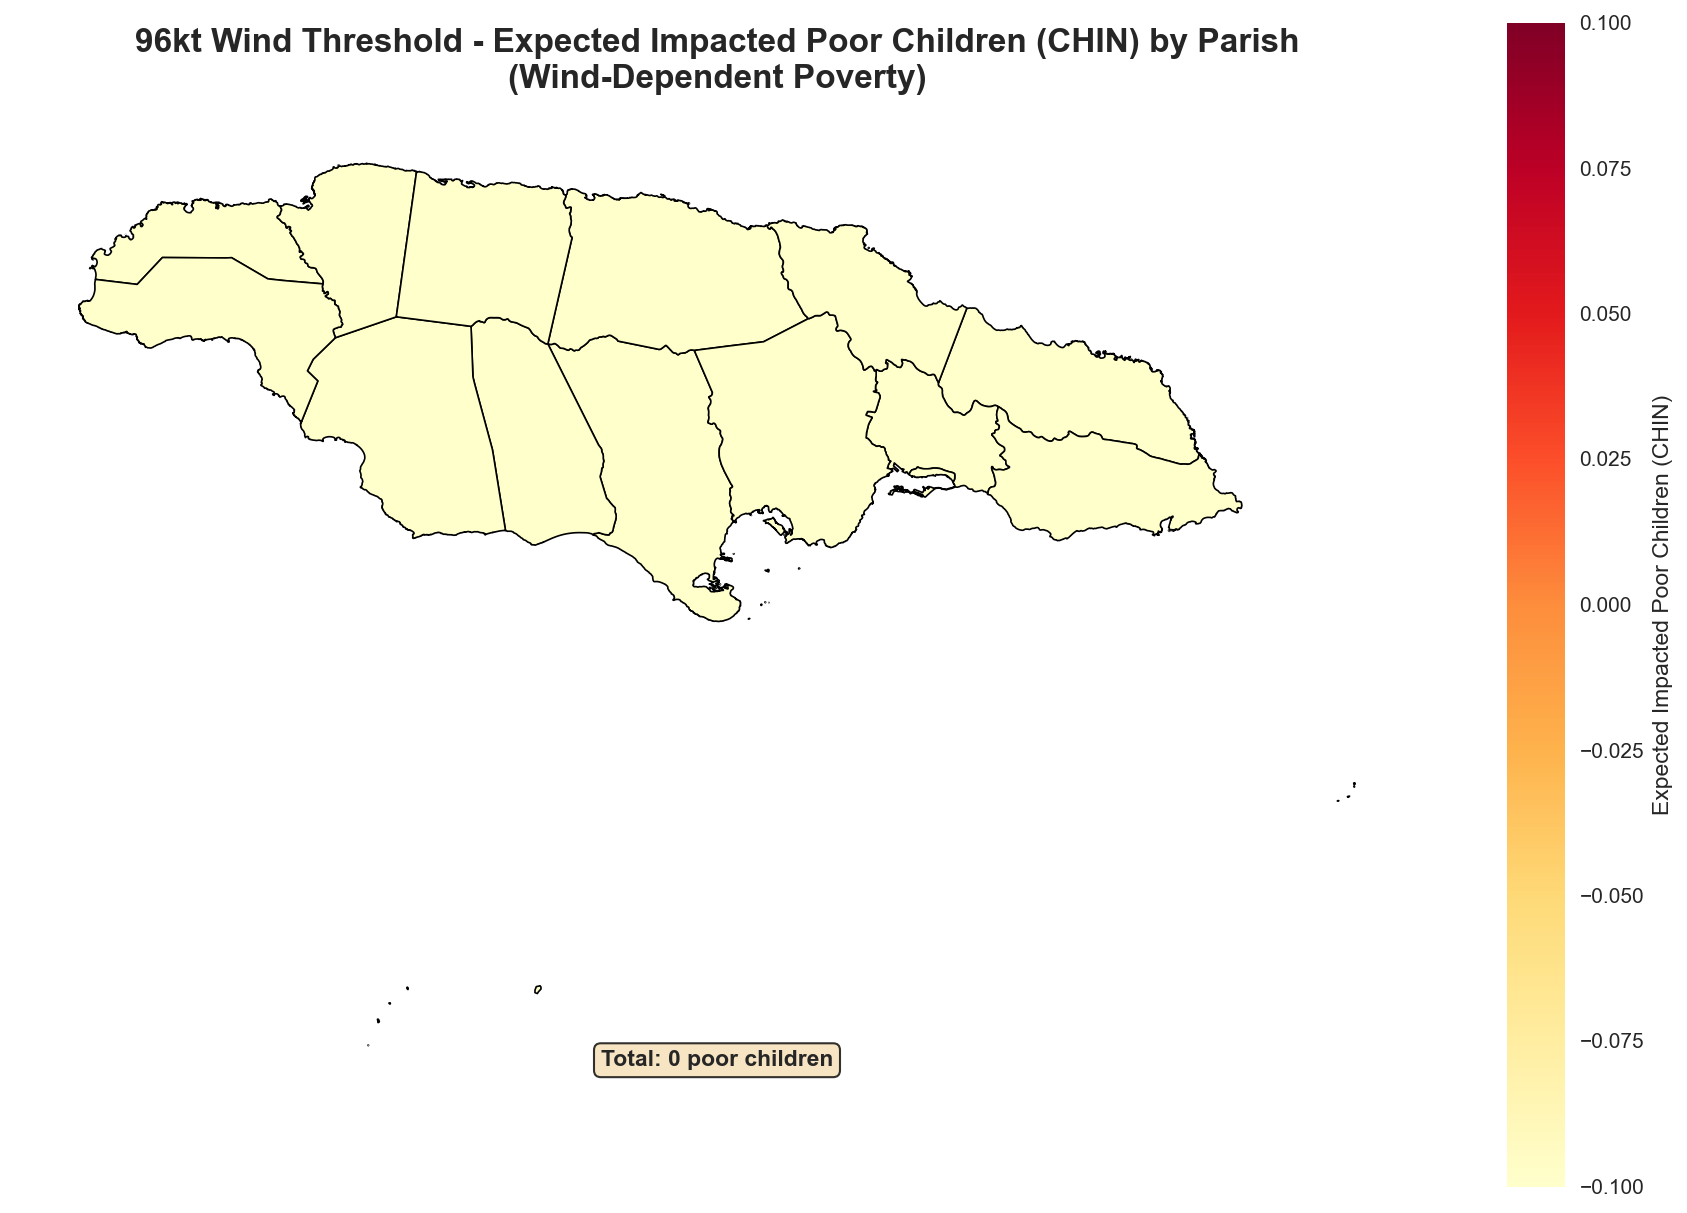

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/113kt_wind_threshold_-_expected_impacted_poor_children_chin_by_parish_wind-depen.png


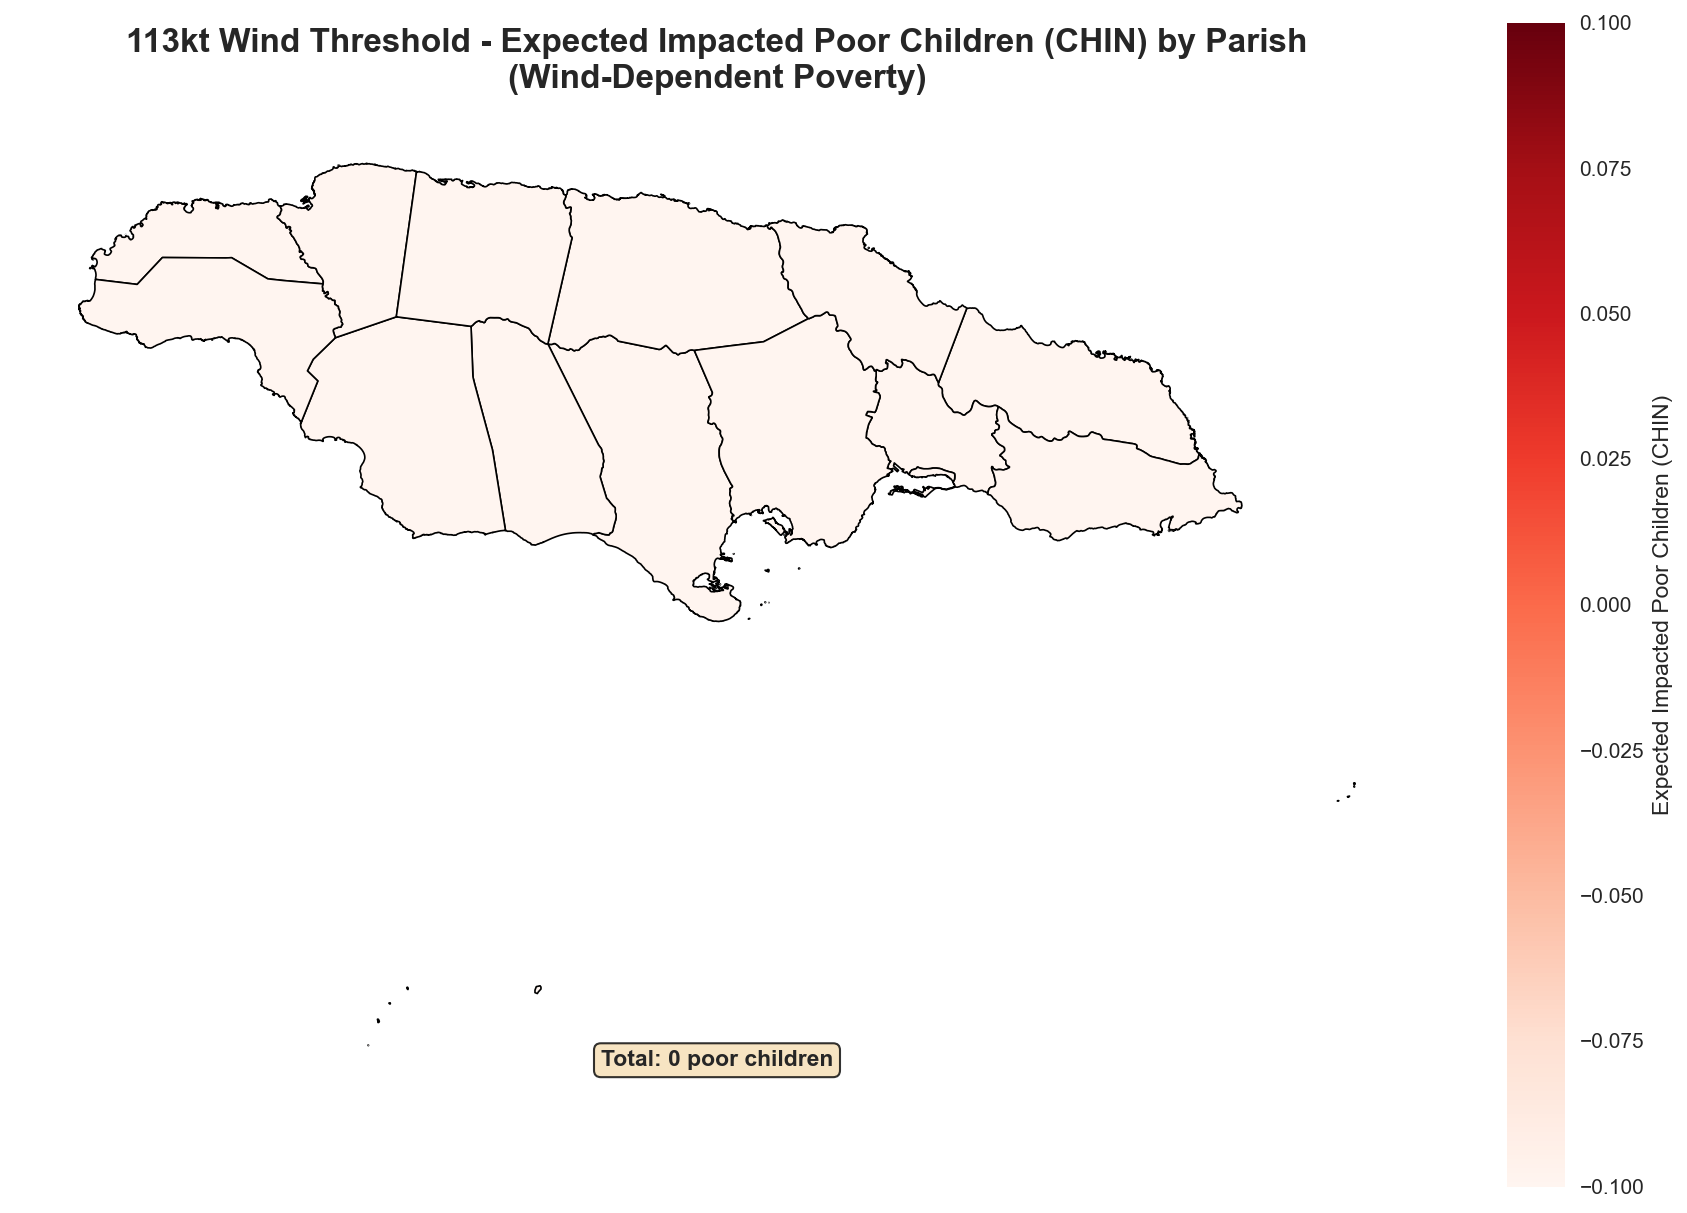

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/137kt_wind_threshold_-_expected_impacted_poor_children_chin_by_parish_wind-depen.png


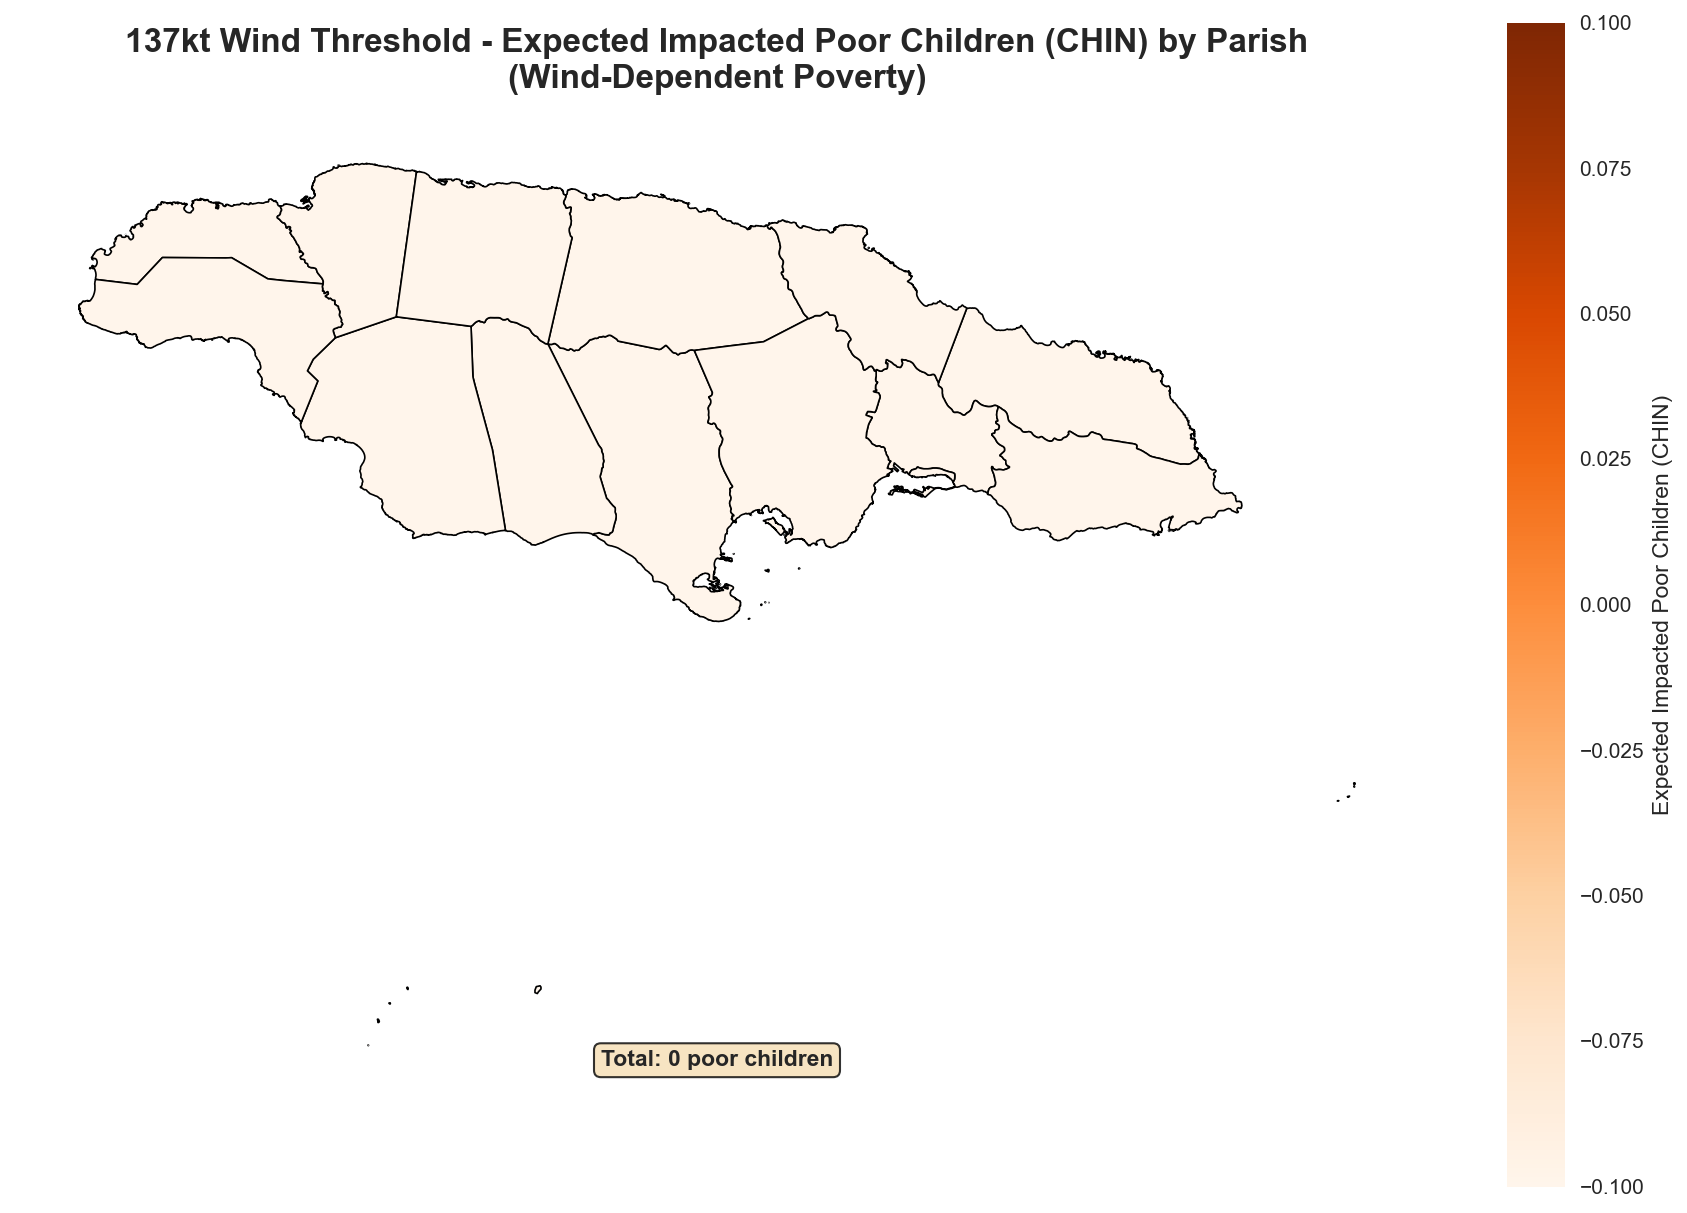

In [17]:
# Expected Impacted Poor Children (CHIN) by Parish and Wind Threshold
# This shows wind-dependent poor children among those affected by different wind thresholds

# Check if we have impact data
has_impact_data = False
impact_cols = []
if 'gdf_tiles_final' in locals():
    for col in gdf_tiles_final.columns:
        if col.startswith('impact_probability_') and col.endswith('kt'):
            has_impact_data = True
            impact_cols.append(col)

if has_impact_data:
    # Aggregate CHIN by parish for each wind threshold
    # CHIN = poor_children_wind_dependent × impact_probability
    parish_chin_summary = []
    
    for parish_name in sorted(gdf_tiles_final['parish'].unique()):
        parish_tiles = gdf_tiles_final[gdf_tiles_final['parish'] == parish_name]
        
        if len(parish_tiles) == 0:
            continue
        
        row = {
            'parish': parish_name,
            'total_tiles': len(parish_tiles),
            'poor_children_wind_dep': parish_tiles['poor_children_wind_dependent'].sum()
        }
        
        # Calculate CHIN for each threshold - compute fresh at tile level for accuracy
        for col in impact_cols:
            threshold = col.replace('impact_probability_', '').replace('kt', '')
            chin_col = f'chin_{threshold}kt'
            # CHIN = poor_children_wind_dependent × impact_probability
            if col in parish_tiles.columns:
                row[chin_col] = (parish_tiles['poor_children_wind_dependent'].fillna(0) * parish_tiles[col].fillna(0)).sum()
            else:
                row[chin_col] = 0
        
        parish_chin_summary.append(row)
    
    df_parish_chin = pd.DataFrame(parish_chin_summary)
    
    print(f"\nParish CHIN Summary (Wind-Dependent Poor Children Among Affected):")
    print(df_parish_chin[['parish', 'total_tiles', 'poor_children_wind_dep']].to_string(index=False))
    
    # Create visualizations per parish for each wind threshold
    chin_cols = [col for col in df_parish_chin.columns if col.startswith('chin_')]
    
    if chin_cols:
        # Determine layout based on number of thresholds
        n_thresholds = len(chin_cols)
        
        if n_thresholds == 1:
            fig, axes = plt.subplots(1, 1, figsize=(14, 10))
            axes = [axes]
        elif n_thresholds == 2:
            fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        elif n_thresholds == 3:
            fig, axes = plt.subplots(1, 3, figsize=(24, 10))
        else:
            n_cols = 3
            n_rows = (n_thresholds + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows))
            axes = axes.flatten()
        
        colors = ['purple', 'darkorange', 'crimson', 'teal', 'navy', 'maroon']
        
        for idx, chin_col in enumerate(chin_cols):
            ax = axes[idx]
            threshold = chin_col.replace('chin_', '').replace('kt', '')
            
            # Sort by CHIN
            df_plot = df_parish_chin.sort_values(chin_col, ascending=True)
            
            # Create horizontal bar chart
            bars = ax.barh(df_plot['parish'], df_plot[chin_col], color=colors[idx % len(colors)], alpha=0.7)
            
            # Add value labels on bars (round up)
            for i, (bar, val) in enumerate(zip(bars, df_plot[chin_col])):
                if val > 0:
                    ax.text(val, i, f' {np.ceil(val):,.0f}', va='center', fontsize=9)
            
            ax.set_xlabel('Expected Impacted Poor Children (CHIN)', fontsize=12)
            ax.set_title(f'{threshold}kt Wind Threshold', fontsize=14, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
            
            # Add total at the top (round up)
            total = df_parish_chin[chin_col].sum()
            ax.text(0.98, 0.98, f'Total: {np.ceil(total):,.0f}', 
                   transform=ax.transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=11, fontweight='bold')
        
        # Hide unused subplots
        for idx in range(n_thresholds, len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle('Expected Impacted Poor Children (CHIN) by Parish and Wind Threshold\n(Wind-Dependent Poverty)',
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Create side-by-side comparison
        fig, ax = plt.subplots(figsize=(14, 10))
        
        parishes = df_parish_chin['parish'].values
        x = np.arange(len(parishes))
        width = 0.8 / n_thresholds
        
        for idx, chin_col in enumerate(chin_cols):
            threshold = chin_col.replace('chin_', '').replace('kt', '')
            values = df_parish_chin[chin_col].values
            offset = (idx - (n_thresholds - 1) / 2) * width
            ax.barh(x + offset, values, width, label=f'{threshold}kt', 
                   color=colors[idx % len(colors)], alpha=0.7)
        
        ax.set_xlabel('Expected Impacted Poor Children (CHIN)', fontsize=12)
        ax.set_ylabel('Parish', fontsize=12)
        ax.set_title('Expected Impacted Poor Children (CHIN): Comparison Across Wind Thresholds by Parish\n(Wind-Dependent Poverty)',
                    fontsize=14, fontweight='bold')
        ax.set_yticks(x)
        ax.set_yticklabels(parishes)
        ax.legend(title='Wind Threshold', fontsize=10, title_fontsize=11)
        ax.grid(axis='x', alpha=0.3)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        
        plt.tight_layout()
        plt.show()

        # Create map visualizations for CHIN by parish
        
        if 'gdf_admin' not in locals() or gdf_admin is None:
            admin_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "admin_views", f"{COUNTRY}_admin1.parquet")
            if os.path.exists(admin_base_path):
                gdf_admin = gpd.read_parquet(admin_base_path)
                print(f"Loaded admin boundaries: {len(gdf_admin)} parishes")
            else:
                print(f"Warning: Admin boundaries file not found at {admin_base_path}")
                gdf_admin = None
        
        # Join CHIN data to admin boundaries for mapping
        if gdf_admin is not None:
            gdf_admin_chin = gdf_admin.merge(df_parish_chin, left_on='name', right_on='parish', how='left')
            
            colormaps = ['Reds', 'Oranges', 'Purples', 'Blues', 'Greens', 'YlOrRd']
            
            # Create separate map visualization for each wind threshold
            for idx, chin_col in enumerate(chin_cols):
                threshold = chin_col.replace('chin_', '').replace('kt', '')
                
                # Create a separate figure for each threshold
                fig, ax = plt.subplots(1, 1, figsize=(12, 10))
                
                # Plot admin boundaries colored by CHIN
                gdf_admin_chin.plot(
                    ax=ax,
                    column=chin_col,
                    cmap=colormaps[idx % len(colormaps)],
                    edgecolor='black',
                    linewidth=0.8,
                    legend=True,
                    legend_kwds={
                        'label': 'Expected Impacted Poor Children (CHIN)',
                        'shrink': 0.8
                    },
                    missing_kwds={
                        'color': 'lightgray',
                        'edgecolor': 'black',
                        'hatch': '///',
                        'label': 'No data'
                    }
                )
                
                # Add parish labels (round up, display if value > 0)
                if chin_col in gdf_admin_chin.columns:
                    label_count = 0
                    for idx_parish, row in gdf_admin_chin.iterrows():
                        val = row[chin_col]
                        # Check if value exists and is greater than 0
                        if pd.notna(val) and val > 0:
                            centroid = row.geometry.centroid
                            rounded_val = np.ceil(val)
                            # Only display if rounded value is at least 1
                            if rounded_val >= 1:
                                # Use larger font for better visibility, especially for larger numbers
                                font_size = 9 if rounded_val < 1000 else 8
                                ax.text(
                                    centroid.x, centroid.y,
                                    f"{row['name']}\n{rounded_val:,.0f}",
                                    ha='center', va='center',
                                    fontsize=font_size,
                                    fontweight='bold',
                                    color='black',
                                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='black', linewidth=0.5)
                                )
                                label_count += 1
                
                ax.set_title(f'{threshold}kt Wind Threshold - Expected Impacted Poor Children (CHIN) by Parish\n(Wind-Dependent Poverty)', 
                           fontsize=16, fontweight='bold', pad=15)
                ax.set_xlabel('Longitude', fontsize=11)
                ax.set_ylabel('Latitude', fontsize=11)
                ax.axis('off')
                
                # Add total at the bottom (round up)
                total = gdf_admin_chin[chin_col].sum() if chin_col in gdf_admin_chin.columns else 0
                ax.text(0.5, 0.02, f'Total: {np.ceil(total):,.0f} poor children', 
                       transform=ax.transAxes, ha='center', va='bottom',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1),
                       fontsize=11, fontweight='bold')
                
                plt.tight_layout()
                plt.show()
        else:
            print("Skipping map visualization - admin boundaries not available")
        
    else:
        print("No impact probability columns found in parish data")
else:
    print("No impact probability data available for parish-level visualization")


## Map Visualizations

Spatial distribution of wind-dependent poor children (CHIN) across Jamaica.

  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/wind-dependent_poor_children_distribution_per_tile_chin__wind-dependent_poverty_.png


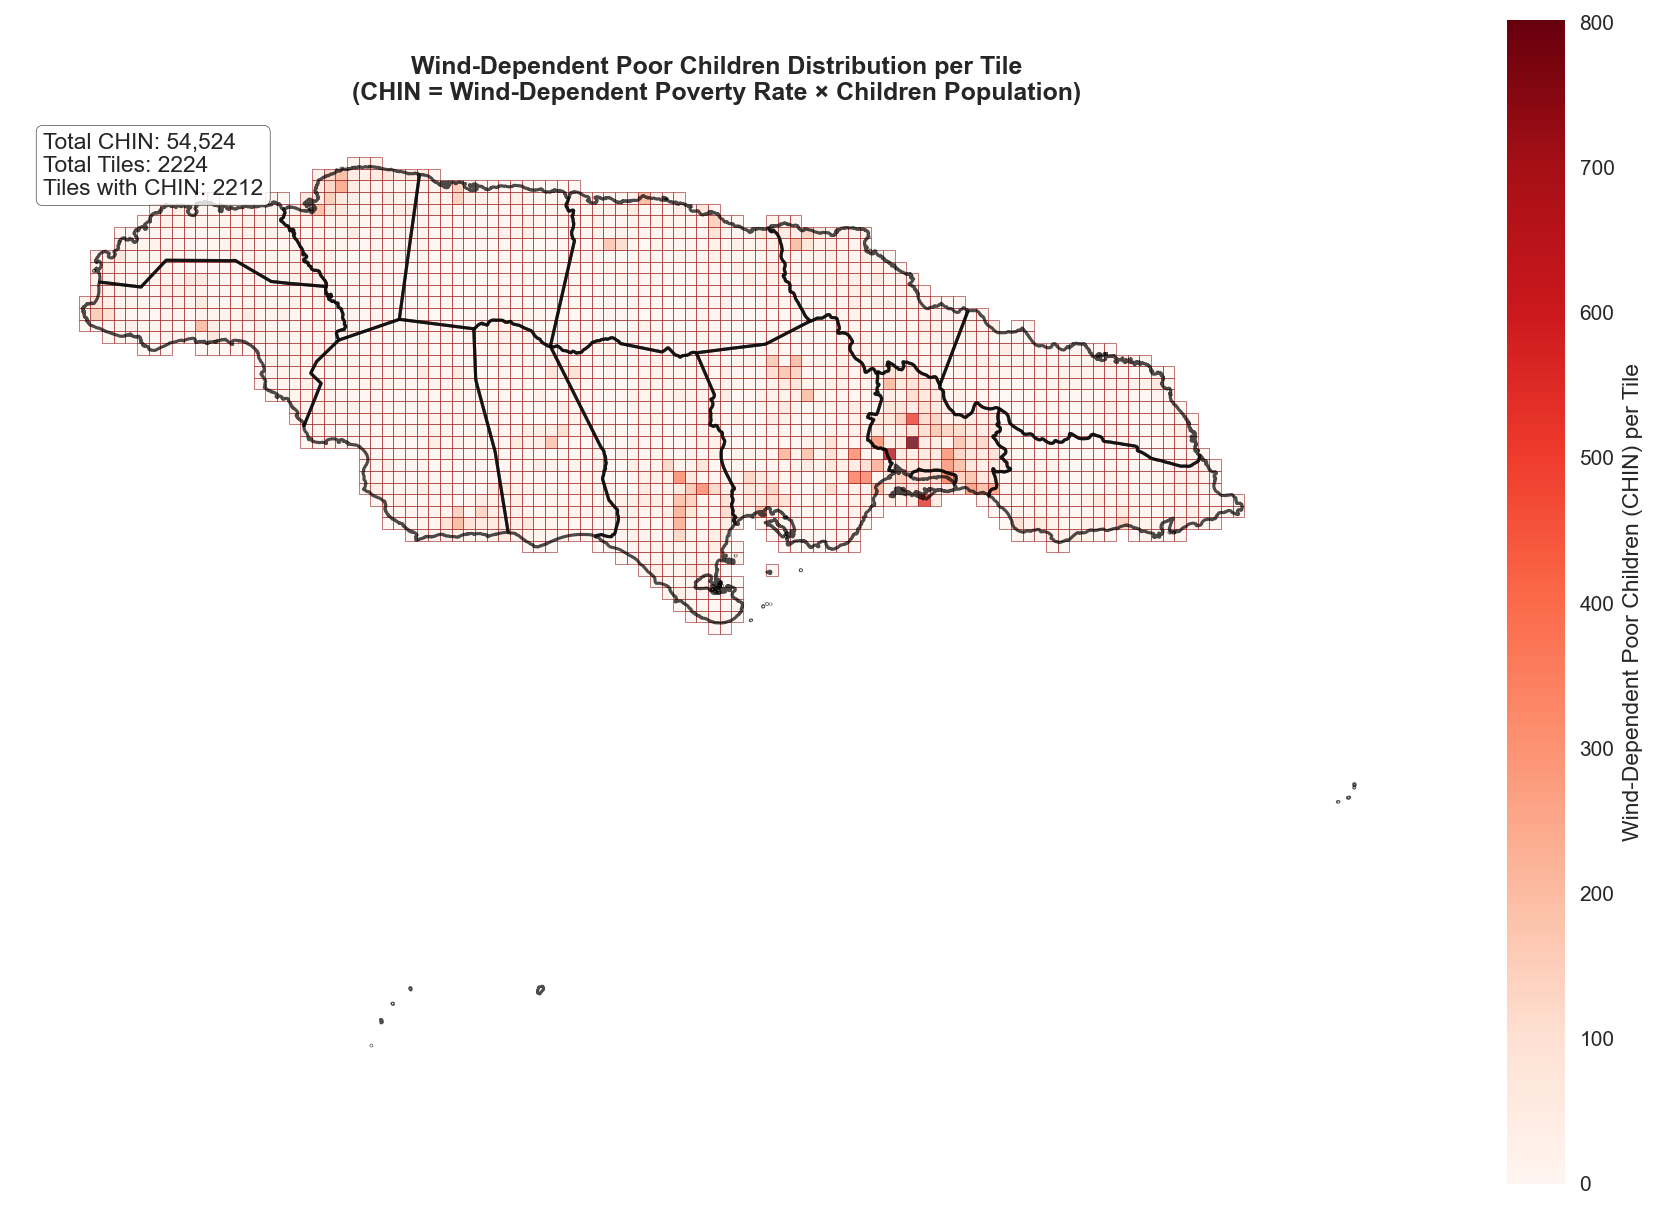

In [18]:
# Create simple map showing wind-dependent poor children per tile
fig, ax = plt.subplots(figsize=(12, 10))

gdf_tiles_final.plot(
    column='poor_children_wind_dependent',
    cmap='Reds',  # Red = More Poor Children
    legend=True,
    legend_kwds={'label': 'Wind-Dependent Poor Children (CHIN) per Tile', 'shrink': 0.8},
    ax=ax,
    alpha=0.8,
    edgecolor='darkred',
    linewidth=0.3
)

# Plot admin boundaries if available
if 'gdf_admin' in locals() and gdf_admin is not None:
    gdf_admin.plot(ax=ax, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)

ax.set_title("Wind-Dependent Poor Children Distribution per Tile\n(CHIN = Wind-Dependent Poverty Rate × Children Population)", 
             fontsize=12, fontweight='bold')
ax.axis('off')

# Add summary statistics
total_poor = gdf_tiles_final['poor_children_wind_dependent'].sum()
total_tiles = len(gdf_tiles_final)
tiles_with_poor = (gdf_tiles_final['poor_children_wind_dependent'] > 0).sum()

ax.text(0.02, 0.98, 
        f'Total CHIN: {total_poor:,.0f}\nTotal Tiles: {total_tiles}\nTiles with CHIN: {tiles_with_poor}',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/spatial_distribution_comparison_wind-dependent_vs_baseline_poverty_rates.png


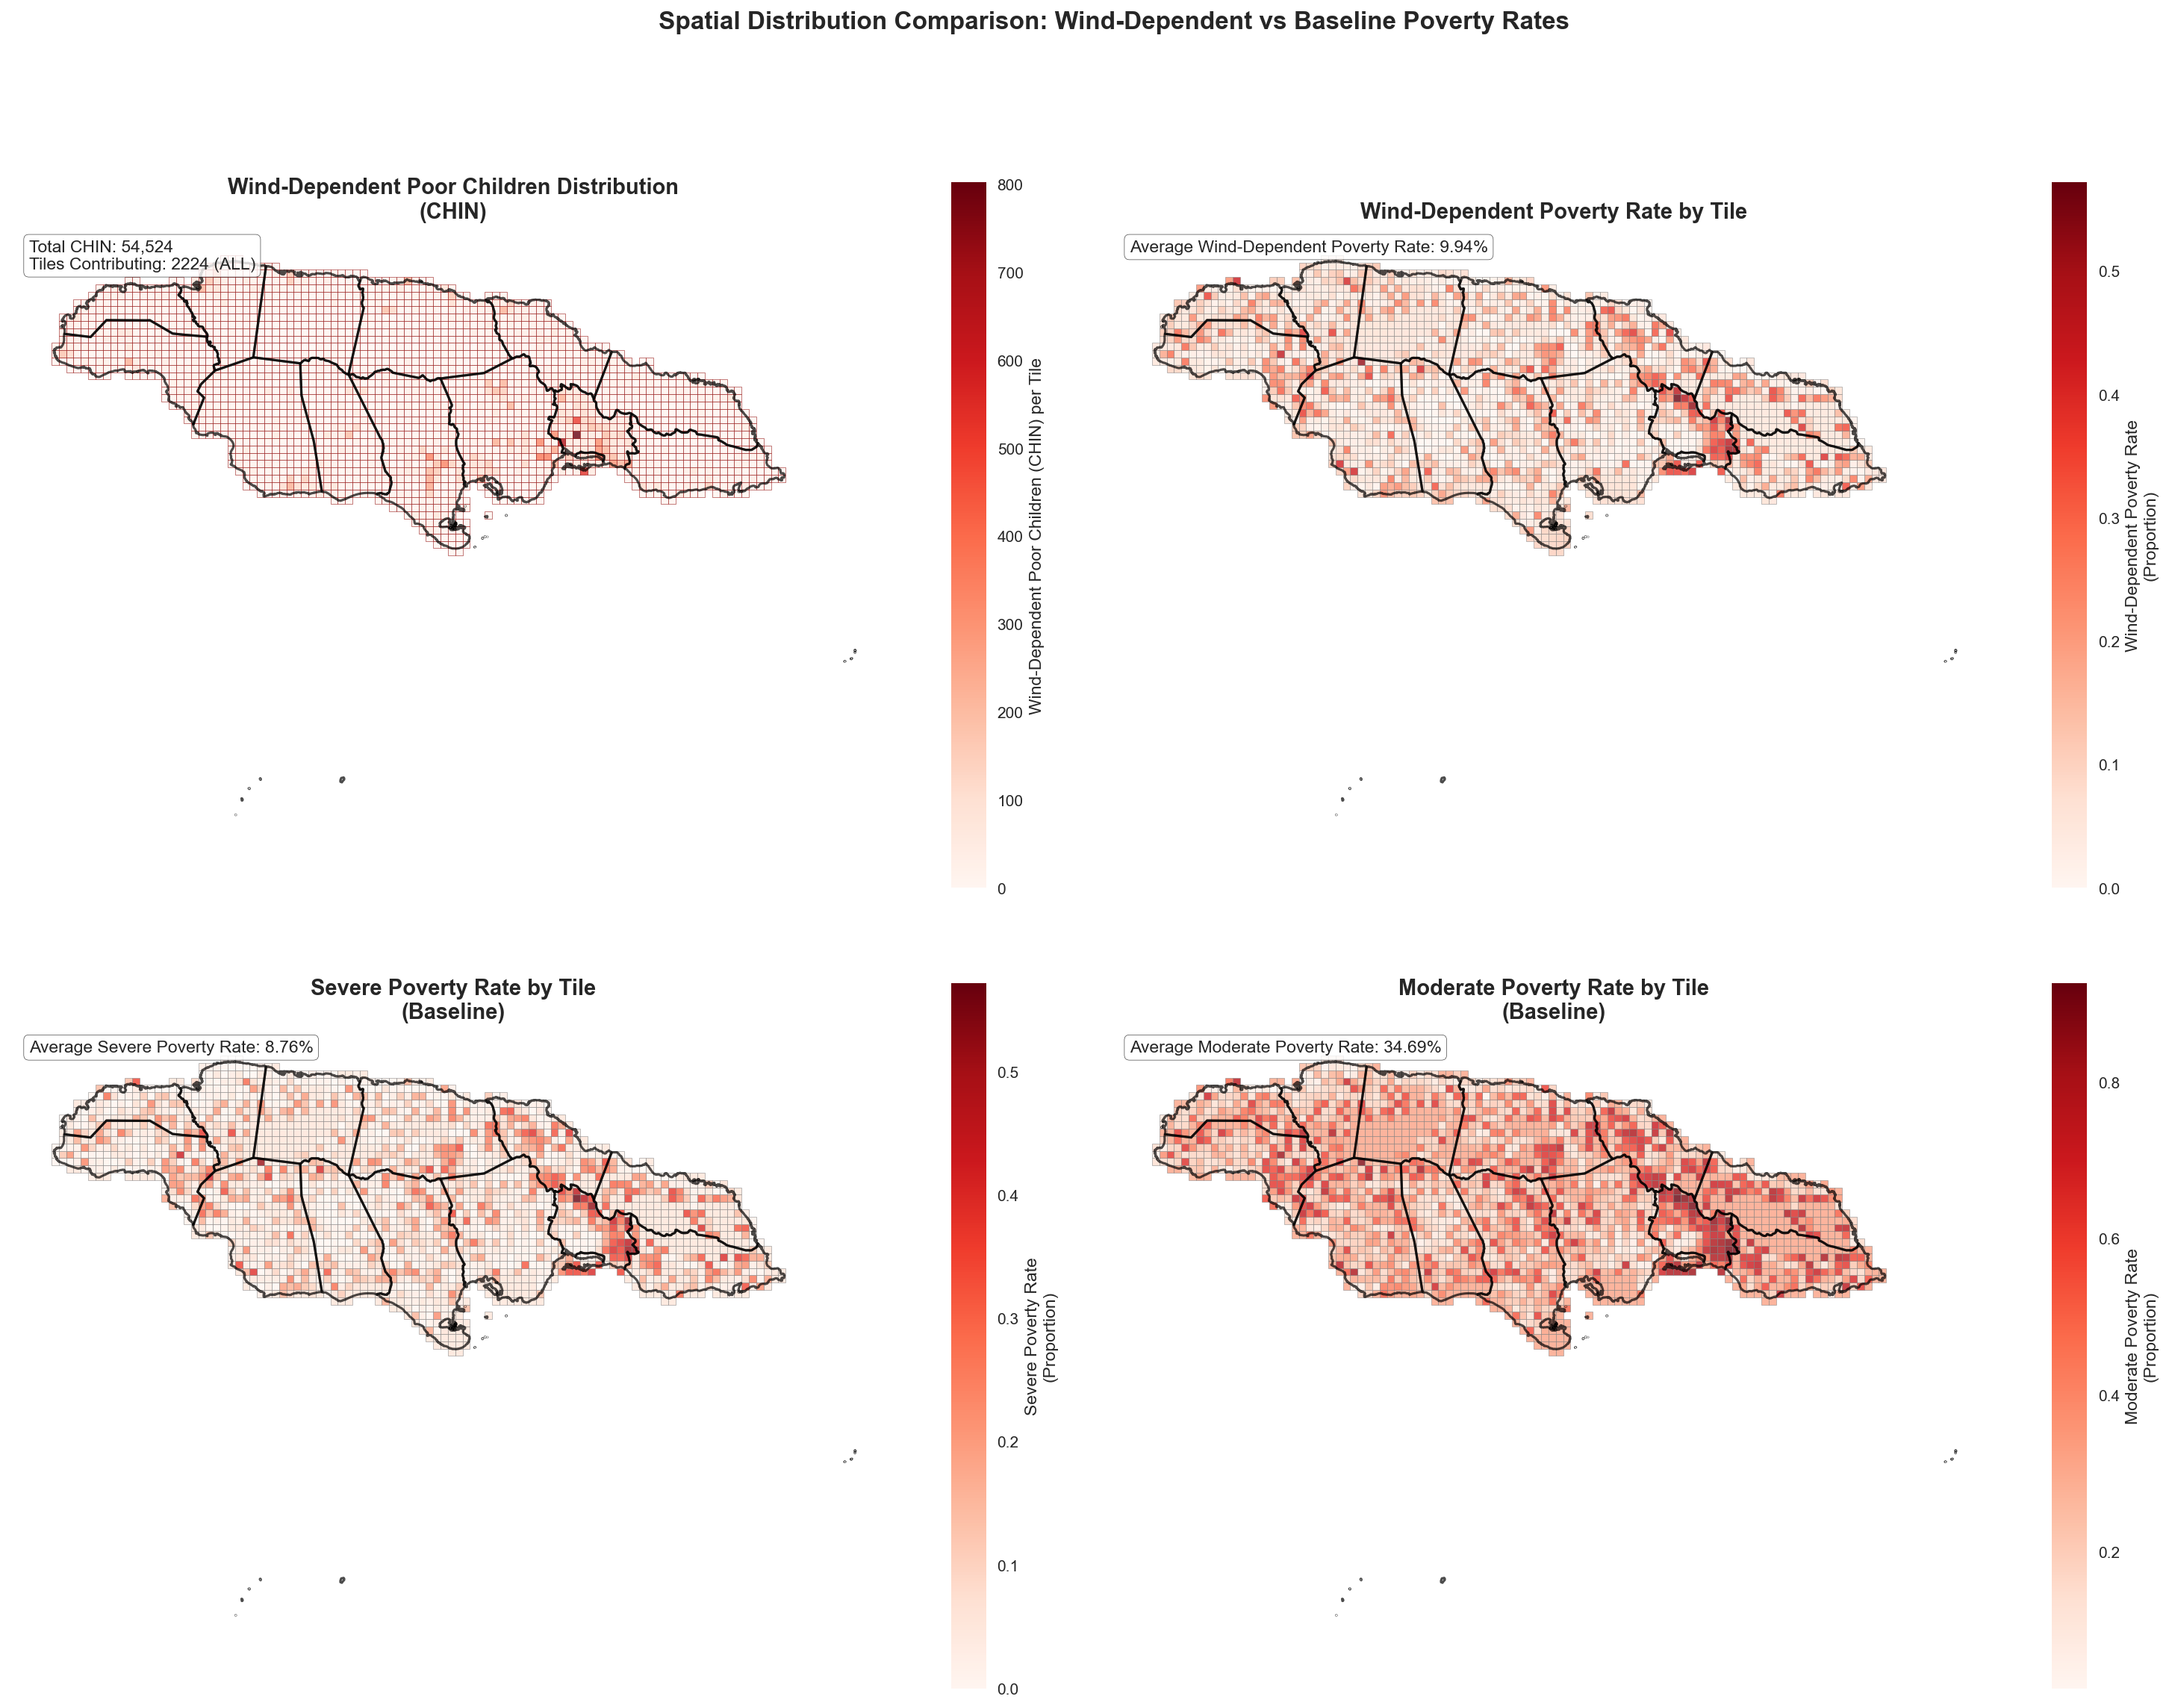

In [19]:
# Create 2x2 comparison map
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Get admin boundaries for context
if 'gdf_admin' in locals() and gdf_admin is not None:
    gdf_admin_plot = gdf_admin.copy()
else:
    gdf_admin_plot = None

# 1. Wind-Dependent Poor Children Distribution Map
ax1 = axes[0, 0]
gdf_tiles_final.plot(
    column='poor_children_wind_dependent',
    cmap='Reds',
    legend=True,
    legend_kwds={'label': 'Wind-Dependent Poor Children (CHIN) per Tile', 'shrink': 0.8},
    ax=ax1,
    alpha=0.8,
    edgecolor='darkred',
    linewidth=0.3
)
if gdf_admin_plot is not None:
    gdf_admin_plot.plot(ax=ax1, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax1.set_title('Wind-Dependent Poor Children Distribution\n(CHIN)', 
              fontsize=14, fontweight='bold')
ax1.axis('off')

# Add summary text
total_poor = gdf_tiles_final['poor_children_wind_dependent'].sum()
total_tiles = len(gdf_tiles_final)
tiles_with_poor = (gdf_tiles_final['poor_children_wind_dependent'] > 0).sum()
ax1.text(0.02, 0.98, 
         f'Total CHIN: {total_poor:,.0f}\nTiles Contributing: {total_tiles} (ALL)',
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Wind-Dependent Poverty Rate Map
ax2 = axes[0, 1]
gdf_tiles_final.plot(
    column='poverty_prob_wind_dependent',
    cmap='Reds',
    legend=True,
    legend_kwds={'label': 'Wind-Dependent Poverty Rate\n(Proportion)', 'shrink': 0.8},
    ax=ax2,
    alpha=0.8,
    edgecolor='gray',
    linewidth=0.3
)
if gdf_admin_plot is not None:
    gdf_admin_plot.plot(ax=ax2, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax2.set_title('Wind-Dependent Poverty Rate by Tile', 
              fontsize=14, fontweight='bold')
ax2.axis('off')

# Add summary text
avg_poverty_rate = gdf_tiles_final['poverty_prob_wind_dependent'].mean()
ax2.text(0.02, 0.98, 
         f'Average Wind-Dependent Poverty Rate: {avg_poverty_rate:.2%}',
         transform=ax2.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Severe Poverty Rate Map (for comparison)
ax3 = axes[1, 0]
gdf_tiles_final.plot(
    column='poverty_prob_severe',
    cmap='Reds',
    legend=True,
    legend_kwds={'label': 'Severe Poverty Rate\n(Proportion)', 'shrink': 0.8},
    ax=ax3,
    alpha=0.8,
    edgecolor='gray',
    linewidth=0.3
)
if gdf_admin_plot is not None:
    gdf_admin_plot.plot(ax=ax3, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax3.set_title('Severe Poverty Rate by Tile\n(Baseline)', 
              fontsize=14, fontweight='bold')
ax3.axis('off')

# Add summary text
avg_severe_rate = gdf_tiles_final['poverty_prob_severe'].mean()
ax3.text(0.02, 0.98, 
         f'Average Severe Poverty Rate: {avg_severe_rate:.2%}',
         transform=ax3.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Moderate Poverty Rate Map (for comparison)
ax4 = axes[1, 1]
gdf_tiles_final.plot(
    column='poverty_prob_moderate',
    cmap='Reds',
    legend=True,
    legend_kwds={'label': 'Moderate Poverty Rate\n(Proportion)', 'shrink': 0.8},
    ax=ax4,
    alpha=0.8,
    edgecolor='gray',
    linewidth=0.3
)
if gdf_admin_plot is not None:
    gdf_admin_plot.plot(ax=ax4, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax4.set_title('Moderate Poverty Rate by Tile\n(Baseline)', 
              fontsize=14, fontweight='bold')
ax4.axis('off')

# Add summary text
avg_moderate_rate = gdf_tiles_final['poverty_prob_moderate'].mean()
ax4.text(0.02, 0.98, 
         f'Average Moderate Poverty Rate: {avg_moderate_rate:.2%}',
         transform=ax4.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Spatial Distribution Comparison: Wind-Dependent vs Baseline Poverty Rates', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


## Tile-Level Impact Probability Visualizations

Visualizations showing impact probability at the tile level for different wind thresholds.

Found 8 impact probability columns:
  34kt: 2224 tiles with impact, max=0.980, avg=0.3734
  40kt: 2224 tiles with impact, max=0.686, avg=0.1642
  50kt: 1329 tiles with impact, max=0.333, avg=0.0417
  64kt: 710 tiles with impact, max=0.146, avg=0.0100
  83kt: 2 tiles with impact, max=0.029, avg=0.0000
  96kt: 0 tiles with impact, max=0.000, avg=0.0000
  113kt: 0 tiles with impact, max=0.000, avg=0.0000
  137kt: 0 tiles with impact, max=0.000, avg=0.0000

Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/impact_probability_tile_level_34_40_50_64kt.png
  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/impact_probability_by_wind_threshold_tile_level_thresholds_34_40_50_64kt.png


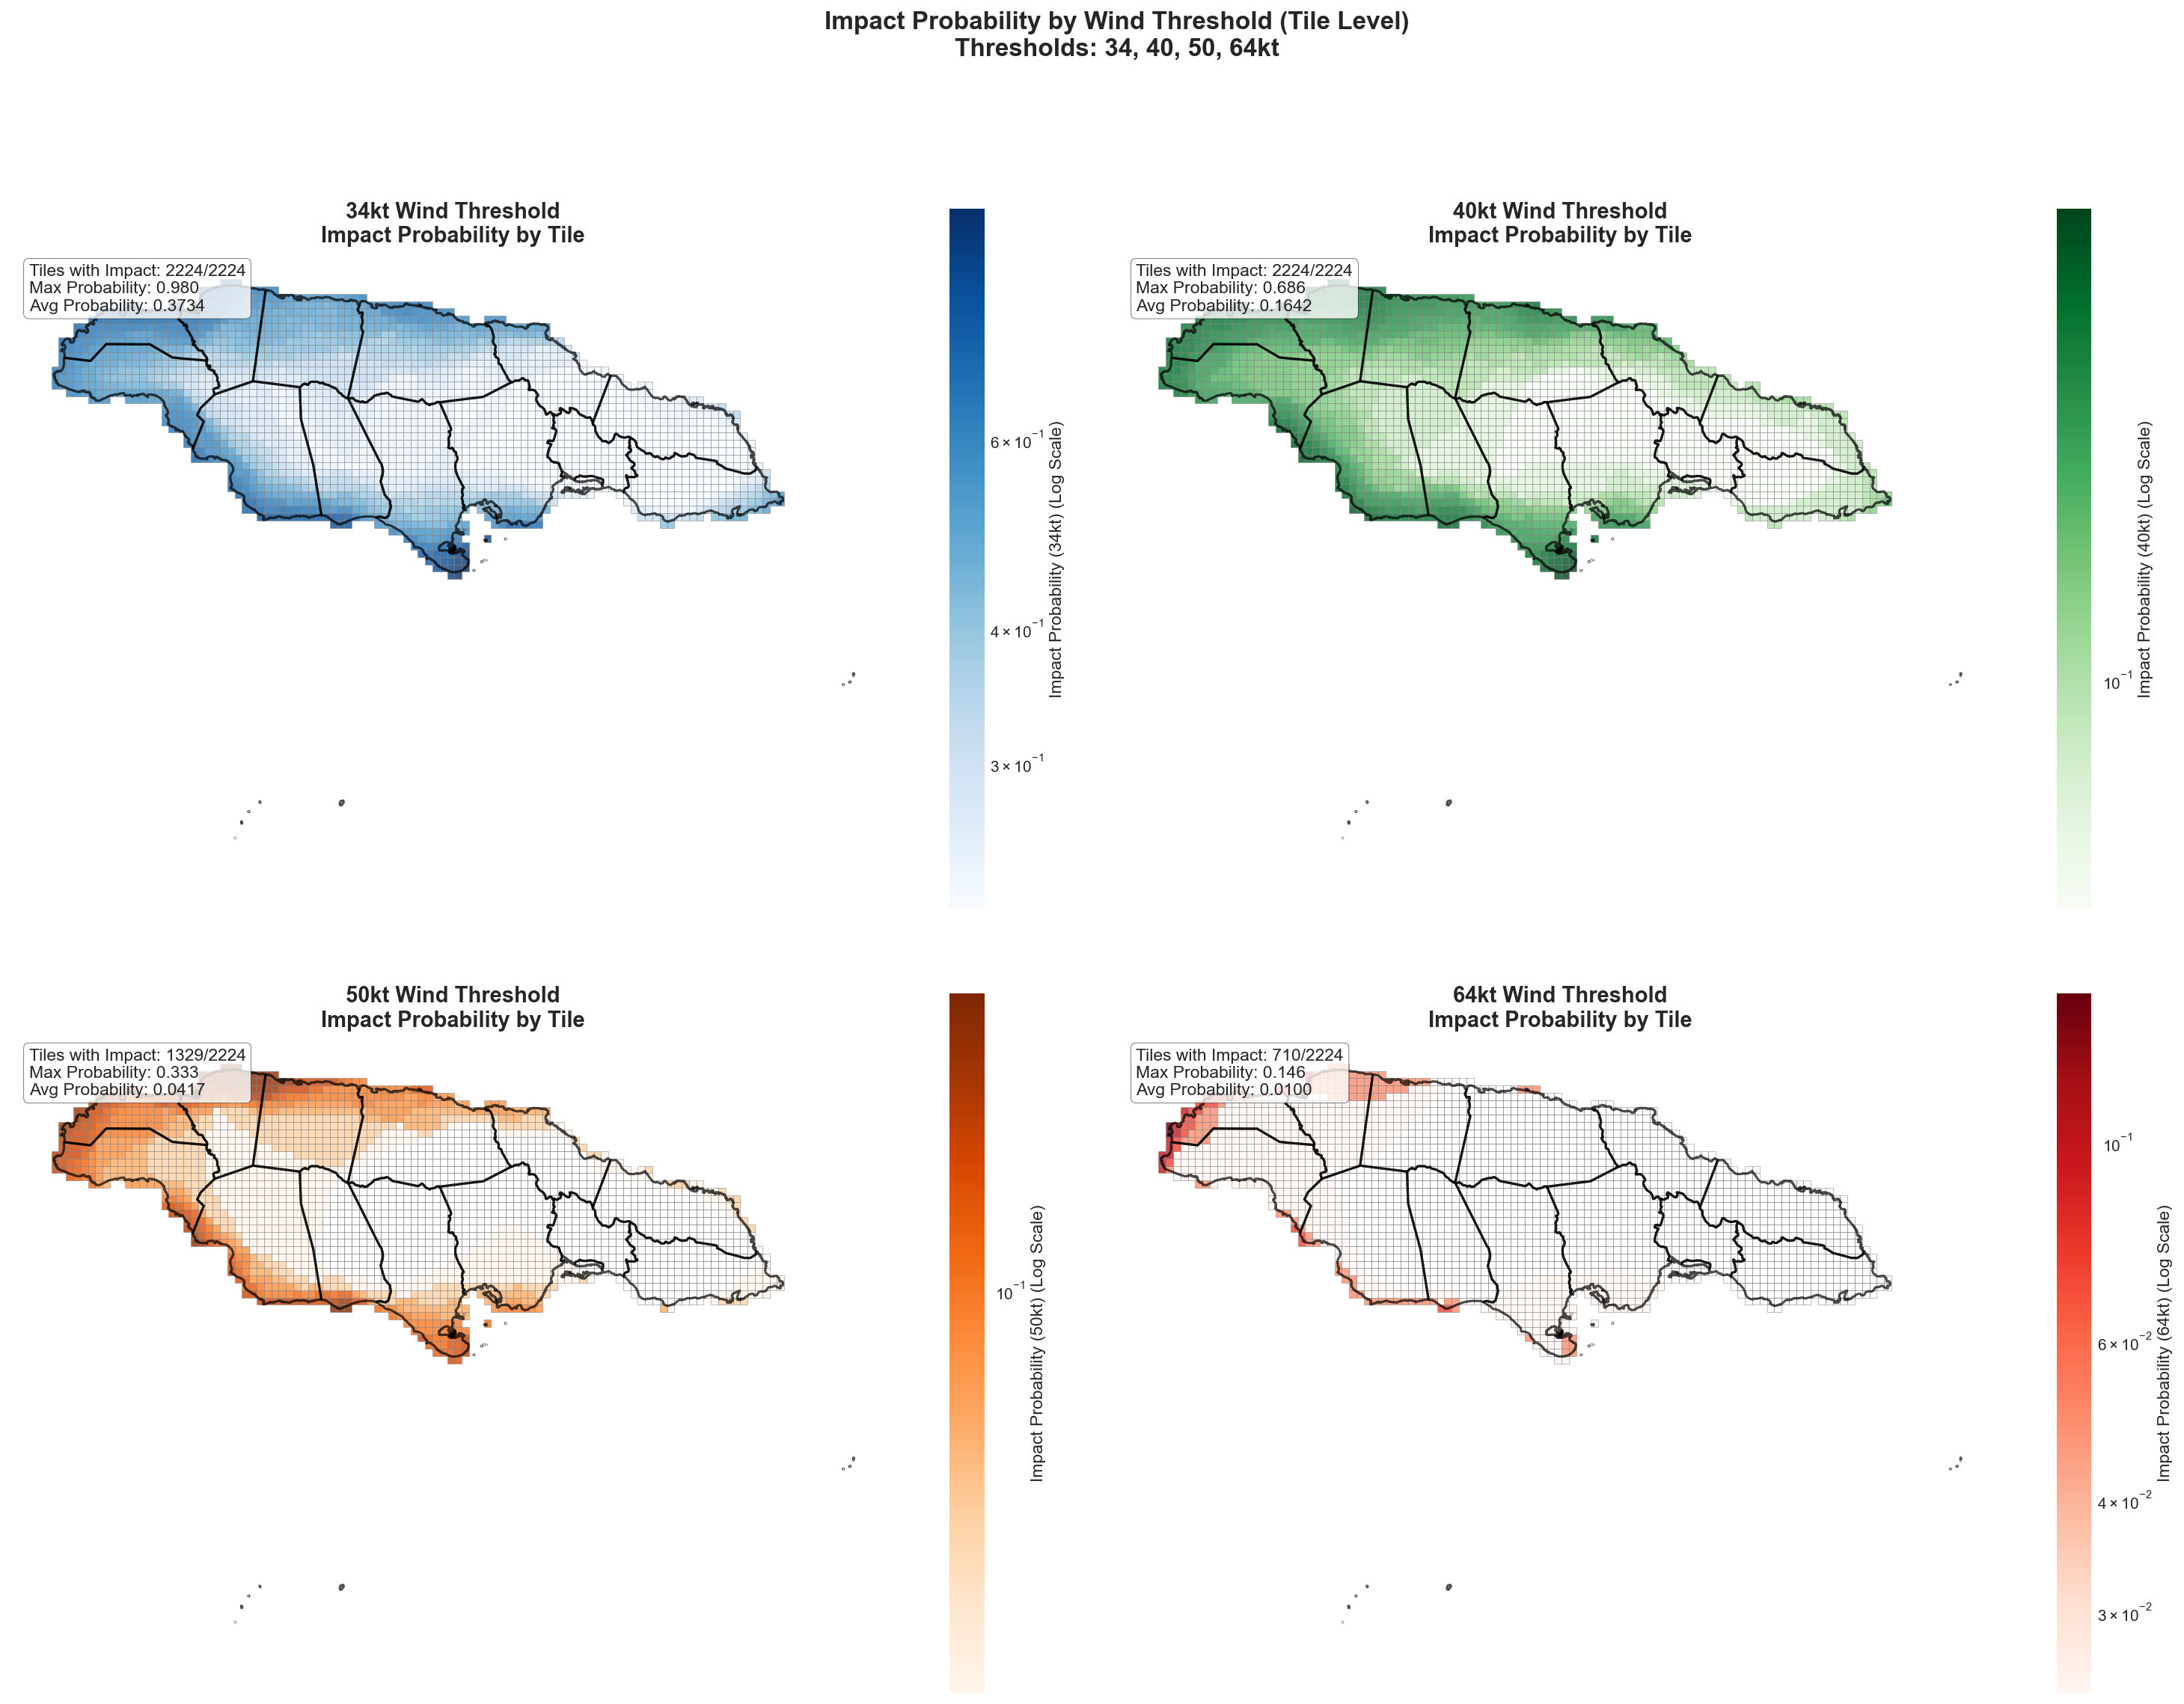


Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/impact_probability_tile_level_83_96_113_137kt.png
  Saved: analysis_output/poor_children_impact_analysis_wind_dependent_poverty/impact_probability_by_wind_threshold_tile_level_thresholds_83_96_113_137kt.png


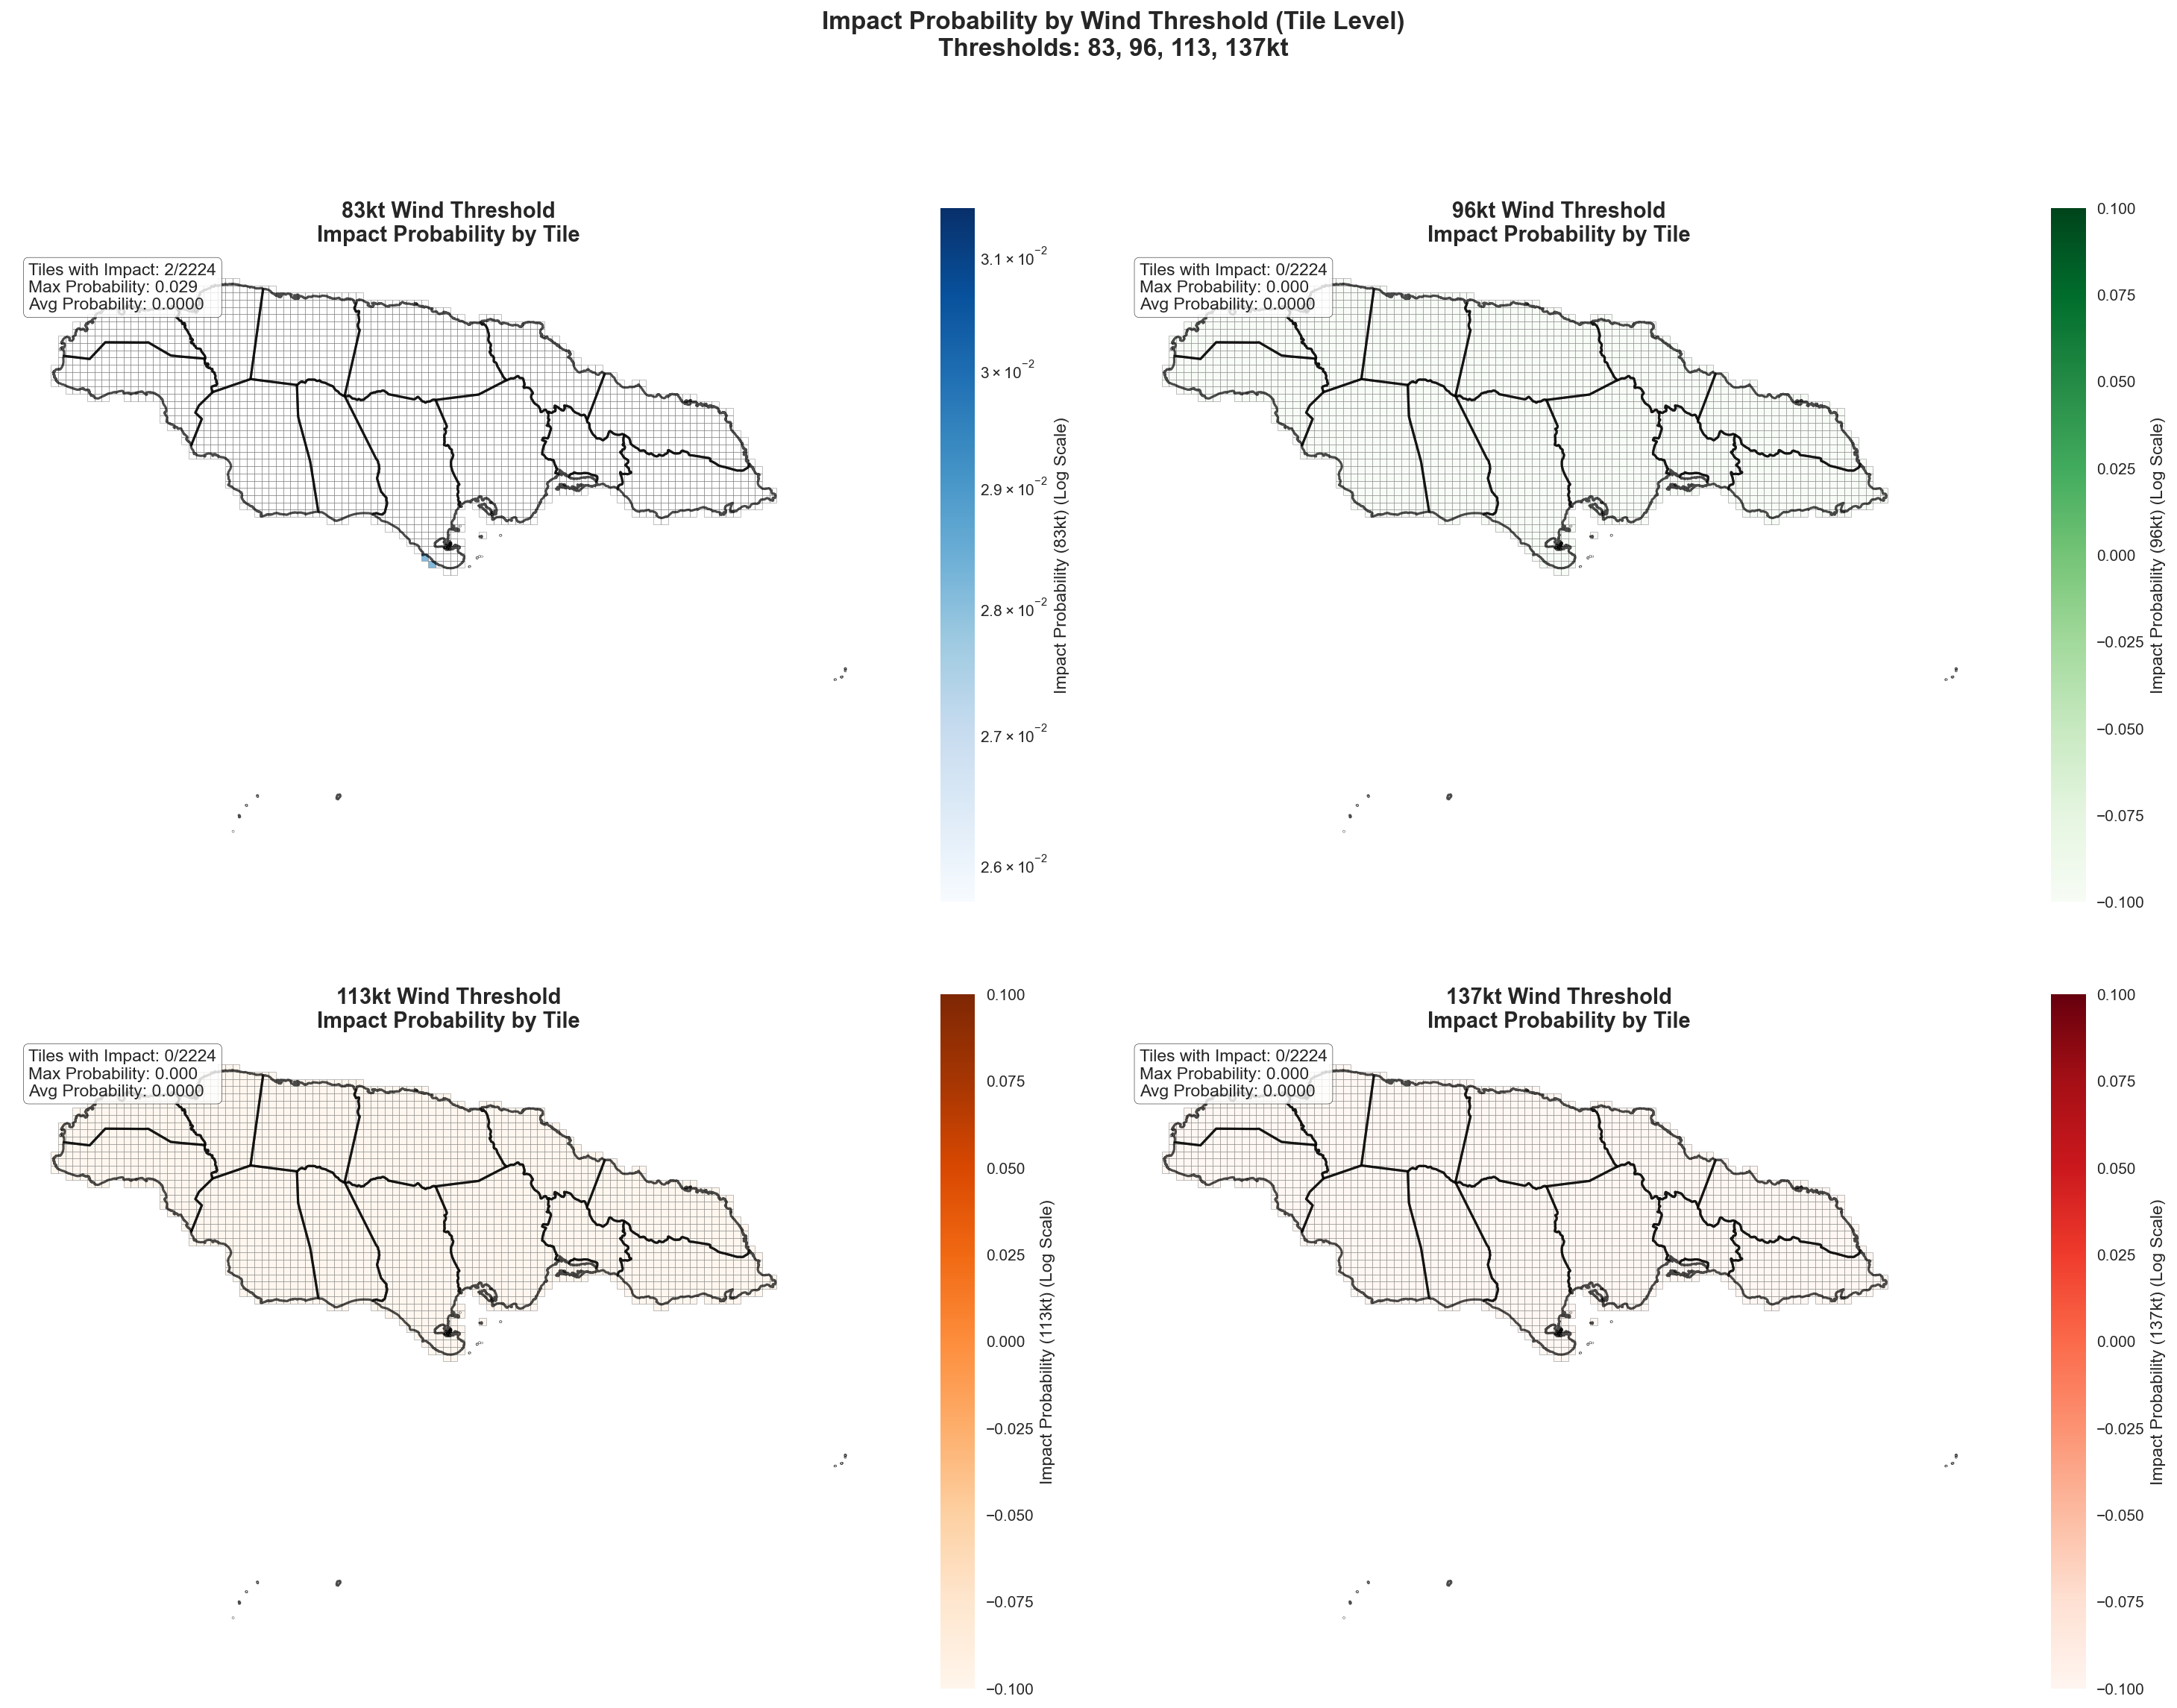

In [20]:
# Tile-Level Impact Probability Visualizations
# Using log scale for better visibility of low probabilities
from matplotlib.colors import LogNorm

# Show impact probability for different wind thresholds at the tile level
# Format: 2x2 grid similar to spatial distribution comparison

# Check if we have impact probability data
impact_prob_cols = []
if 'gdf_tiles_final' in locals():
    for col in gdf_tiles_final.columns:
        if col.startswith('impact_probability_') and col.endswith('kt'):
            impact_prob_cols.append(col)

if impact_prob_cols:
    # Sort by threshold value
    def get_threshold(col):
        return int(col.replace('impact_probability_', '').replace('kt', ''))
    impact_prob_cols.sort(key=get_threshold)
    
    print(f"Found {len(impact_prob_cols)} impact probability columns:")
    for col in impact_prob_cols:
        threshold = col.replace('impact_probability_', '').replace('kt', '')
        tiles_with_impact = (gdf_tiles_final[col].fillna(0) > 0).sum()
        max_prob = gdf_tiles_final[col].fillna(0).max()
        avg_prob = gdf_tiles_final[col].fillna(0).mean()
        print(f"  {threshold}kt: {tiles_with_impact} tiles with impact, max={max_prob:.3f}, avg={avg_prob:.4f}")
    
    # Get admin boundaries for context
    if 'gdf_admin' in locals() and gdf_admin is not None:
        gdf_admin_plot = gdf_admin.copy()
    else:
        gdf_admin_plot = None
    
    # Color maps for different thresholds
    colormaps = ['Blues', 'Greens', 'Oranges', 'Reds']
    
    # Create 2x2 grids for each set of 4 thresholds
    n_thresholds = len(impact_prob_cols)
    n_figures = (n_thresholds + 3) // 4  # Number of 2x2 grids needed
    
    output_dir = 'analysis_output/poor_children_impact_analysis_wind_dependent_poverty'
    os.makedirs(output_dir, exist_ok=True)
    
    for fig_idx in range(n_figures):
        # Get 4 thresholds for this figure
        start_idx = fig_idx * 4
        end_idx = min(start_idx + 4, n_thresholds)
        threshold_cols = impact_prob_cols[start_idx:end_idx]
        
        # Create 2x2 grid
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        # Plot each threshold
        for plot_idx, col in enumerate(threshold_cols):
            row = plot_idx // 2
            col_idx = plot_idx % 2
            ax = axes[row, col_idx]
            threshold = col.replace('impact_probability_', '').replace('kt', '')
            
            # Plot impact probability
            # Calculate min/max for log scale (excluding zeros)
            prob_values = gdf_tiles_final[col].fillna(0)
            prob_values_nonzero = prob_values[prob_values > 0]
            if len(prob_values_nonzero) > 0:
                log_vmin = prob_values_nonzero.min()
                log_vmax = prob_values_nonzero.max()
                # Use LogNorm for better visibility
                norm = LogNorm(vmin=log_vmin, vmax=log_vmax)
            else:
                norm = None
            
            gdf_tiles_final.plot(
                column=col,
                cmap=colormaps[plot_idx % len(colormaps)],
                legend=True,
                legend_kwds={'label': f'Impact Probability ({threshold}kt) (Log Scale)', 'shrink': 0.8},
                ax=ax,
                alpha=0.8,
                edgecolor='gray',
                linewidth=0.3,
                norm=norm,
                
            )

            
            if gdf_admin_plot is not None:
                gdf_admin_plot.plot(ax=ax, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
            
            ax.set_title(f'{threshold}kt Wind Threshold\nImpact Probability by Tile', 
                        fontsize=14, fontweight='bold')
            ax.axis('off')
            
            # Add summary statistics
            tiles_with_impact = (gdf_tiles_final[col].fillna(0) > 0).sum()
            max_prob = gdf_tiles_final[col].fillna(0).max()
            avg_prob = gdf_tiles_final[col].fillna(0).mean()
            total_tiles = len(gdf_tiles_final)
            
            ax.text(0.02, 0.98, 
                   f'Tiles with Impact: {tiles_with_impact}/{total_tiles}\n'
                   f'Max Probability: {max_prob:.3f}\n'
                   f'Avg Probability: {avg_prob:.4f}',
                   transform=ax.transAxes, fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Hide unused subplots if less than 4 thresholds
        for plot_idx in range(len(threshold_cols), 4):
            row = plot_idx // 2
            col_idx = plot_idx % 2
            axes[row, col_idx].axis('off')
        
        # Create title with threshold range
        threshold_labels = [col.replace('impact_probability_', '').replace('kt', '') for col in threshold_cols]
        title = f"Impact Probability by Wind Threshold (Tile Level)\nThresholds: {', '.join(threshold_labels)}kt"
        plt.suptitle(title, fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        
        # Save BEFORE showing
        threshold_str = '_'.join(threshold_labels)
        output_file = os.path.join(output_dir, f'impact_probability_tile_level_{threshold_str}kt.png')
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"\nSaved: {output_file}")
        plt.show()

else:
    print("No impact probability columns found in gdf_tiles_final")
    print("Available columns:", list(gdf_tiles_final.columns) if 'gdf_tiles_final' in locals() else "gdf_tiles_final not defined")